In [1]:
# Train cifar10 through tensorflow dataset

In [2]:
import sys
import time
import argparse

import tenncor as tc

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [3]:
def cross_entropy_loss(Label, Pred):
    return -tc.reduce_sum(Label * tc.log(Pred + np.finfo(float).eps), set([0]))

In [4]:
nbatch = 4
l2_decay = 0.0001
show_every_n = 5
nepochs = 10

ds = tfds.load('cifar10',
    split=tfds.Split.TRAIN,
    batch_size=nbatch,
    shuffle_files=True)
cifar = tfds.as_numpy(ds)

In [5]:
sess = tc.Session()

raw_inshape = [nbatch] + list(ds.output_shapes['image'][1:])
train_outshape = [nbatch, 10]
print(raw_inshape)

train_input = tc.EVariable(raw_inshape, label="trainin")
train_output = tc.EVariable(train_outshape, label="trainout")

[4, 32, 32, 3]


In [6]:
# batch, height, width, in
# construct CNN
model = tc.layer.link([ # minimum input shape of [1, 32, 32, 3]
    tc.layer.conv([5, 5], 3, 16,
        weight_init=tc.norm_xavier_init(0.5),
        zero_padding=[2, 2]), # outputs [nbatch, 32, 32, 16]
    tc.layer.bind(tc.relu),
    tc.layer.bind(lambda x: tc.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 32, 32, 16])), # outputs [nbatch, 16, 16, 16]
    tc.layer.conv([5, 5], 16, 20,
        weight_init=tc.norm_xavier_init(0.3),
        zero_padding=[2, 2]), # outputs [nbatch, 16, 16, 20]
    tc.layer.bind(tc.relu),
    tc.layer.bind(lambda x: tc.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 16, 16, 20])), # outputs [nbatch, 8, 8, 20]
    tc.layer.conv([5, 5], 20, 20,
        weight_init=tc.norm_xavier_init(0.1),
        zero_padding=[2, 2]), # outputs [nbatch, 8, 8, 20]
    tc.layer.bind(tc.relu),
    tc.layer.bind(lambda x: tc.nn.max_pool2d(x, [1, 2]),
        inshape=tc.Shape([1, 8, 8, 20])), # outputs [nbatch, 4, 4, 20]

    tc.layer.dense([4, 4, 20], [10], # weight has shape [10, 4, 4, 20]
        weight_init=tc.norm_xavier_init(0.5),
        bias_init=tc.zero_init(),
        dims=[[0, 1], [1, 2], [2, 3]]), # outputs [nbatch, 10]
    tc.layer.bind(lambda x: tc.softmax(x, 0, 1))
], train_input)

In [7]:
# opt = lambda error, leaves: tc.approx.adagrad(error, leaves, learning_rate=0.01)
opt = lambda error, leaves: tc.approx.adadelta(error, leaves, step_rate=0.01, decay=l2_decay)

normalized = train_input / 255. - 0.5
output_prob = model.connect(normalized)
train_err = tc.sgd_train(model, normalized, train_output,
                         opt, err_func=cross_entropy_loss)
sess.track([train_err, output_prob])
tc.optimize(sess, "cfg/optimizations.json")

In [8]:
query = tc.Statement(sess.get_tracked())
dense_output = query.find('''{ "op":{ 
    "opname":"IDENTITY", 
    "attrs":{ 
        "layer":{ "layer": { "name":"_DENSE_LAYER" } } 
    } 
} }''')[0]

weight_deltas = query.find('''{ "op":{
    "opname":"ASSIGN_SUB",
    "args":[
        { "leaf":{ "shape":[16] } },
        { "symb":"debug" }
    ]
} }''', 'debug')

grs = query.find('''{ "leaf":{
    "label":"ex_sqr_grad",
    "shape":[16]
} }''')
dels = query.find('''{ "leaf":{
    "label":"ex_sqr_delx",
    "shape":[16]
} }''')

In [9]:
terrs = []
try:
    for i, data in enumerate(cifar):
        labels = np.zeros((nbatch, 10))
        for j, label in enumerate(data['label']):
            labels[j][label] = 1
        print('expected label:\n{}'.format(labels))
        train_input.assign(data['image'].astype(np.float))
        train_output.assign(labels.astype(np.float))
        epoch_errs = []
        for j in range(nepochs):
            sess.update_target([train_err, output_prob])
            trained_err = train_err.get()
            prob = output_prob.get()
            epoch_errs.append(np.average(trained_err))
            print('==== epoch {} ===='.format(j))
            print('presoftmax score: {}'.format(dense_output.get()))
            print('got prob: {}'.format(prob))
            outof = np.sum(prob, axis=1)
            print('out of: {}'.format(outof))
            
            print('grs: {}'.format(grs[0].get()))
            print('dels: {}'.format(dels[0].get()))
            print('deltas: {}'.format(weight_deltas[0].get()))
            
            assert(np.all([s > 0.95 for s in outof]))
            print('training error: {}'.format(trained_err))
        avg_err = epoch_errs[-1]
        if i % show_every_n == show_every_n - 1:
            print('==== {}th image ====\naverage error:\n{}'
                .format(i, avg_err))
        terrs.append(avg_err)
except KeyboardInterrupt:
    print("Interrupted")

expected label:
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
==== epoch 0 ====
presoftmax score: [[0.09178553 0.09453723 0.08856897 0.09687755 0.11837182 0.11538644
  0.07695559 0.09548465 0.10194539 0.1200869 ]
 [0.07585609 0.08488137 0.09861147 0.06608005 0.157222   0.13595395
  0.07651715 0.08058474 0.10281289 0.12148032]
 [0.07536628 0.08659165 0.07787462 0.07556954 0.13852847 0.13680868
  0.08065394 0.09843109 0.10257293 0.12760277]
 [0.0760111  0.09149507 0.08421709 0.07352589 0.13245647 0.14142193
  0.06982467 0.0882462  0.10496319 0.13783836]]
got prob: [[0.0925953  0.09574325 0.08946235 0.09665964 0.11533304 0.11588784
  0.07720522 0.09720537 0.10119684 0.11871114]
 [0.07653666 0.08636626 0.10038882 0.06689972 0.14865653 0.13708207
  0.07755179 0.08364518 0.10327014 0.11960287]
 [0.07677901 0.08892913 0.07947268 0.07650936 0.12986854 0.1377059
  0.08152089 0.10177961 0.10158697 0.12584789]


==== epoch 5 ====
presoftmax score: [[0.08808982 0.08858484 0.08415689 0.09766965 0.13399947 0.11320046
  0.07463655 0.08791029 0.10346794 0.12828419]
 [0.06980025 0.07762322 0.08932652 0.06070241 0.20327057 0.12796578
  0.06994564 0.06857632 0.09890054 0.13388878]
 [0.06755714 0.07555091 0.07040537 0.0700769  0.18802707 0.13157456
  0.07490418 0.0832332  0.10202307 0.13664758]
 [0.07049496 0.08249946 0.07745535 0.06797451 0.15929288 0.13687801
  0.06543154 0.07538858 0.10154513 0.16303952]]
got prob: [[0.08881915 0.0897916  0.08518685 0.09767548 0.13069025 0.11333953
  0.07546246 0.08916642 0.1033802  0.12648797]
 [0.07110211 0.07911086 0.09132013 0.06187623 0.1935636  0.12968305
  0.07161294 0.07085148 0.09989812 0.13098145]
 [0.06913302 0.07765611 0.07205018 0.07153063 0.17701007 0.13240145
  0.07662389 0.08636381 0.1025586  0.13467221]
 [0.07166421 0.08409236 0.0788665  0.06916159 0.15349652 0.13782328
  0.06649804 0.07789345 0.1024475  0.15805656]]
out of: [0.9999999  0.99999994 1

==== epoch 0 ====
presoftmax score: [[0.06548677 0.07195596 0.06802379 0.05843166 0.20179433 0.1454774
  0.07413235 0.06337699 0.08542253 0.16589819]
 [0.09273201 0.0820279  0.08792855 0.09475264 0.12875181 0.12033099
  0.08196577 0.08796233 0.09936452 0.12418331]
 [0.06320547 0.0723829  0.07919994 0.08892576 0.13816267 0.12542006
  0.07570685 0.08854797 0.10661571 0.16183268]
 [0.0549066  0.07118696 0.06754611 0.05475252 0.2510173  0.11793847
  0.0564395  0.05383468 0.07931028 0.19306755]]
got prob: [[0.06536496 0.07324328 0.06942461 0.05961558 0.19580837 0.14698829
  0.07547154 0.06417207 0.0865768  0.1633345 ]
 [0.09186243 0.0821777  0.08834222 0.09496711 0.12864631 0.12128165
  0.08223827 0.08696655 0.09956802 0.12394974]
 [0.06276046 0.0717729  0.079354   0.08912166 0.14174426 0.12790366
  0.07521383 0.08222301 0.1078052  0.162101  ]
 [0.05504359 0.07273634 0.06976757 0.05660889 0.24662854 0.12018251
  0.05821602 0.05471611 0.08117487 0.18492548]]
out of: [1.         1.         1.

==== epoch 6 ====
presoftmax score: [[0.06432595 0.06439085 0.05923325 0.05141278 0.24640304 0.13382158
  0.0633094  0.05774238 0.07543286 0.1839279 ]
 [0.09857566 0.08090633 0.08588381 0.09243169 0.12937069 0.11499919
  0.07931306 0.0950459  0.09628978 0.12718381]
 [0.06380331 0.07583001 0.07654303 0.08493217 0.12340399 0.10868515
  0.07586706 0.13269286 0.09927316 0.15896916]
 [0.05273188 0.06087339 0.05418408 0.04410837 0.27505645 0.10367668
  0.0450559  0.0503228  0.06543996 0.24855044]]
got prob: [[0.06465919 0.06542612 0.06100433 0.05264594 0.23822175 0.13620923
  0.06524053 0.05872748 0.07744364 0.1804217 ]
 [0.09749592 0.08111041 0.08625706 0.09289972 0.12932852 0.11600347
  0.07972976 0.09372747 0.0968962  0.12655137]
 [0.06404602 0.07549154 0.07717765 0.08581064 0.12592663 0.11145645
  0.07592861 0.12416553 0.1004255  0.15957148]
 [0.05309468 0.06235884 0.05657746 0.04584897 0.27184674 0.10609128
  0.04682854 0.0508475  0.06805302 0.23845296]]
out of: [0.99999994 0.9999999  1

==== epoch 2 ====
presoftmax score: [[0.07883106 0.08306336 0.05449483 0.04730241 0.24314883 0.09685106
  0.04311248 0.07496047 0.07351382 0.20472163]
 [0.06344442 0.06788423 0.06719965 0.05936521 0.23141848 0.1160522
  0.04500366 0.06622852 0.0889062  0.19449739]
 [0.08673359 0.06074813 0.04767815 0.04672294 0.196258   0.10303838
  0.03805831 0.08628065 0.0681405  0.26634142]
 [0.07609686 0.06048406 0.05980836 0.04708358 0.18312654 0.108116
  0.04729835 0.07285196 0.07888389 0.26625028]]
got prob: [[0.07559143 0.08140739 0.05591339 0.04777464 0.24953559 0.09793822
  0.0437721  0.07572149 0.07574401 0.19660167]
 [0.06142241 0.06571154 0.06846347 0.05989252 0.2345211  0.1166606
  0.0458719  0.06591821 0.09044558 0.19109271]
 [0.07868245 0.05949464 0.0489675  0.04765359 0.20317319 0.1048135
  0.03911179 0.08602088 0.07035207 0.26173037]
 [0.07215858 0.05934585 0.06134252 0.04763222 0.1887877  0.11008038
  0.0481241  0.07279433 0.08123074 0.25850353]]
out of: [0.99999994 1.         1.    

==== epoch 8 ====
presoftmax score: [[0.09828696 0.09259753 0.04543383 0.04209105 0.20837733 0.08772241
  0.03862444 0.07171747 0.05882276 0.25632617]
 [0.07559809 0.08049685 0.05906466 0.05477992 0.21632004 0.10938512
  0.04058955 0.06711499 0.07821636 0.2184343 ]
 [0.1511437  0.0666673  0.03901363 0.040438   0.16166875 0.08913139
  0.0318565  0.08394481 0.05221816 0.28391775]
 [0.10056189 0.06353126 0.04911314 0.04238051 0.15253943 0.09650837
  0.04112821 0.07140734 0.06380767 0.31902218]]
got prob: [[0.09505866 0.09153584 0.04700321 0.04315303 0.21411477 0.08912987
  0.03964173 0.07210954 0.06137495 0.24687836]
 [0.07353081 0.07829864 0.06044672 0.05574279 0.2185088  0.1108161
  0.04123174 0.06699813 0.08045781 0.21396846]
 [0.13889754 0.06622653 0.04045222 0.04176903 0.16729301 0.09183592
  0.03321636 0.08457015 0.05523432 0.2805049 ]
 [0.09633479 0.06357443 0.05110126 0.04344378 0.15726633 0.09856365
  0.04254189 0.07199968 0.06634295 0.30883124]]
out of: [1. 1. 1. 1.]
grs: [0.004

out of: [1.         0.99999994 1.         1.        ]
grs: [1.42092139e-01 3.21787223e-02 3.45619887e-01 5.85058342e-06
 6.95031807e-02 3.45482603e-02 1.76208876e-02 3.96862626e-03
 2.81506240e-01 5.63965328e-02 5.33975661e-01 8.56620297e-02
 6.91019446e-02 3.62098157e-01 1.50331557e-01 1.14212334e-01]
dels: [9.9941051e-09 9.9708499e-09 9.9982840e-09 5.0080617e-10 9.9869730e-09
 9.9707265e-09 9.9426041e-09 9.7555564e-09 9.9972999e-09 9.9833475e-09
 9.9989768e-09 9.9896127e-09 9.9860840e-09 9.9982840e-09 9.9947455e-09
 9.9925357e-09]
deltas: [ 9.9970523e-05 -9.9854275e-05 -9.9991419e-05  2.2357855e-05
 -9.9934849e-05  9.9853518e-05 -9.9712590e-05  9.8770317e-05
  9.9986501e-05 -9.9916702e-05  9.9994882e-05  9.9948054e-05
  9.9930396e-05  9.9991419e-05 -9.9973724e-05 -9.9962672e-05]
training error: [[2.798914 ]
 [2.0615027]
 [1.0025455]
 [2.3560276]]
==== epoch 4 ====
presoftmax score: [[0.10942248 0.10980052 0.06317827 0.06029929 0.16780624 0.09407806
  0.05659863 0.07778262 0.06387793 

==== epoch 0 ====
presoftmax score: [[0.14300232 0.09562062 0.06820622 0.04237467 0.10322733 0.07254735
  0.05294403 0.10418095 0.05039997 0.2674965 ]
 [0.16482721 0.0843654  0.06266539 0.06141943 0.08163086 0.09262598
  0.05924607 0.10665093 0.04600504 0.24056363]
 [0.1045144  0.10902203 0.05441108 0.05079857 0.21240757 0.08731684
  0.04447773 0.05611933 0.05358372 0.22734863]
 [0.1217232  0.09340347 0.06549399 0.05018097 0.1163705  0.09573808
  0.04992555 0.10068141 0.04999747 0.25648537]]
got prob: [[0.14137259 0.09737482 0.06668461 0.0408304  0.10535241 0.07280862
  0.04714645 0.10197566 0.04825456 0.27819994]
 [0.16592549 0.08571308 0.06165472 0.05968039 0.0826807  0.09346716
  0.05571235 0.10520267 0.0434419  0.24652158]
 [0.10213706 0.10899927 0.0528297  0.04950104 0.2185736  0.08772714
  0.04115257 0.05449921 0.05147548 0.23310499]
 [0.1180993  0.09393311 0.06403024 0.04869929 0.11880186 0.09665582
  0.04653249 0.09854431 0.04814065 0.26656297]]
out of: [1.0000001 1.        1.0

==== epoch 5 ====
presoftmax score: [[0.14617658 0.08534897 0.07241656 0.04879727 0.09394622 0.07026697
  0.08835974 0.11373517 0.06059376 0.22035879]
 [0.1560153  0.0778703  0.06649983 0.06984901 0.07536513 0.08838519
  0.0781243  0.11303297 0.05958614 0.21527188]
 [0.11285634 0.1073777  0.06080199 0.05682907 0.18401319 0.0852857
  0.06226236 0.06309468 0.0636083  0.20387062]
 [0.13831666 0.08877595 0.07059721 0.05687745 0.10600404 0.08945853
  0.0676994  0.10869742 0.05839885 0.21517453]]
got prob: [[0.14598544 0.08766571 0.07204853 0.04777757 0.09600281 0.07101932
  0.08040027 0.11229323 0.05835512 0.22845198]
 [0.1578652  0.07922916 0.06586816 0.06817415 0.07656889 0.089338
  0.07445755 0.11199769 0.05658195 0.21991919]
 [0.11136671 0.10794753 0.05969343 0.0557308  0.1894817  0.08573203
  0.05858441 0.06185298 0.06165526 0.20795514]
 [0.13500093 0.09007967 0.06989247 0.05567883 0.10792429 0.09102505
  0.06405158 0.10739491 0.05680504 0.22214718]]
out of: [1.         1.         1.  

==== epoch 0 ====
presoftmax score: [[0.15344064 0.07882913 0.07721122 0.06716835 0.09140095 0.06812181
  0.10165133 0.12284206 0.07385794 0.16547658]
 [0.12654808 0.11109031 0.0724846  0.06915689 0.12816204 0.07541522
  0.09030351 0.09661079 0.0751676  0.15506099]
 [0.11357671 0.1011631  0.05891143 0.05648807 0.17588061 0.07707684
  0.08298134 0.07436904 0.05610697 0.20344597]
 [0.13105719 0.09918982 0.06467577 0.05482042 0.10763058 0.08732703
  0.08118037 0.08718707 0.0718837  0.21504796]]
got prob: [[0.15680541 0.07687816 0.07682178 0.06611373 0.09454908 0.06942745
  0.09986354 0.11442314 0.07390674 0.17121093]
 [0.12889662 0.10790955 0.07196184 0.06724422 0.13112295 0.07634629
  0.08825639 0.0930452  0.07489525 0.16032162]
 [0.11567185 0.09734779 0.05741328 0.05419413 0.18110721 0.07789432
  0.07821525 0.07016135 0.05568765 0.21230724]
 [0.1345428  0.09201025 0.0634284  0.05331424 0.11179555 0.08852264
  0.07898543 0.08212633 0.07153449 0.22373989]]
out of: [1.        0.9999999 1.0

==== epoch 6 ====
presoftmax score: [[0.13302885 0.08971977 0.07440469 0.07156335 0.07539308 0.05998094
  0.10789523 0.17641139 0.07153105 0.1400717 ]
 [0.11213879 0.12405744 0.07325525 0.08006135 0.11253057 0.0711183
  0.10264217 0.1170759  0.07534692 0.13177337]
 [0.09557962 0.12014522 0.06309449 0.07032365 0.15108049 0.07265357
  0.11561009 0.09552312 0.05710341 0.15888634]
 [0.1099382  0.1488041  0.06950568 0.06168319 0.08719905 0.07802399
  0.09077743 0.11462297 0.06999186 0.16945358]]
got prob: [[0.13623194 0.08821084 0.07511748 0.07104807 0.07777761 0.06152399
  0.10726003 0.16741922 0.07196954 0.14344126]
 [0.11473571 0.12201528 0.07330402 0.07813184 0.11497897 0.07193775
  0.10044425 0.11426591 0.07551931 0.13466701]
 [0.09875574 0.11778725 0.06269589 0.06827502 0.15475725 0.07343823
  0.11002981 0.0927641  0.05724417 0.16425253]
 [0.11372929 0.13960503 0.06912584 0.06091393 0.09022816 0.08036484
  0.08956324 0.11019567 0.07050582 0.17576814]]
out of: [0.99999994 1.0000001  1.

==== epoch 2 ====
presoftmax score: [[0.12642996 0.1211443  0.0648947  0.06767163 0.0826465  0.08258371
  0.08861138 0.14434053 0.0537402  0.1679371 ]
 [0.12402157 0.14738882 0.06229702 0.05808131 0.10099398 0.08087788
  0.10287329 0.10340159 0.05820716 0.16185738]
 [0.10394117 0.1627379  0.0710896  0.06824843 0.12223884 0.07401729
  0.09117573 0.09170505 0.06252994 0.1523161 ]
 [0.12535156 0.10292707 0.08166701 0.06030026 0.10520811 0.07815228
  0.08873458 0.12612642 0.05920206 0.17233074]]
got prob: [[0.12219898 0.12057536 0.06555449 0.06839526 0.0835387  0.0776471
  0.08810062 0.14968757 0.05403897 0.17026293]
 [0.12180921 0.1431086  0.06320366 0.0581152  0.10291801 0.07935048
  0.10115998 0.10507568 0.05898178 0.16627736]
 [0.10227516 0.16040388 0.07206946 0.06824956 0.12357672 0.07301058
  0.08887486 0.09287915 0.06319641 0.15546432]
 [0.11920685 0.10103302 0.08266889 0.06050998 0.1060335  0.07673521
  0.08815737 0.12907243 0.05973556 0.17684725]]
out of: [0.99999994 0.99999994 1.

==== epoch 7 ====
presoftmax score: [[0.14307152 0.12322977 0.06186827 0.06401981 0.07629689 0.11229897
  0.09037445 0.12277749 0.05112938 0.1549335 ]
 [0.13305265 0.17069548 0.0572399  0.05650048 0.09243537 0.08659016
  0.10884359 0.09698319 0.05444322 0.14321603]
 [0.11089249 0.17263648 0.06745663 0.06794323 0.11480191 0.07772396
  0.10330869 0.08622383 0.05954169 0.13947119]
 [0.15447785 0.11010736 0.07394127 0.05757099 0.10091579 0.08581101
  0.09225503 0.11396954 0.05655149 0.15439962]]
got prob: [[0.14042667 0.12274417 0.06250358 0.06495053 0.07798676 0.10576602
  0.08978345 0.1269476  0.05170922 0.15718198]
 [0.13161232 0.16633295 0.05817144 0.05679845 0.09447728 0.08571117
  0.10761213 0.09797092 0.05531362 0.14599964]
 [0.10970959 0.170997   0.06811965 0.06806011 0.11664356 0.07701296
  0.10084838 0.08719843 0.06000531 0.14140509]
 [0.14906888 0.1090401  0.07574089 0.05818896 0.10211933 0.084142
  0.09140563 0.11603323 0.05718302 0.15707801]]
out of: [0.99999994 1.         1. 

==== epoch 2 ====
presoftmax score: [[0.12795357 0.11766277 0.0868476  0.07546286 0.09404455 0.0850793
  0.1066183  0.13202155 0.06358251 0.11072709]
 [0.12191714 0.14904952 0.08290818 0.07094596 0.11620691 0.0833898
  0.10313629 0.08210089 0.06083759 0.12950777]
 [0.11666393 0.11206219 0.1022294  0.08617564 0.09902302 0.08531432
  0.09598107 0.11349089 0.06783087 0.12122861]
 [0.13751718 0.11243916 0.05764178 0.07814868 0.06743241 0.08502574
  0.11656989 0.12548946 0.07677414 0.14296156]]
got prob: [[0.13068223 0.11995366 0.08410918 0.07271004 0.09143372 0.08484416
  0.10799441 0.13527592 0.06158275 0.11141383]
 [0.12564902 0.15168223 0.08112571 0.07039464 0.10957585 0.08327823
  0.10401456 0.08473695 0.05930684 0.13023606]
 [0.11906584 0.1134025  0.09926397 0.08509999 0.09601095 0.08580676
  0.09650369 0.1158544  0.06673142 0.12226039]
 [0.14133222 0.11237686 0.05653305 0.07632376 0.06563716 0.08531077
  0.11612613 0.12827    0.0731755  0.14491455]]
out of: [0.99999994 1.0000001  0.9

==== epoch 7 ====
presoftmax score: [[0.11540243 0.10752786 0.0961367  0.08938643 0.10640953 0.08683027
  0.10050888 0.11663745 0.07299796 0.10816247]
 [0.10748953 0.13602337 0.08682723 0.07223166 0.15181237 0.08580736
  0.09520964 0.07116356 0.06637631 0.12705895]
 [0.10568177 0.10466464 0.11490893 0.09184183 0.11266419 0.08602393
  0.0926428  0.10235659 0.07374928 0.11546604]
 [0.12250315 0.11165266 0.06016788 0.08558481 0.07595759 0.08314845
  0.11759645 0.11363183 0.09565885 0.13409837]]
got prob: [[0.1176453  0.10942892 0.09476104 0.08651939 0.10425898 0.0863722
  0.10159364 0.11943778 0.07130329 0.10867953]
 [0.11010584 0.13844426 0.08662058 0.07211659 0.14456992 0.08530363
  0.09693149 0.0731822  0.06528708 0.12743844]
 [0.10741209 0.10607821 0.11265085 0.09075249 0.11011334 0.08563709
  0.09330454 0.10475443 0.07256974 0.11672716]
 [0.12510435 0.11242715 0.05991928 0.08426627 0.07459834 0.08333974
  0.11734497 0.11565095 0.09183668 0.13551223]]
out of: [1.         1.         0.

==== epoch 2 ====
presoftmax score: [[0.08761948 0.12654786 0.07768103 0.07846899 0.14722109 0.09447452
  0.11821578 0.06663845 0.07543486 0.12769797]
 [0.08452377 0.12920196 0.07451977 0.07390119 0.17137423 0.09859639
  0.10649317 0.0596159  0.06966504 0.1321085 ]
 [0.0909472  0.11557508 0.09869225 0.09670212 0.09933826 0.09448696
  0.11305235 0.09367754 0.08187187 0.1156563 ]
 [0.09420185 0.10235656 0.10953005 0.09184774 0.12279762 0.08251902
  0.09604122 0.10552007 0.07998453 0.11520132]]
got prob: [[0.08930656 0.12904601 0.07445189 0.07809016 0.14785618 0.09207537
  0.11863049 0.06682029 0.07473934 0.12898377]
 [0.08642694 0.13279933 0.07093142 0.07323337 0.17260593 0.09513222
  0.10646585 0.05949078 0.06857821 0.13433604]
 [0.09228224 0.11659105 0.09687538 0.09644607 0.09994524 0.09227031
  0.11390637 0.09389023 0.08183293 0.11596019]
 [0.09595533 0.1034639  0.10414618 0.09117774 0.12395778 0.08117584
  0.097328   0.10604423 0.07993837 0.11681265]]
out of: [1. 1. 1. 1.]
grs: [0.00

==== epoch 7 ====
presoftmax score: [[0.07894172 0.11723167 0.09235992 0.07823901 0.14437076 0.10613474
  0.1140451  0.06623755 0.07932194 0.12311757]
 [0.07389226 0.11416192 0.09116964 0.07475316 0.16462457 0.11753723
  0.10519455 0.05963963 0.07420178 0.12482528]
 [0.08432743 0.11276888 0.10600882 0.097489   0.09685344 0.10632476
  0.1065162  0.09257773 0.08243311 0.11470065]
 [0.08633044 0.097877   0.13583869 0.09354009 0.11785839 0.08806474
  0.08917319 0.10320263 0.0797721  0.10834269]]
got prob: [[0.08051847 0.11868595 0.08963335 0.07844291 0.14530823 0.10360792
  0.11479162 0.06629698 0.07880769 0.12390694]
 [0.07601551 0.11660869 0.08782584 0.07500748 0.16587318 0.11368792
  0.10596304 0.05964024 0.0735314  0.12584668]
 [0.08548155 0.11321315 0.10480218 0.09763648 0.09734645 0.10373332
  0.10780799 0.0929456  0.08239628 0.11463704]
 [0.08768492 0.09864382 0.13072148 0.09374303 0.11884236 0.0871963
  0.09052821 0.10376907 0.07999986 0.10887095]]
out of: [1.0000001 1.        1.  

==== epoch 2 ====
presoftmax score: [[0.09296814 0.12167448 0.11979855 0.08170988 0.11412026 0.10138351
  0.09139574 0.1035408  0.07285703 0.10055166]
 [0.15057005 0.08819816 0.1090961  0.0818243  0.07928395 0.0926016
  0.08002764 0.1402258  0.07641623 0.10175619]
 [0.08492393 0.11549653 0.10769961 0.09898695 0.10926377 0.11578776
  0.07404683 0.08832067 0.08443448 0.12103947]
 [0.10552359 0.11999847 0.10608846 0.10051849 0.06242435 0.11277895
  0.07160489 0.12002045 0.07785479 0.1231875 ]]
got prob: [[0.08998292 0.11903676 0.12106764 0.08072019 0.11777522 0.10433059
  0.09306718 0.09775415 0.07411923 0.1021461 ]
 [0.13897586 0.08617072 0.11196487 0.08226982 0.08291181 0.09652866
  0.08282621 0.1353465  0.07949024 0.10351531]
 [0.08267783 0.11391968 0.10790267 0.096044   0.11361252 0.11851561
  0.07505047 0.08350914 0.08547662 0.12329146]
 [0.1022873  0.11445283 0.10856098 0.10102986 0.06463347 0.11559615
  0.07405806 0.11498608 0.08007625 0.12431906]]
out of: [0.99999994 1.         0.

==== epoch 8 ====
presoftmax score: [[0.10999504 0.13879651 0.10964753 0.08504447 0.09395132 0.08660898
  0.0812454  0.13990043 0.06292809 0.09188221]
 [0.2282128  0.10294648 0.08979668 0.07363181 0.05984631 0.07326697
  0.06212383 0.16178833 0.05851088 0.08987588]
 [0.09743247 0.12532568 0.10350519 0.11517178 0.08872244 0.10001584
  0.06821747 0.11351626 0.07703976 0.11105316]
 [0.12501521 0.15687807 0.09107443 0.093994   0.05041307 0.09511609
  0.05959602 0.14664634 0.06396252 0.11730424]]
got prob: [[0.10770185 0.13581924 0.11133244 0.08490407 0.09692781 0.08857858
  0.08277676 0.13362102 0.06491327 0.09342495]
 [0.21375735 0.10029889 0.09349164 0.07539774 0.06297787 0.07608944
  0.06514206 0.1595179  0.06140382 0.09192329]
 [0.09608886 0.12279581 0.10467442 0.11322625 0.09163152 0.102348
  0.06912991 0.10893399 0.07872592 0.11244536]
 [0.1221957  0.14985223 0.09326636 0.09537323 0.05232958 0.0981445
  0.06121956 0.14318658 0.06628091 0.11815131]]
out of: [1.         1.         1.00

==== epoch 3 ====
presoftmax score: [[0.10747703 0.14409044 0.09772469 0.08658988 0.07496775 0.10643135
  0.07798938 0.13398473 0.06528836 0.1054564 ]
 [0.09860649 0.143386   0.07403842 0.10781199 0.08035628 0.11653812
  0.08135717 0.11094823 0.07070217 0.1162552 ]
 [0.10998231 0.12574516 0.09815487 0.07579822 0.14793476 0.08444237
  0.08282685 0.11627384 0.07378129 0.08506032]
 [0.15281075 0.14488518 0.06835608 0.06415491 0.07143538 0.11097728
  0.05592952 0.10866637 0.07022466 0.15255986]]
got prob: [[0.10907481 0.14760342 0.09940205 0.08658445 0.07239184 0.10057841
  0.07833929 0.13980243 0.06312135 0.10310191]
 [0.10024933 0.1463702  0.0759008  0.10748337 0.07836059 0.11318382
  0.08189923 0.11482346 0.06805672 0.11367252]
 [0.11242171 0.12936437 0.10118479 0.07638595 0.13788497 0.08169328
  0.08315345 0.12240294 0.07195833 0.08355024]
 [0.15605651 0.14857815 0.07044005 0.06499477 0.0690942  0.10779907
  0.0564146  0.1128808  0.06806044 0.1456814 ]]
out of: [0.99999994 1.         1

==== epoch 8 ====
presoftmax score: [[0.10165748 0.12799448 0.08826385 0.08485655 0.08704355 0.13861975
  0.07380361 0.10943159 0.07417751 0.11415162]
 [0.09133162 0.13017653 0.06487437 0.10697192 0.09016915 0.13259475
  0.07653347 0.09397019 0.08548135 0.12789668]
 [0.09507376 0.10734368 0.08164885 0.07020134 0.2050207  0.09935993
  0.077657   0.08964728 0.08376993 0.0902776 ]
 [0.13660225 0.12660423 0.05495925 0.05854175 0.08312147 0.12616615
  0.05113466 0.0891582  0.08124655 0.19246551]]
got prob: [[0.10261659 0.13093203 0.09044687 0.08578238 0.08408885 0.13192907
  0.07503339 0.11409123 0.07263701 0.11244251]
 [0.09282549 0.1328113  0.06656026 0.10749196 0.08790865 0.12960885
  0.0774473  0.09736527 0.08244269 0.12553824]
 [0.09849045 0.11132205 0.08457978 0.07179733 0.19209161 0.09691271
  0.07908704 0.09451447 0.08180194 0.08940251]
 [0.1396725  0.13054991 0.05768802 0.06025533 0.0806391  0.12335923
  0.05215726 0.09291613 0.07915933 0.18360317]]
out of: [0.99999994 1.         0

==== epoch 3 ====
presoftmax score: [[0.07206639 0.11762313 0.09661482 0.08876844 0.14403054 0.10652506
  0.08915225 0.07810663 0.08046697 0.1266458 ]
 [0.07238745 0.13163322 0.09416787 0.08259603 0.12891898 0.11678845
  0.07476932 0.09205004 0.07447931 0.1322093 ]
 [0.12354819 0.10484785 0.08147544 0.08208422 0.08958311 0.10933087
  0.08592119 0.10358084 0.09870967 0.12091868]
 [0.09186477 0.16678652 0.06276671 0.06744178 0.08790088 0.12465328
  0.06806557 0.07035539 0.08496068 0.17520443]]
got prob: [[0.0731407  0.1155401  0.09691137 0.08832745 0.1428455  0.10890325
  0.08601164 0.07808718 0.08173513 0.12849765]
 [0.07343701 0.13049854 0.09471577 0.0798204  0.12873508 0.11805889
  0.07310706 0.09207503 0.07539148 0.13416073]
 [0.1256092  0.1037898  0.08143751 0.08174431 0.08770148 0.11013761
  0.08455146 0.10452188 0.09897345 0.12153327]
 [0.09562775 0.15585707 0.06264783 0.06711946 0.08663863 0.12870426
  0.06671555 0.07098477 0.08671805 0.17898656]]
out of: [0.99999994 1.         0

==== epoch 8 ====
presoftmax score: [[0.06723796 0.12751709 0.09362675 0.08869575 0.14841788 0.09668782
  0.10643337 0.07710853 0.07383641 0.12043839]
 [0.06698656 0.13745114 0.08887357 0.0970645  0.13024183 0.11087831
  0.08192728 0.09139883 0.07154644 0.12363157]
 [0.11541066 0.11061396 0.08051515 0.08260566 0.09905912 0.10573912
  0.09186313 0.09855754 0.09740744 0.11822821]
 [0.07529681 0.2264018  0.06170718 0.06837742 0.09100159 0.10506444
  0.07478733 0.06663056 0.07608645 0.15464641]]
got prob: [[0.06814161 0.12568909 0.09416249 0.08883253 0.14784151 0.09847928
  0.10261675 0.07759407 0.07509274 0.12155002]
 [0.06815793 0.13656479 0.0898565  0.09401347 0.12963519 0.11215642
  0.08036885 0.09198535 0.07207274 0.12518877]
 [0.11722375 0.10963874 0.08077473 0.08255478 0.09714728 0.10628111
  0.09060283 0.0993961  0.09758687 0.1187937 ]
 [0.07838264 0.21447223 0.06214506 0.06844996 0.09075826 0.10861769
  0.0733898  0.06722429 0.07789646 0.15866369]]
out of: [1.0000001 1.        0.9

==== epoch 3 ====
presoftmax score: [[0.12091466 0.10975526 0.06736832 0.08862458 0.1089204  0.10645627
  0.0693105  0.09544936 0.11273482 0.12046588]
 [0.09118477 0.14460355 0.05746423 0.07790244 0.08618201 0.1422876
  0.07773986 0.09654438 0.08483029 0.14126085]
 [0.06964048 0.16132554 0.06359259 0.06752163 0.09929266 0.13029706
  0.0901297  0.07409812 0.07628026 0.16782191]
 [0.08799563 0.15490624 0.06021857 0.07044787 0.11332645 0.13725394
  0.0849603  0.07941471 0.07442056 0.13705568]]
got prob: [[0.12250622 0.11107391 0.0678391  0.08927152 0.10946924 0.10446295
  0.07033337 0.09506981 0.10897175 0.12100217]
 [0.09232207 0.14727888 0.05786619 0.07877905 0.08736304 0.13582225
  0.07936079 0.09537788 0.08351702 0.14231282]
 [0.06979682 0.1646398  0.06408938 0.06781164 0.10113278 0.12268299
  0.09162251 0.07333301 0.07445757 0.17043349]
 [0.08788677 0.15754941 0.0608371  0.0710149  0.11511496 0.13288783
  0.08654034 0.07724996 0.07322667 0.13769203]]
out of: [1. 1. 1. 1.]
grs: [3.524

 9.9867847e-09]
deltas: [-9.9864199e-05 -9.9975303e-05 -9.9982950e-05  9.7339100e-05
 -9.9770019e-05  9.9589000e-05  9.9880024e-05 -9.9965167e-05
 -9.9934063e-05 -9.9755904e-05  9.9644676e-05 -9.9982084e-05
 -9.9498822e-05 -9.9880839e-05 -9.9907906e-05 -9.9933910e-05]
training error: [[2.0223026]
 [1.7161552]
 [1.7454764]
 [2.3912604]]
==== epoch 9 ====
presoftmax score: [[0.11067099 0.10112178 0.06448737 0.08354655 0.10597892 0.12112871
  0.06221189 0.09700233 0.13635723 0.1174942 ]
 [0.08316628 0.12974654 0.05334681 0.07139412 0.07867432 0.18847843
  0.06666659 0.10183365 0.0912685  0.13542481]
 [0.0647447  0.14371085 0.05832158 0.0639835  0.08780975 0.18474501
  0.07999987 0.07723653 0.08553642 0.15391175]
 [0.08523522 0.14105947 0.05516141 0.06642687 0.10213274 0.16604227
  0.07520149 0.0941105  0.0811426  0.13348748]]
got prob: [[0.11218009 0.10252506 0.06498384 0.08445891 0.10667421 0.11836141
  0.06365692 0.09699321 0.13235036 0.11781595]
 [0.08478208 0.13200915 0.05432141 0.072

==== epoch 4 ====
presoftmax score: [[0.05920418 0.14749244 0.08533213 0.08907513 0.12369212 0.11521307
  0.10863838 0.10648463 0.07347222 0.09139575]
 [0.06378457 0.14081272 0.08635429 0.08088848 0.1304848  0.11270455
  0.11350982 0.12065674 0.06480052 0.08600347]
 [0.08211352 0.21259704 0.0552626  0.0647245  0.07461161 0.14024086
  0.07009529 0.09616023 0.06886555 0.13532881]
 [0.05669587 0.17057638 0.06681479 0.09036022 0.11981051 0.11341287
  0.10957519 0.11235549 0.07145089 0.08894774]]
got prob: [[0.0584671  0.14389087 0.08572021 0.08950952 0.12677373 0.11906183
  0.10880566 0.0998546  0.07536875 0.09254777]
 [0.06314732 0.13656159 0.0870983  0.08137194 0.13559113 0.11710317
  0.11305745 0.11154813 0.06714287 0.08737809]
 [0.08169635 0.20161487 0.05525789 0.06571303 0.07787023 0.14579068
  0.07200015 0.09077709 0.07100839 0.13827123]
 [0.05621038 0.16486473 0.06765224 0.0909897  0.12481364 0.11710022
  0.10962129 0.10326522 0.07413525 0.09134725]]
out of: [1.         0.99999994 0

==== epoch 9 ====
presoftmax score: [[0.06003869 0.16308822 0.08223287 0.08552111 0.10722492 0.09667329
  0.10822495 0.14500758 0.06481807 0.08717032]
 [0.06328344 0.16270597 0.08054809 0.07714013 0.10578676 0.09231771
  0.11315584 0.17197533 0.05432289 0.07876374]
 [0.08158482 0.26947778 0.05180012 0.05921958 0.05888741 0.11419064
  0.06090885 0.12627386 0.05749131 0.12016555]
 [0.0547598  0.1963433  0.06171281 0.08354624 0.09739806 0.09482615
  0.10734696 0.16483377 0.06031818 0.07891463]]
got prob: [[0.05990644 0.16000618 0.08321456 0.08624599 0.11069327 0.10018291
  0.10829744 0.13654616 0.0667604  0.08814656]
 [0.0636073  0.15841289 0.08229537 0.07813031 0.11069929 0.0960908
  0.11329976 0.16063961 0.05660442 0.08022014]
 [0.08201259 0.25851256 0.05294407 0.06066973 0.06202275 0.11875593
  0.06265614 0.11944389 0.05985105 0.12313124]
 [0.05530345 0.1913927  0.06300744 0.08563101 0.10155328 0.0984217
  0.10817453 0.15274498 0.06244766 0.08132322]]
out of: [0.99999994 0.99999994 0.9

==== epoch 4 ====
presoftmax score: [[0.11630266 0.11972714 0.06554833 0.07985495 0.06946322 0.11692123
  0.06705546 0.16497612 0.0955332  0.10461763]
 [0.07379349 0.15132959 0.05779472 0.08390294 0.08205812 0.10796207
  0.06645946 0.20421754 0.0869236  0.08555841]
 [0.09315778 0.13129014 0.06571583 0.07123064 0.06262676 0.11038892
  0.07107843 0.1892891  0.08770245 0.11751997]
 [0.07122965 0.13366655 0.07222831 0.0806045  0.10805366 0.08383355
  0.09746449 0.21895221 0.05770423 0.07626297]]
got prob: [[0.1135946  0.12050138 0.06647947 0.08057322 0.07124157 0.11603653
  0.06876341 0.16221178 0.09573495 0.10486306]
 [0.07267144 0.15291458 0.05938092 0.08545634 0.08419488 0.10438649
  0.06825541 0.1985622  0.08778252 0.08639529]
 [0.0916908  0.1319391  0.06688726 0.07228946 0.06546336 0.11007482
  0.07377856 0.17943774 0.08944502 0.11899383]
 [0.06971276 0.13461673 0.07456832 0.08164313 0.11297817 0.0841269
  0.10109825 0.20526826 0.0592241  0.07676342]]
out of: [1.         1.0000001  0.

==== epoch 9 ====
presoftmax score: [[0.13093163 0.11545213 0.06004549 0.07555722 0.06097891 0.12114864
  0.05871272 0.17994176 0.0930468  0.10418459]
 [0.0773479  0.14240088 0.04947213 0.07564223 0.07246493 0.12780476
  0.05690773 0.2333979  0.08219431 0.08236721]
 [0.09952561 0.12788896 0.05876205 0.06441838 0.05083884 0.10998664
  0.05698716 0.24263532 0.07793238 0.11102462]
 [0.07640811 0.13071567 0.06064278 0.07290102 0.08577084 0.07871495
  0.07904821 0.29375616 0.04883966 0.0732025 ]]
got prob: [[0.12799776 0.11649337 0.06114737 0.0765711  0.06264014 0.12023487
  0.06030925 0.17682561 0.09356891 0.10421164]
 [0.07675134 0.14423323 0.05101249 0.07774581 0.07419663 0.12344974
  0.05897797 0.22738615 0.0833659  0.08288071]
 [0.09860313 0.12917018 0.0600796  0.06583928 0.05303996 0.11017421
  0.0595843  0.23103738 0.07992791 0.1125439 ]
 [0.07566547 0.1319263  0.06275395 0.07478719 0.09022523 0.07985092
  0.0827749  0.27732387 0.05076081 0.0739313 ]]
out of: [1.        1.        0.9

==== epoch 4 ====
presoftmax score: [[0.11932816 0.19857632 0.02908166 0.04438706 0.03923446 0.123852
  0.03630491 0.21392189 0.0729419  0.12237152]
 [0.08717305 0.16304754 0.05246297 0.07771409 0.06203588 0.08243972
  0.09727626 0.2665551  0.04385353 0.06744179]
 [0.15070774 0.14932081 0.05977853 0.08787721 0.07613634 0.09096896
  0.05852899 0.1903844  0.06234987 0.07394713]
 [0.0901795  0.12351904 0.07359514 0.08195822 0.08377399 0.08868829
  0.08866885 0.21434855 0.06418362 0.09108474]]
got prob: [[0.11828954 0.18790898 0.03008076 0.04532814 0.04052386 0.12810372
  0.03634582 0.21413055 0.07559575 0.12369287]
 [0.08649967 0.16344006 0.05279366 0.07787739 0.06250196 0.08500481
  0.09112066 0.2665261  0.04486016 0.06937553]
 [0.1459233  0.14767371 0.06049447 0.08860893 0.07708513 0.09307646
  0.05803876 0.19048679 0.06359246 0.07501995]
 [0.08977829 0.12263822 0.07405081 0.08280012 0.08483529 0.09013874
  0.08744232 0.21123478 0.06526749 0.09181388]]
out of: [1.        1.0000001 1.   

==== epoch 9 ====
presoftmax score: [[0.12110689 0.2600986  0.02418689 0.03800882 0.03379235 0.10508019
  0.03680702 0.20612048 0.06036134 0.11443741]
 [0.09089915 0.1610469  0.04946605 0.07595483 0.05841543 0.07035977
  0.13330884 0.2616104  0.03843752 0.06050114]
 [0.17556436 0.1565792  0.05642477 0.08378675 0.07237675 0.08146232
  0.05981364 0.18744002 0.05565773 0.07089441]
 [0.09171851 0.12721151 0.07137368 0.07885429 0.07835151 0.08167244
  0.09573036 0.22884262 0.05917742 0.08706759]]
got prob: [[0.1211116  0.24705604 0.02521601 0.03917963 0.03493017 0.10845615
  0.03663775 0.20826463 0.06277458 0.11637343]
 [0.09072284 0.16131999 0.05014122 0.07709911 0.0588582  0.07221463
  0.12476915 0.2634129  0.03942311 0.06203892]
 [0.17014506 0.15536082 0.05708182 0.08474441 0.07316123 0.08311696
  0.05948049 0.18829049 0.05681391 0.07180477]
 [0.09145278 0.12650864 0.07187315 0.07937278 0.07944617 0.08274298
  0.09410833 0.22645487 0.06006397 0.08797639]]
out of: [1.         1.         0

==== epoch 4 ====
presoftmax score: [[0.08211035 0.15451644 0.06397305 0.07465575 0.06836441 0.09257223
  0.10306468 0.22995085 0.04757526 0.08321702]
 [0.1004191  0.16024585 0.04158261 0.07152034 0.05130486 0.10586464
  0.08744285 0.21274818 0.05709963 0.11177191]
 [0.08693925 0.13435353 0.07781789 0.09041463 0.08876874 0.07836984
  0.13152377 0.18495263 0.05437071 0.07248905]
 [0.1062076  0.14243945 0.05030101 0.06955351 0.05361721 0.10488466
  0.07894965 0.23746537 0.06390658 0.09267499]]
got prob: [[0.08433357 0.15766427 0.0631869  0.07326934 0.06570571 0.09295756
  0.09664787 0.2352638  0.04791669 0.08305427]
 [0.10346377 0.16504857 0.04105383 0.07002255 0.0496098  0.10607549
  0.08461087 0.2108229  0.05700539 0.11228677]
 [0.08872884 0.1370877  0.07706846 0.08931939 0.0855503  0.07864082
  0.12787865 0.1892242  0.05415077 0.07235095]
 [0.10786749 0.14553356 0.04983312 0.06558547 0.05134997 0.10468685
  0.07562463 0.24329759 0.06384826 0.09237305]]
out of: [1.         0.99999994 1

==== epoch 9 ====
presoftmax score: [[0.07207276 0.13904403 0.06480204 0.07953663 0.08126051 0.08870989
  0.13812824 0.20762333 0.04488627 0.08393633]
 [0.08673166 0.13957548 0.04238732 0.07732677 0.05980173 0.10273918
  0.10078267 0.22635618 0.05668887 0.10761017]
 [0.07769442 0.12240203 0.07953023 0.09340484 0.10583487 0.07643295
  0.15109727 0.16758567 0.05427073 0.07174711]
 [0.09467429 0.12633014 0.05077106 0.08991422 0.06284645 0.10412937
  0.0946691  0.22127736 0.06375472 0.09163334]]
got prob: [[0.07363993 0.14244667 0.06483114 0.07840412 0.07862718 0.08947917
  0.13091563 0.21240589 0.04547143 0.08377884]
 [0.08928914 0.14350058 0.04245842 0.07630559 0.05800721 0.10319282
  0.09847277 0.22344515 0.05690488 0.10842334]
 [0.07927928 0.12466688 0.07950959 0.09303828 0.10218877 0.07682922
  0.14741132 0.17048895 0.05446076 0.07212698]
 [0.09656302 0.12979202 0.05109463 0.08538014 0.06099441 0.10449058
  0.09177755 0.22392179 0.06400724 0.09197873]]
out of: [1.        0.9999999 1. 

 7.2665102e-07]
dels: [9.6791544e-09 9.9884163e-09 9.9959507e-09 9.9833199e-09 9.9842952e-09
 9.9671693e-09 9.9921937e-09 9.9379411e-09 1.0000281e-08 8.9218632e-09
 9.9959143e-09 9.9886899e-09 9.9926396e-09 9.8463744e-09 9.9897957e-09
 7.2139412e-11]
deltas: [-9.8382705e-05  9.9942066e-05 -9.9979756e-05 -9.9916564e-05
 -9.9921454e-05  9.9835706e-05 -9.9960962e-05 -9.9689394e-05
 -1.0000140e-04 -9.4457195e-05 -9.9979574e-05  9.9943434e-05
  9.9963196e-05  9.9230143e-05 -9.9948964e-05 -8.4918693e-06]
training error: [[1.234635 ]
 [2.3357365]
 [1.4508709]
 [1.9265987]]
==== epoch 4 ====
presoftmax score: [[0.05052285 0.31400704 0.03506847 0.05610842 0.05798831 0.06195034
  0.13022113 0.21979009 0.02450098 0.04984232]
 [0.11448075 0.13784039 0.03997731 0.10065771 0.05762701 0.08323562
  0.10851934 0.21046597 0.05954429 0.08765161]
 [0.06959391 0.2508017  0.05438215 0.06355628 0.06393115 0.08335851
  0.1286121  0.17005134 0.0324037  0.0833092 ]
 [0.06639937 0.18264833 0.07162008 0.06527323 

out of: [1.         0.99999994 0.9999999  0.9999999 ]
grs: [1.77658908e-02 2.81634983e-02 4.96775508e-01 1.59273848e-01
 1.19160645e-01 2.24204101e-02 8.41969103e-02 8.01747479e-03
 1.48224783e+00 1.23837972e-02 3.01478177e-01 5.20494878e-02
 1.25474380e-02 4.69630671e-04 1.29338786e-01 5.44696711e-02]
dels: [9.94580684e-09 9.96373206e-09 9.99922545e-09 9.99489558e-09
 9.99272487e-09 9.95682203e-09 9.98901406e-09 9.87567539e-09
 1.00002655e-08 9.92120075e-09 9.99714178e-09 9.98077887e-09
 9.92267069e-09 8.23560686e-09 9.99342742e-09 9.98353489e-09]
deltas: [-9.9728830e-05  9.9818484e-05 -9.9996127e-05 -9.9974481e-05
 -9.9963618e-05  9.9783887e-05 -9.9945057e-05 -9.9376390e-05
 -1.0000133e-04 -9.9605240e-05 -9.9985707e-05  9.9903846e-05
  9.9612967e-05 -9.0749360e-05 -9.9967132e-05 -9.9917721e-05]
training error: [[0.867695 ]
 [2.1496933]
 [1.1218466]
 [1.8147562]]
==== epoch 9 ====
presoftmax score: [[0.03759589 0.4491588  0.02608212 0.05041578 0.05132007 0.04835303
  0.11832601 0.1638

==== epoch 4 ====
presoftmax score: [[0.081975   0.13902858 0.07861591 0.0964985  0.11636478 0.09361108
  0.13411452 0.12913525 0.05968591 0.07097039]
 [0.07111599 0.2439452  0.0439579  0.08277684 0.07627543 0.09623543
  0.1067981  0.14798008 0.05533268 0.07558234]
 [0.07057882 0.23106143 0.05363658 0.07912885 0.09508335 0.09513497
  0.125564   0.12726603 0.05688174 0.06566419]
 [0.06084823 0.18666889 0.07903253 0.09223548 0.09634393 0.10742328
  0.11742757 0.13087904 0.05622444 0.07291675]]
got prob: [[0.08320756 0.14059646 0.07780979 0.09707998 0.11573776 0.08931208
  0.13520616 0.13286807 0.05756063 0.0706215 ]
 [0.07260894 0.2469245  0.04278557 0.08277337 0.07547195 0.09230992
  0.1074378  0.15355507 0.05081641 0.07531642]
 [0.07179876 0.23020513 0.05282347 0.07919736 0.09453332 0.09217679
  0.1273012  0.13206896 0.0543149  0.0655801 ]
 [0.06121672 0.18920787 0.07676888 0.09243868 0.09575189 0.10400025
  0.118514   0.1353521  0.05385144 0.07289822]]
out of: [0.99999994 1.         1

==== epoch 9 ====
presoftmax score: [[0.07659364 0.13224149 0.08233343 0.0944697  0.11492688 0.11593543
  0.12570037 0.11607085 0.07100904 0.0707191 ]
 [0.06595775 0.22912645 0.0497621  0.08249129 0.07565837 0.11792392
  0.09695329 0.12700841 0.07946117 0.07565724]
 [0.0646657  0.23768955 0.05708329 0.07808442 0.0937855  0.11019337
  0.11457334 0.10971208 0.06919752 0.06501517]
 [0.05798548 0.17742234 0.09047499 0.09100142 0.09613944 0.12346011
  0.11125403 0.11436348 0.06740952 0.07048927]]
got prob: [[0.07719582 0.133324   0.08162414 0.09497551 0.11514322 0.11156718
  0.1277625  0.11899789 0.06854786 0.0708619 ]
 [0.06667529 0.23180273 0.04863606 0.08268089 0.07582951 0.11307722
  0.0994646  0.13179688 0.07434537 0.07569142]
 [0.06560282 0.2355723  0.05672222 0.07863908 0.09436654 0.10677554
  0.11708038 0.11330795 0.06669347 0.06523966]
 [0.05835367 0.17863867 0.08815995 0.0912576  0.09646463 0.12013744
  0.11285088 0.11783259 0.06533512 0.07096945]]
out of: [1.         0.99999994 0

==== epoch 4 ====
presoftmax score: [[0.07391959 0.16162017 0.04662048 0.09672556 0.06175983 0.12937987
  0.07859693 0.23559013 0.0628051  0.05298217]
 [0.04222075 0.3603406  0.03690176 0.05728279 0.06734037 0.10387896
  0.08322164 0.13451098 0.06122548 0.05307661]
 [0.06184479 0.1898511  0.07514999 0.07599202 0.07975888 0.12681873
  0.1056115  0.11787994 0.07561707 0.09147602]
 [0.0480649  0.25351915 0.05193068 0.06032293 0.0699548  0.130964
  0.09071543 0.1464296  0.07119628 0.07690217]]
got prob: [[0.07595947 0.16176057 0.04863776 0.09946291 0.06395508 0.12976089
  0.08215061 0.22125027 0.06328497 0.05377746]
 [0.04316432 0.34817848 0.0387189  0.05954868 0.0699951  0.10371758
  0.0876515  0.13413684 0.06075248 0.0541361 ]
 [0.06211513 0.18858457 0.07635871 0.07696133 0.08094802 0.12448708
  0.10686109 0.117013   0.07508101 0.09159007]
 [0.04839297 0.25205833 0.05329296 0.06189177 0.07177105 0.12838401
  0.09422427 0.14482078 0.06762253 0.07754131]]
out of: [1.         1.         1. 

==== epoch 9 ====
presoftmax score: [[0.06333115 0.16166982 0.03775033 0.08070572 0.05216361 0.12086152
  0.06568266 0.3102899  0.06213632 0.04540884]
 [0.03571821 0.42291445 0.02934048 0.04791625 0.05598596 0.10121758
  0.06360433 0.1337166  0.06398102 0.04560505]
 [0.05896632 0.19562185 0.07028807 0.07198873 0.07553332 0.1365945
  0.09831966 0.12260398 0.08014531 0.08993818]
 [0.04360065 0.25849524 0.04571641 0.05440996 0.06246354 0.1398366
  0.07629398 0.1560362  0.09232583 0.07082153]]
got prob: [[0.0654119  0.16273944 0.03965491 0.08401453 0.05426772 0.12281897
  0.06820538 0.29390636 0.06182358 0.04715708]
 [0.03705637 0.41227826 0.03066541 0.04961994 0.05838267 0.10198528
  0.06687828 0.1330585  0.06311427 0.0469608 ]
 [0.059622   0.19484842 0.07117709 0.07293316 0.076465   0.13471909
  0.09964266 0.12141889 0.07909383 0.09007979]
 [0.04455835 0.25869688 0.04702127 0.05559043 0.06394974 0.13888595
  0.07885762 0.15310644 0.08745675 0.07187662]]
out of: [0.99999994 0.9999998  0.9

==== epoch 5 ====
presoftmax score: [[0.053229   0.22955105 0.05717705 0.07390442 0.06411096 0.11354861
  0.10755101 0.15126109 0.06784587 0.08182097]
 [0.05827669 0.19220403 0.07346474 0.08214862 0.07705898 0.09740575
  0.12630787 0.1579025  0.06572013 0.06951072]
 [0.14253497 0.16258173 0.03142862 0.0687168  0.02964873 0.12284692
  0.04540564 0.22945607 0.09063581 0.07674476]
 [0.08155856 0.21479669 0.03651351 0.0554576  0.03258076 0.09898137
  0.07276994 0.18911006 0.08195352 0.13627797]]
got prob: [[0.05268493 0.23692009 0.05737024 0.07395136 0.06484632 0.11479414
  0.10272334 0.14903584 0.06830009 0.07937369]
 [0.05779083 0.19733143 0.07401221 0.08230031 0.07792646 0.09959127
  0.12287608 0.1535792  0.06610463 0.06848758]
 [0.13279104 0.1669114  0.03212162 0.07004755 0.03037474 0.12584387
  0.0451651  0.23114026 0.09212513 0.07347926]
 [0.07944074 0.22211383 0.037125   0.0561686  0.0328627  0.10009141
  0.07068684 0.19179958 0.0822257  0.12748562]]
out of: [1. 1. 1. 1.]
grs: [0.21

==== epoch 0 ====
presoftmax score: [[0.1045398  0.14466178 0.04818993 0.07649983 0.0762501  0.09766796
  0.09016532 0.2159392  0.07495148 0.07113453]
 [0.05844573 0.14714651 0.04191602 0.06056385 0.05222691 0.09333373
  0.17809707 0.24254775 0.05192969 0.07379279]
 [0.0414273  0.28661776 0.0376682  0.05383982 0.05714317 0.08291492
  0.12299423 0.17587648 0.06161156 0.0799065 ]
 [0.05771525 0.19904265 0.04095602 0.06663861 0.05093024 0.1085625
  0.13031046 0.19101958 0.07700007 0.07782461]]
got prob: [[0.10072277 0.1483649  0.04815903 0.07798725 0.07270364 0.09932511
  0.08962945 0.21756597 0.07514819 0.07039364]
 [0.05360875 0.15301104 0.04200375 0.06134945 0.0514302  0.09612814
  0.17869873 0.2368714  0.05245612 0.07444242]
 [0.03894446 0.29761684 0.03795224 0.05451417 0.05652643 0.08556067
  0.12144434 0.16543189 0.06240866 0.07960029]
 [0.05539062 0.20486897 0.04103934 0.06711782 0.05028983 0.11135497
  0.12654847 0.18753928 0.07787503 0.07797568]]
out of: [0.9999999 1.        1.  

==== epoch 5 ====
presoftmax score: [[0.1242881  0.1246611  0.04751754 0.06898962 0.09693989 0.09145695
  0.09255314 0.20714812 0.07207154 0.07437407]
 [0.08850661 0.12298458 0.04121094 0.05676862 0.05693212 0.0817561
  0.1704839  0.2605579  0.0487522  0.072047  ]
 [0.0548515  0.2355026  0.03567962 0.05008408 0.05873375 0.07113215
  0.12605405 0.2312984  0.05666749 0.07999637]
 [0.06971291 0.17114405 0.03970676 0.06383846 0.05401085 0.0963331
  0.14793193 0.20720337 0.0732713  0.07684719]]
got prob: [[0.11981444 0.12876622 0.04809702 0.070671   0.09196413 0.09248719
  0.0924039  0.20924659 0.0729134  0.07363613]
 [0.08169442 0.12670265 0.04173782 0.05750958 0.05570609 0.08402314
  0.17304227 0.258002   0.04950426 0.07207768]
 [0.05207177 0.2440741  0.03630267 0.05097536 0.05822418 0.07324506
  0.12653579 0.22040737 0.05786982 0.08029392]
 [0.06726278 0.17637299 0.04028771 0.06445768 0.05320296 0.09825452
  0.144735   0.20422098 0.07396924 0.077236  ]]
out of: [1.         0.99999994 1. 

==== epoch 0 ====
presoftmax score: [[0.06201007 0.1431774  0.05616246 0.05368772 0.07521645 0.07005368
  0.175132   0.2525337  0.04625303 0.06577346]
 [0.15185456 0.10657211 0.05234537 0.07694806 0.07875404 0.10396566
  0.10336133 0.17243436 0.07750467 0.07625987]
 [0.05895257 0.19776946 0.04392544 0.0576332  0.05421145 0.06435177
  0.13718678 0.24155056 0.06024529 0.08417348]
 [0.10703164 0.17213878 0.02135862 0.03480167 0.07614253 0.05836875
  0.10159326 0.30056915 0.04965016 0.07834546]]
got prob: [[0.05914894 0.1377732  0.05813131 0.05430848 0.07832099 0.07065362
  0.18390751 0.24145702 0.04838613 0.06791268]
 [0.14871846 0.10363958 0.0536659  0.07803704 0.0801395  0.09951542
  0.10654415 0.17413476 0.07927547 0.07632974]
 [0.05524404 0.19097751 0.04510777 0.0586635  0.05626849 0.06377955
  0.14486632 0.23640206 0.06209738 0.08659333]
 [0.10215479 0.15797584 0.0226339  0.03567528 0.08106642 0.05907236
  0.10935947 0.29895806 0.05312774 0.0799761 ]]
out of: [0.9999999  1.         0

==== epoch 5 ====
presoftmax score: [[0.0764429  0.16720653 0.04689583 0.05025264 0.06293418 0.0659306
  0.13232248 0.30328292 0.03797452 0.05675746]
 [0.16540782 0.11968709 0.04656104 0.07123719 0.07288173 0.12869152
  0.08728102 0.16323231 0.06992536 0.07509473]
 [0.08199356 0.23401453 0.03759537 0.05239157 0.0451285  0.06680808
  0.10100841 0.25538525 0.05133918 0.07433554]
 [0.12841208 0.24993922 0.01599659 0.02942551 0.05665238 0.05450687
  0.06886796 0.29070836 0.03729021 0.06820069]]
got prob: [[0.07349975 0.162776   0.04876957 0.05112913 0.06500581 0.06677502
  0.14044824 0.29384068 0.03936783 0.05838799]
 [0.16293263 0.11736766 0.04763804 0.07247056 0.07369862 0.12343471
  0.09003857 0.16570386 0.0713009  0.07541454]
 [0.0768439  0.22670305 0.03900753 0.05357387 0.04671114 0.06650527
  0.10744727 0.25439698 0.05313898 0.07567199]
 [0.12403371 0.23311906 0.01693449 0.03058907 0.05961068 0.05549785
  0.07424694 0.29649985 0.03932784 0.07014054]]
out of: [1.         1.0000001  0.

==== epoch 0 ====
presoftmax score: [[0.24531278 0.13368526 0.02729093 0.05515375 0.05495462 0.1395782
  0.04342574 0.13896874 0.061843   0.09978705]
 [0.2646101  0.10957272 0.0195074  0.04033251 0.03342227 0.15142216
  0.04817482 0.1614635  0.07507918 0.09641531]
 [0.12475684 0.17492422 0.04751113 0.0587385  0.07139444 0.07298908
  0.10859801 0.23412162 0.04278297 0.06418314]
 [0.15788624 0.13969664 0.03976819 0.07283685 0.08190307 0.08308572
  0.08956876 0.20649841 0.05626547 0.07249068]]
got prob: [[0.24472411 0.13659433 0.02515131 0.05493267 0.05370628 0.1399398
  0.04246874 0.14269316 0.06208248 0.0977071 ]
 [0.26635477 0.11219046 0.01803496 0.03934883 0.03243209 0.1524779
  0.04657669 0.1664017  0.07533866 0.09084398]
 [0.12147111 0.17943285 0.04325311 0.05803465 0.07071997 0.07211694
  0.10790569 0.24193752 0.04263218 0.06249597]
 [0.15145361 0.14369416 0.03757935 0.07296616 0.08112139 0.08288574
  0.08999638 0.21306734 0.05690298 0.07033283]]
out of: [1.         1.         1.  

==== epoch 5 ====
presoftmax score: [[0.24762507 0.12025862 0.03847314 0.05527265 0.05883995 0.13531776
  0.04747909 0.12415193 0.06100908 0.11157268]
 [0.25434044 0.09951897 0.02694159 0.04337097 0.03732703 0.13976108
  0.05510762 0.14248562 0.07306777 0.12807891]
 [0.14346416 0.15324669 0.07093303 0.05989828 0.07310708 0.07463948
  0.10887361 0.2028074  0.04143031 0.07160002]
 [0.19265725 0.12191341 0.05127892 0.0701575  0.08259594 0.08235271
  0.08634456 0.17861927 0.05247428 0.08160615]]
got prob: [[0.24749601 0.12280992 0.03613831 0.05515637 0.05840077 0.13660319
  0.04676929 0.12638529 0.0611515  0.10908943]
 [0.2573965  0.10154063 0.0253748  0.0426858  0.03675247 0.14256747
  0.05377761 0.14540976 0.07343849 0.12105654]
 [0.1398225  0.15730004 0.06581733 0.05979252 0.07266175 0.07500418
  0.10932403 0.20820996 0.04172732 0.07034046]
 [0.18541548 0.12535273 0.0488623  0.07088516 0.08284558 0.08286947
  0.08692478 0.18329714 0.05335088 0.08019637]]
out of: [1.        1.        1.0

==== epoch 0 ====
presoftmax score: [[0.18862675 0.13914011 0.06412933 0.04684656 0.05440599 0.10522831
  0.07800364 0.1328938  0.04429135 0.14643416]
 [0.18082815 0.11537904 0.08223046 0.06654992 0.07944995 0.10604984
  0.11306521 0.15637636 0.03244761 0.06762338]
 [0.26110706 0.14404702 0.02661975 0.02567006 0.032165   0.09041508
  0.04560869 0.17955855 0.03882045 0.15598829]
 [0.12310097 0.17403167 0.074126   0.0666732  0.07642681 0.09152699
  0.09184627 0.17131971 0.04649406 0.08445422]]
got prob: [[0.19185285 0.143112   0.06602412 0.04717409 0.05379905 0.10092472
  0.07793465 0.14059809 0.04330627 0.13527423]
 [0.18292595 0.11798421 0.08360187 0.06519558 0.07834452 0.09788104
  0.11268371 0.16424407 0.0314875  0.06565144]
 [0.26447105 0.14859258 0.02777778 0.0257103  0.03153643 0.08728959
  0.04574918 0.19241698 0.03785302 0.13860315]
 [0.12395065 0.1770808  0.07557083 0.06436377 0.07520087 0.0885511
  0.090714   0.1785534  0.04500496 0.08100958]]
out of: [1.0000001  0.9999999  1.

==== epoch 5 ====
presoftmax score: [[0.165844   0.11692824 0.0530519  0.04412284 0.05468602 0.12464067
  0.07393472 0.09892577 0.04745716 0.22040877]
 [0.16980027 0.10013486 0.07324646 0.07312088 0.08499093 0.14956729
  0.1106324  0.12234294 0.03757683 0.07858706]
 [0.22349335 0.11635406 0.01959013 0.02406922 0.03298676 0.10357559
  0.04190738 0.12636238 0.04058348 0.27107766]
 [0.11732104 0.1608942  0.06643124 0.07825167 0.08056339 0.10525399
  0.09671622 0.14085937 0.0527927  0.10091617]]
got prob: [[0.17126045 0.12146847 0.055377   0.04500249 0.05501654 0.1209144
  0.07537146 0.10486931 0.04724938 0.20347054]
 [0.17293975 0.10335004 0.07504892 0.07196749 0.08415853 0.14021653
  0.11136376 0.12815677 0.03660411 0.07619407]
 [0.23191889 0.12270388 0.02105174 0.02470042 0.03313583 0.10177811
  0.04314501 0.13636774 0.04070593 0.24449247]
 [0.11863118 0.16340682 0.06793804 0.07584006 0.0801511  0.10271715
  0.09584083 0.14598408 0.05164327 0.09784748]]
out of: [1.         0.99999994 1.

==== epoch 0 ====
presoftmax score: [[0.16676374 0.12154535 0.02159358 0.02502242 0.04357202 0.12271846
  0.03129947 0.08902339 0.06247053 0.31599095]
 [0.12605688 0.12373675 0.07119159 0.08056596 0.07398558 0.13164973
  0.08635695 0.10888342 0.0677155  0.12985769]
 [0.1885564  0.16511144 0.02657808 0.03419586 0.03681304 0.14385033
  0.0431231  0.09069353 0.04806518 0.22301298]
 [0.16139238 0.09670618 0.02873686 0.04428888 0.04743227 0.13998286
  0.06286255 0.12308191 0.04566919 0.24984685]]
got prob: [[0.17653248 0.10677773 0.02081047 0.02487394 0.04411425 0.12692776
  0.03069419 0.08721951 0.06383886 0.3182107 ]
 [0.12967323 0.11928892 0.06906593 0.08021814 0.07434554 0.13417557
  0.08539808 0.10788214 0.06884863 0.13110375]
 [0.19772492 0.149402   0.0256766  0.03443672 0.0373474  0.14773531
  0.0427982  0.09019714 0.04971463 0.22496712]
 [0.17113109 0.08988696 0.02791372 0.04474977 0.0475797  0.14412819
  0.06214327 0.12136565 0.04662498 0.24447665]]
out of: [0.9999999  0.99999994 1

==== epoch 5 ====
presoftmax score: [[0.12293682 0.21945865 0.02396183 0.0234846  0.03867414 0.10394721
  0.03086407 0.09504969 0.05072114 0.29090184]
 [0.11225738 0.14690198 0.08119871 0.08056387 0.07163192 0.12115463
  0.08693047 0.1147985  0.06105513 0.12350725]
 [0.14813127 0.26005548 0.02972043 0.03063017 0.03414851 0.1226277
  0.03965381 0.08999734 0.0375307  0.20750453]
 [0.12415435 0.13071913 0.03090697 0.03986141 0.04516082 0.12053812
  0.06201416 0.13021895 0.03908383 0.2773422 ]]
got prob: [[0.13202366 0.19728602 0.02366813 0.02409273 0.03982068 0.1077043
  0.03126864 0.09448637 0.053407   0.2962424 ]
 [0.11508125 0.1421646  0.07882142 0.0808142  0.07211784 0.12313966
  0.08700418 0.11363981 0.06249662 0.12472034]
 [0.15669464 0.23892923 0.0292447  0.03156808 0.03476408 0.12662774
  0.04094275 0.09047823 0.03969    0.21106052]
 [0.13142349 0.12436169 0.0305634  0.0409123  0.04572717 0.12440931
  0.0624227  0.12904468 0.04059509 0.27054012]]
out of: [1.         0.9999999  1. 

==== epoch 0 ====
presoftmax score: [[0.09881868 0.20483513 0.03329405 0.03930862 0.04777925 0.12740049
  0.04440476 0.10670354 0.05781491 0.23964061]
 [0.11244568 0.20505932 0.05037422 0.08702423 0.06654681 0.10810409
  0.1004632  0.14144507 0.04155011 0.08698725]
 [0.10158633 0.14757355 0.07112616 0.06624902 0.08669557 0.12678538
  0.09459598 0.1300731  0.06159927 0.1137157 ]
 [0.10582988 0.16075794 0.04566798 0.04609897 0.0468382  0.18551627
  0.08700798 0.14559883 0.04127103 0.13541281]]
got prob: [[0.10006112 0.21014172 0.03214832 0.03785491 0.04766421 0.1277834
  0.043815   0.1034687  0.05211633 0.24494638]
 [0.11414693 0.21343397 0.04941931 0.08519658 0.06631482 0.10765458
  0.10053685 0.13879828 0.03736299 0.08713575]
 [0.10367143 0.15353611 0.07036827 0.06469278 0.08752701 0.12772858
  0.09419347 0.12595683 0.05659492 0.11573054]
 [0.10884233 0.16887356 0.04469395 0.04449737 0.04632807 0.18429802
  0.08662128 0.1415128  0.03611187 0.13822079]]
out of: [1.0000001  1.         0.

==== epoch 5 ====
presoftmax score: [[0.09177643 0.17480242 0.03743283 0.04530003 0.04839054 0.12689444
  0.0468076  0.12220926 0.0931095  0.21327692]
 [0.10367953 0.17053671 0.05466364 0.09280089 0.06740449 0.10808044
  0.09649494 0.15281403 0.06737863 0.08614673]
 [0.09054117 0.12380579 0.07144509 0.07282333 0.08305208 0.12051696
  0.09269015 0.15239432 0.08915493 0.10357617]
 [0.09070989 0.12567191 0.04943438 0.05201744 0.04907159 0.18537591
  0.08471719 0.1631572  0.07550585 0.12433866]]
got prob: [[0.09344085 0.18087034 0.03687409 0.04426721 0.0482729  0.1273359
  0.04641709 0.11925215 0.08518498 0.21808451]
 [0.10554969 0.17663254 0.05376315 0.09209435 0.06731844 0.10795464
  0.09768748 0.15101461 0.06158304 0.08640213]
 [0.0930431  0.12811793 0.07180635 0.07178757 0.0838979  0.12198832
  0.09328134 0.14741056 0.08325715 0.10540973]
 [0.09368666 0.13135996 0.04887921 0.05129068 0.04867063 0.18583292
  0.08560882 0.1605593  0.06745137 0.1266604 ]]
out of: [1.         1.0000001  0.

  0.09882864 0.17168622 0.07619505 0.14066924]]
out of: [0.99999994 1.         0.99999994 0.99999994]
grs: [5.0603715e-04 7.1506225e-02 7.4538225e-03 5.4429714e-03 2.3722077e-02
 2.0432903e-02 1.9341491e-05 1.3495520e-01 3.7767198e-02 6.9427624e-02
 5.5472501e-02 8.8120127e-05 1.2346351e-01 6.4377978e-02 3.1475149e-02
 5.3842956e-01]
dels: [8.2803755e-09 9.9879180e-09 9.8691455e-09 9.8210959e-09 9.9598365e-09
 9.9474953e-09 5.7954386e-10 9.9945163e-09 9.9737951e-09 9.9851647e-09
 9.9838848e-09 4.6818105e-09 9.9937019e-09 9.9837596e-09 9.9679198e-09
 1.0000027e-08]
deltas: [-9.0995636e-05  9.9939767e-05  9.9343670e-05 -9.9102399e-05
  9.9799217e-05 -9.9737110e-05  2.4054156e-05 -9.9972647e-05
 -9.9868885e-05  9.9925790e-05 -9.9919533e-05 -6.8420784e-05
 -9.9968522e-05 -9.9918761e-05  9.9839461e-05  1.0000014e-04]
training error: [[1.8521444]
 [1.9913414]
 [2.2245564]
 [2.4826896]]
==== epoch 1 ====
presoftmax score: [[0.07238481 0.16071194 0.07059633 0.08235725 0.06438886 0.12735689
  0

==== epoch 7 ====
presoftmax score: [[0.05847738 0.18515769 0.07426348 0.07791989 0.06273566 0.11795878
  0.06560728 0.12067134 0.14338163 0.09382688]
 [0.06705534 0.0975983  0.05385012 0.06778419 0.06582794 0.13892163
  0.05186529 0.1223114  0.25187832 0.08290744]
 [0.06383023 0.10947482 0.05689561 0.04732512 0.05790201 0.18332602
  0.04761946 0.09769029 0.2050209  0.13091558]
 [0.06978581 0.12754714 0.10100176 0.06271391 0.06622476 0.09516426
  0.09328676 0.16054992 0.09562382 0.12810183]]
got prob: [[0.06052822 0.1807624  0.07401685 0.07870179 0.06323901 0.11952803
  0.06694102 0.12209046 0.1388283  0.09536391]
 [0.07133212 0.09898975 0.05439563 0.06886526 0.06610876 0.14252836
  0.05362567 0.12597351 0.2322023  0.08597862]
 [0.06712398 0.11049412 0.05742258 0.04811063 0.05846914 0.18635829
  0.0491082  0.09993389 0.18801299 0.13496622]
 [0.07159065 0.1271059  0.09852925 0.06294032 0.06572638 0.09579373
  0.09375467 0.16174169 0.09328464 0.1295327 ]]
out of: [0.99999994 1.         1

==== epoch 2 ====
presoftmax score: [[0.05523961 0.12281313 0.03381431 0.04002043 0.03806222 0.17220522
  0.04982388 0.11846054 0.25524944 0.11431132]
 [0.06014667 0.1873532  0.05275883 0.04693002 0.06233067 0.07025068
  0.04735263 0.11721194 0.15300395 0.20266141]
 [0.03310865 0.26400542 0.04430138 0.03420278 0.05441295 0.05896961
  0.07106464 0.16087592 0.17148055 0.10757814]
 [0.04600726 0.20909277 0.04084699 0.02215783 0.02204881 0.09503747
  0.03525359 0.11678956 0.16269346 0.2500723 ]]
got prob: [[0.05799928 0.13063009 0.03296628 0.03971139 0.0370738  0.17678063
  0.04775415 0.12336554 0.23955953 0.11415923]
 [0.06228328 0.19753793 0.0508038  0.04633874 0.06105736 0.07105385
  0.04385747 0.12083517 0.15117878 0.19505359]
 [0.0339561  0.2767694  0.04255804 0.03348336 0.052921   0.05929712
  0.06280398 0.16627839 0.16812836 0.10380422]
 [0.04710725 0.21920846 0.03754598 0.02151344 0.02140179 0.09487474
  0.03201947 0.1216393  0.15850936 0.24618019]]
out of: [0.99999994 0.99999994 1

==== epoch 7 ====
presoftmax score: [[0.04317562 0.09120257 0.03652144 0.03999892 0.04235496 0.14680208
  0.05785263 0.09492169 0.33341974 0.11375038]
 [0.05104899 0.14486617 0.06075617 0.04749015 0.06742527 0.06520388
  0.06553896 0.10023125 0.15183914 0.24560006]
 [0.0287727  0.20554215 0.0521854  0.03575272 0.05989669 0.05682838
  0.12221905 0.13456842 0.17715965 0.12707488]
 [0.04035655 0.16457658 0.05979688 0.02454045 0.02505029 0.09144735
  0.05373168 0.09703751 0.17378107 0.26968157]]
got prob: [[0.04518419 0.09628684 0.03597603 0.0400724  0.04168727 0.15199468
  0.05675606 0.09986794 0.31837425 0.11380023]
 [0.05250017 0.15146568 0.05952294 0.04756291 0.06675791 0.06651472
  0.06231713 0.10402071 0.15336674 0.23597111]
 [0.02962787 0.2164242  0.0505948  0.03553654 0.05911607 0.05732366
  0.11086737 0.13959415 0.1774941  0.12342123]
 [0.04148138 0.172091   0.0557662  0.02408513 0.02449631 0.0924532
  0.04988057 0.10079187 0.17384656 0.26510778]]
out of: [0.99999994 1.         1.

==== epoch 3 ====
presoftmax score: [[0.04738506 0.13214652 0.05182241 0.02873379 0.03014928 0.08404153
  0.04192911 0.0788651  0.32568467 0.1792426 ]
 [0.03987309 0.11839822 0.08512732 0.02906027 0.04917624 0.07664328
  0.04735309 0.1053508  0.23843807 0.21057968]
 [0.04246987 0.15923035 0.09761932 0.04141952 0.06141362 0.06802972
  0.11961091 0.14458637 0.13488145 0.13073875]
 [0.08424692 0.13258538 0.0952762  0.07190555 0.06870227 0.08896225
  0.08148937 0.11081938 0.14291325 0.12309939]]
got prob: [[0.0471076  0.126953   0.05146052 0.02906529 0.0314692  0.08734313
  0.04327829 0.07838018 0.31592092 0.18902172]
 [0.03913822 0.10647411 0.08298051 0.02910637 0.05054868 0.07844488
  0.04916075 0.10387097 0.2418078  0.21846764]
 [0.04125778 0.15413606 0.091251   0.04149444 0.06281444 0.06898171
  0.12423458 0.14184992 0.13887624 0.13510375]
 [0.08195087 0.13015833 0.09311221 0.07242257 0.06958508 0.09027188
  0.08285838 0.10916805 0.14415792 0.1263147 ]]
out of: [0.9999999  0.99999994 1

==== epoch 9 ====
presoftmax score: [[0.04732822 0.15836081 0.04897839 0.02535627 0.02328862 0.06676321
  0.03226163 0.07689226 0.37989634 0.14087418]
 [0.04267447 0.20799686 0.0861686  0.02646293 0.04014022 0.0660469
  0.03509344 0.1051349  0.21988976 0.17039186]
 [0.05270291 0.18562052 0.13909851 0.0405741  0.05398403 0.06209655
  0.09446613 0.14651474 0.11454691 0.11039557]
 [0.10484632 0.14955755 0.10333738 0.06850675 0.06457347 0.0818278
  0.07163782 0.11290479 0.13197817 0.11082985]]
got prob: [[0.0475769  0.15438591 0.04968791 0.02622246 0.02416118 0.06980552
  0.03408616 0.07767745 0.3697202  0.14667633]
 [0.04236926 0.19139901 0.08697229 0.02724325 0.04149766 0.0680801
  0.03720552 0.10616685 0.22263572 0.17643033]
 [0.05056359 0.18151706 0.1321457  0.04101662 0.05495077 0.06313124
  0.098371   0.14771637 0.11762716 0.11296049]
 [0.10076874 0.14668539 0.10259306 0.06910952 0.06516623 0.08291636
  0.07333729 0.11317879 0.13397658 0.11226798]]
out of: [1.         1.         1.  

==== epoch 4 ====
presoftmax score: [[0.06729839 0.1477169  0.06275434 0.04485836 0.04773125 0.1378334
  0.04492508 0.10436377 0.18535721 0.15716128]
 [0.05012514 0.18822487 0.11134102 0.04230741 0.07325557 0.09806257
  0.07145156 0.10064854 0.13617104 0.12841222]
 [0.04601255 0.16594881 0.1307271  0.0502138  0.0983377  0.07929194
  0.11220815 0.11260561 0.09691963 0.10773482]
 [0.05557    0.14063184 0.12975083 0.06076758 0.07749353 0.11385184
  0.08299945 0.10975884 0.09607846 0.13309765]]
got prob: [[0.06926302 0.14974809 0.0627815  0.04539128 0.04606469 0.12708376
  0.04535122 0.10860293 0.18844807 0.15726547]
 [0.05176362 0.19000715 0.1100275  0.04284286 0.06978221 0.09164607
  0.07225452 0.10522749 0.1374831  0.12896557]
 [0.04783116 0.16778728 0.12981814 0.05064806 0.09232644 0.0760022
  0.11231816 0.11797425 0.0964906  0.10880366]
 [0.05710042 0.14234814 0.12639832 0.06106673 0.07461254 0.10902771
  0.08336138 0.11385648 0.09679496 0.13543335]]
out of: [1.        1.0000001 1.   

==== epoch 0 ====
presoftmax score: [[0.04931442 0.09274001 0.06827693 0.03695067 0.05087515 0.19847518
  0.03421053 0.06042266 0.3129331  0.09580132]
 [0.05423196 0.12907809 0.12312444 0.05874714 0.0980454  0.12358014
  0.07854658 0.08934294 0.1483087  0.09699461]
 [0.01809504 0.0803976  0.10196042 0.04288135 0.12535994 0.1514139
  0.05348971 0.08478588 0.2705913  0.07102479]
 [0.04021793 0.07827363 0.09465878 0.04345874 0.08031443 0.16721095
  0.05694297 0.09449795 0.24354193 0.10088265]]
got prob: [[0.04544869 0.08964833 0.06738263 0.03611695 0.05213304 0.20509158
  0.03308408 0.05356572 0.32132334 0.09620565]
 [0.05189387 0.12702703 0.12269746 0.05874013 0.10148124 0.12791084
  0.0796155  0.08057782 0.15210533 0.09795071]
 [0.01641697 0.07651981 0.09913656 0.04276727 0.12864333 0.15837486
  0.0530844  0.06859547 0.28526962 0.07119166]
 [0.0374915  0.07545013 0.09203695 0.0430052  0.08280042 0.17443912
  0.05635285 0.08206247 0.25410005 0.1022613 ]]
out of: [1.         0.9999999  0.

==== epoch 6 ====
presoftmax score: [[0.07838692 0.11385009 0.07127051 0.03650104 0.04060688 0.16864108
  0.03677382 0.11780004 0.24598682 0.09018286]
 [0.06987271 0.13423738 0.11730927 0.05627464 0.07840828 0.10143452
  0.07044913 0.16024092 0.12080063 0.09097251]
 [0.02832224 0.09169228 0.09664305 0.0365423  0.09144384 0.10559761
  0.04709112 0.264683   0.17628115 0.06170343]
 [0.05588698 0.09096402 0.09805159 0.04130993 0.06183994 0.1301516
  0.05400075 0.19646607 0.17633551 0.09499358]]
got prob: [[0.07278348 0.11033852 0.07139178 0.03707992 0.04207116 0.17350267
  0.03701839 0.1065691  0.25845146 0.09079353]
 [0.0675163  0.13380612 0.11944972 0.05719472 0.0813655  0.10476447
  0.07203303 0.14638124 0.1257649  0.09172398]
 [0.02685242 0.09129687 0.10116377 0.03825475 0.09828232 0.11474298
  0.04954106 0.22355935 0.19268702 0.06361945]
 [0.05332205 0.08969114 0.09930982 0.04232535 0.06475325 0.13655373
  0.05560755 0.17602845 0.18678471 0.09562388]]
out of: [1.        1.        1.  

==== epoch 2 ====
presoftmax score: [[0.05737397 0.10492499 0.1512513  0.04638102 0.07767735 0.06890298
  0.05643088 0.25663292 0.09169377 0.0887308 ]
 [0.03661535 0.12280489 0.13308689 0.03697487 0.09075012 0.11596006
  0.0689414  0.20162827 0.11097018 0.08226798]
 [0.0337931  0.22081129 0.13647832 0.03163704 0.10108171 0.07231915
  0.06096992 0.21232097 0.07157943 0.05900902]
 [0.0575439  0.15269484 0.16394888 0.02730433 0.07378132 0.06723303
  0.03193476 0.24357417 0.08840621 0.09357855]]
got prob: [[0.05971862 0.10632793 0.1444229  0.04737966 0.07320263 0.0676485
  0.05661255 0.25984553 0.09411982 0.09072176]
 [0.03790409 0.12604973 0.12845822 0.03768007 0.08707278 0.10938969
  0.06945664 0.20971294 0.11189898 0.08237676]
 [0.03521703 0.22842032 0.12943219 0.03221961 0.09100681 0.07047513
  0.06043667 0.22115116 0.07203038 0.05961074]
 [0.06015838 0.15970975 0.14524132 0.02770262 0.07006187 0.06515127
  0.03168369 0.25222334 0.09183516 0.09623262]]
out of: [1.         0.9999999  1.

==== epoch 7 ====
presoftmax score: [[0.04730201 0.09473065 0.17126319 0.04082026 0.09806998 0.07530855
  0.05212364 0.25825942 0.08115518 0.08096708]
 [0.03021129 0.10545312 0.1508646  0.03199892 0.10613541 0.15632795
  0.06177926 0.17178696 0.10586865 0.0795738 ]
 [0.02704539 0.18565823 0.15827571 0.02649948 0.15617166 0.08389106
  0.05673586 0.18163687 0.06918705 0.05489858]
 [0.04555833 0.1231987  0.26008576 0.02277916 0.0877058  0.07637648
  0.02950022 0.20504487 0.07074933 0.07900134]]
got prob: [[0.048974   0.09717614 0.16846721 0.04215335 0.09421676 0.07401159
  0.05343759 0.25581735 0.08304593 0.08270006]
 [0.0314611  0.10924444 0.14843048 0.03317136 0.1035934  0.14699148
  0.06363126 0.1761784  0.10679615 0.08050201]
 [0.02824253 0.19332452 0.15526888 0.02759686 0.14416413 0.081609
  0.05802486 0.18627107 0.06960919 0.05588892]
 [0.04759339 0.12857696 0.24160416 0.02387441 0.0854295  0.07455143
  0.03057024 0.21187736 0.07410198 0.08182054]]
out of: [1.        1.0000001 0.999

==== epoch 2 ====
presoftmax score: [[0.07592716 0.13691169 0.14593358 0.04895122 0.10608228 0.10587777
  0.06149347 0.1345844  0.09280107 0.09143727]
 [0.02593159 0.14085293 0.13959484 0.02768975 0.19154383 0.08959953
  0.06037389 0.19577564 0.06686603 0.06177185]
 [0.03062819 0.123638   0.11358726 0.01501012 0.0669852  0.1052838
  0.03313677 0.33541197 0.07527584 0.10104287]
 [0.04962431 0.09436807 0.15399183 0.0348862  0.16678613 0.09745868
  0.04717317 0.21795622 0.06668719 0.0710682 ]]
got prob: [[0.07714577 0.13421777 0.14651883 0.04998148 0.10276923 0.10708279
  0.06208903 0.13305287 0.09462573 0.0925165 ]
 [0.02713951 0.13744394 0.13998412 0.02904133 0.1824871  0.09299295
  0.06212133 0.194281   0.070687   0.06382177]
 [0.03228751 0.12295649 0.11787198 0.01576163 0.06725452 0.11147841
  0.03511515 0.3096769  0.08115412 0.10644327]
 [0.05088926 0.08867575 0.1564894  0.03595835 0.16290767 0.10076328
  0.04832501 0.21351889 0.07014307 0.07232933]]
out of: [0.99999994 1.         1.

==== epoch 7 ====
presoftmax score: [[0.0694923  0.15024957 0.1408737  0.04375274 0.12512301 0.10040476
  0.05938932 0.14000215 0.08418806 0.08652429]
 [0.02019229 0.15470304 0.13397093 0.02116325 0.24505188 0.07504886
  0.05244145 0.19455846 0.05050266 0.05236707]
 [0.02261753 0.12138805 0.09061617 0.01067802 0.06474608 0.07881497
  0.02415082 0.45654267 0.051553   0.07889271]
 [0.04167725 0.12566583 0.14078018 0.02915469 0.19001286 0.08286583
  0.04196877 0.23092861 0.05263268 0.06431323]]
got prob: [[0.07066027 0.1477911  0.1420526  0.04475715 0.1209842  0.10155928
  0.0597235  0.13922451 0.08567799 0.08756934]
 [0.02130634 0.15282658 0.13523033 0.02231669 0.23332599 0.07767764
  0.05374965 0.19589482 0.05320702 0.05446485]
 [0.02405861 0.12322009 0.09562729 0.01151216 0.06564821 0.08366357
  0.02581713 0.43187222 0.05550954 0.08307115]
 [0.04328026 0.11854658 0.14343351 0.03025809 0.18512213 0.08579164
  0.04317609 0.22975522 0.05497039 0.06566607]]
out of: [1.         0.9999999  0

==== epoch 2 ====
presoftmax score: [[0.05363856 0.11606883 0.14619562 0.06081683 0.13161731 0.08843659
  0.08417985 0.1482939  0.08606642 0.08468617]
 [0.03244939 0.1817656  0.11476395 0.02422069 0.0694612  0.10546854
  0.03739162 0.22442445 0.133454   0.07660061]
 [0.03786788 0.211207   0.08346889 0.01012007 0.03034386 0.11893572
  0.01605253 0.2580552  0.14677666 0.08717223]
 [0.03983457 0.22333431 0.11536012 0.02499214 0.0885814  0.09868475
  0.02458126 0.24305187 0.07605328 0.06552617]]
got prob: [[0.05450253 0.11793979 0.14371775 0.06098901 0.13224265 0.08994479
  0.08474023 0.14620861 0.08466612 0.0850485 ]
 [0.03321783 0.19079834 0.11000396 0.02439943 0.07052798 0.10781304
  0.03801006 0.21987902 0.12706442 0.07828591]
 [0.03956146 0.22714296 0.0806639  0.01001089 0.03139876 0.12322274
  0.01615332 0.25260076 0.12981465 0.0894305 ]
 [0.04118023 0.23811688 0.11069208 0.0246997  0.09079955 0.10303931
  0.02522876 0.22539306 0.07348648 0.06736381]]
out of: [0.99999994 0.99999994 0

==== epoch 7 ====
presoftmax score: [[0.04973897 0.10771613 0.16036083 0.05917224 0.12819672 0.08032166
  0.08151817 0.15894073 0.09170716 0.08232734]
 [0.02817699 0.14892957 0.13879408 0.02245457 0.0647532  0.0926558
  0.03416174 0.23263045 0.16817799 0.06926566]
 [0.029635   0.14563061 0.09294725 0.00939636 0.02549507 0.09321322
  0.01402721 0.26084062 0.25640523 0.07240933]
 [0.03268935 0.1651627  0.13086438 0.02432327 0.07567453 0.07545121
  0.02085318 0.33447954 0.0854146  0.05508728]]
got prob: [[0.05051779 0.10923195 0.15731172 0.05956342 0.12896031 0.08196778
  0.08210447 0.15673405 0.09071325 0.08289531]
 [0.02911385 0.15416335 0.13379647 0.02292668 0.06557795 0.09522453
  0.03490711 0.23227388 0.1612692  0.07074714]
 [0.03161693 0.15690014 0.09153595 0.00960023 0.02644369 0.09874391
  0.01460688 0.26243728 0.23259775 0.07551719]
 [0.03427599 0.17536043 0.12859584 0.02461599 0.07840516 0.08006648
  0.02163654 0.31599015 0.08383652 0.05721693]]
out of: [1.         1.0000001  0.

==== epoch 3 ====
presoftmax score: [[0.01488209 0.10694617 0.15175349 0.0267913  0.12456208 0.06817874
  0.02959181 0.20288984 0.22663811 0.0477662 ]
 [0.01715162 0.05112116 0.12022444 0.01567738 0.05683642 0.12961657
  0.01534993 0.19393755 0.34138834 0.05869647]
 [0.02745398 0.1012481  0.17431317 0.02742876 0.23345006 0.05287931
  0.05946936 0.20154016 0.0644028  0.05781416]
 [0.02398268 0.08742413 0.14632384 0.01446487 0.06151046 0.06375535
  0.02753765 0.36440483 0.11516756 0.09542852]]
got prob: [[0.01436818 0.11131556 0.1577207  0.02545565 0.11935468 0.06522765
  0.028317   0.22339831 0.20987439 0.04496786]
 [0.01615074 0.05352104 0.12521955 0.013599   0.05558831 0.1252914
  0.01488069 0.21508798 0.32601553 0.05464568]
 [0.02735082 0.10511214 0.17652452 0.02658354 0.22357868 0.0515417
  0.05846018 0.21402565 0.06137883 0.05544405]
 [0.02254089 0.08915311 0.14507039 0.01317968 0.05742769 0.06046223
  0.02620073 0.39309132 0.10782542 0.08504831]]
out of: [1.         0.9999999  1.0

==== epoch 8 ====
presoftmax score: [[0.01643105 0.08430953 0.11914214 0.03134181 0.13927528 0.07426117
  0.03199818 0.12686075 0.31733802 0.05904202]
 [0.02152581 0.03956766 0.10047393 0.0295744  0.05906573 0.144323
  0.01670515 0.12747252 0.38160837 0.07968346]
 [0.02671591 0.08288801 0.16057537 0.030131   0.28005156 0.05734083
  0.06036317 0.15255669 0.07943409 0.06994333]
 [0.03021768 0.07910101 0.14058338 0.01990252 0.07901975 0.0763958
  0.03233029 0.24151441 0.14373699 0.15719812]]
got prob: [[0.01623867 0.0888074  0.12581626 0.03072309 0.13740791 0.07371484
  0.03204717 0.14003699 0.29840884 0.05679878]
 [0.02065807 0.04174665 0.10421094 0.02614227 0.05887818 0.14168513
  0.01664048 0.1377304  0.37730727 0.07500055]
 [0.0270264  0.08652161 0.16369869 0.02972184 0.27073574 0.05671419
  0.06068087 0.16101862 0.07642578 0.0674562 ]
 [0.02899493 0.08076737 0.14357941 0.01898559 0.07604448 0.07424391
  0.03167891 0.26278442 0.13983518 0.1430857 ]]
out of: [0.99999994 1.         0.99

==== epoch 3 ====
presoftmax score: [[0.02356189 0.1311793  0.12927137 0.03828563 0.12179349 0.08961273
  0.05255478 0.12672165 0.1836965  0.10332268]
 [0.01784649 0.13262771 0.13019869 0.02867846 0.19075768 0.10366031
  0.05373487 0.12519574 0.12716773 0.09013236]
 [0.01929138 0.11416702 0.14205694 0.03047986 0.22624156 0.06766882
  0.08060608 0.1377325  0.09291977 0.088836  ]
 [0.02276603 0.09875327 0.14260775 0.03347861 0.2508048  0.07997774
  0.06643777 0.12553857 0.11937799 0.06025739]]
got prob: [[0.02341145 0.12933871 0.13594098 0.03841558 0.12486079 0.08495063
  0.05061787 0.13518547 0.1723133  0.10496528]
 [0.01794088 0.12614846 0.13740824 0.02892172 0.19586182 0.09797128
  0.05186991 0.1303076  0.12268831 0.09088176]
 [0.01924783 0.1115412  0.1465     0.03017944 0.22946246 0.06429708
  0.07583124 0.14355046 0.09006181 0.08932845]
 [0.02293165 0.09664407 0.1469018  0.03351549 0.25512725 0.07438901
  0.06326079 0.13121164 0.11543603 0.06058218]]
out of: [1.0000001  0.99999994 0

==== epoch 9 ====
presoftmax score: [[0.02286596 0.14134243 0.0927615  0.03471513 0.09791765 0.11240824
  0.06089388 0.08694958 0.25882393 0.09132166]
 [0.01673791 0.17385381 0.09397338 0.02663366 0.15263769 0.13502373
  0.06341325 0.09970157 0.15632893 0.08169597]
 [0.01898374 0.13026842 0.11601853 0.03155715 0.19906513 0.08853005
  0.11162946 0.11064856 0.1091364  0.0841625 ]
 [0.02209397 0.11077212 0.11490678 0.03110945 0.22401477 0.1157984
  0.08404589 0.09854149 0.14215733 0.0565598 ]]
got prob: [[0.02335243 0.13902663 0.09802239 0.03584126 0.10260492 0.1097736
  0.05967785 0.09138718 0.24663463 0.09367909]
 [0.0169888  0.166212   0.0988505  0.0273232  0.15946354 0.1306559
  0.06159512 0.1029806  0.15231508 0.08361515]
 [0.01917813 0.12749377 0.11960701 0.03161883 0.20508131 0.08550057
  0.10584608 0.1138577  0.10653789 0.08527873]
 [0.02238701 0.10792208 0.1191783  0.03167889 0.2291905  0.10993034
  0.08079762 0.1022231  0.13907364 0.0576185 ]]
out of: [1.        0.9999999 1.    

==== epoch 4 ====
presoftmax score: [[0.05784708 0.10958172 0.0580171  0.03894128 0.06114016 0.19224899
  0.03219988 0.07953371 0.2778575  0.09263256]
 [0.02017901 0.17919132 0.10443725 0.02695408 0.21829271 0.09004789
  0.08794767 0.11212278 0.0924819  0.06834544]
 [0.05220207 0.17091441 0.09332953 0.02378301 0.08602508 0.13093641
  0.03839632 0.10855603 0.17323183 0.12262532]
 [0.0498068  0.22184175 0.04933866 0.02107048 0.05064512 0.13066494
  0.02487912 0.06034227 0.30164298 0.0897678 ]]
got prob: [[0.05303958 0.09982185 0.05668476 0.03899828 0.05908013 0.19533844
  0.03160392 0.0774949  0.29429665 0.09364156]
 [0.02021261 0.17063488 0.10626822 0.02792624 0.2102564  0.09259459
  0.08915886 0.11548117 0.09814652 0.06932056]
 [0.05001898 0.1523575  0.09331523 0.02439268 0.08429305 0.13496539
  0.03855423 0.10908552 0.18740867 0.12560874]
 [0.04748744 0.19539213 0.04937565 0.02125706 0.04968496 0.1331024
  0.02479428 0.05971126 0.3286423  0.0905525 ]]
out of: [1. 1. 1. 1.]
grs: [4.686

got prob: [[0.0806234  0.15062232 0.05992052 0.03727477 0.06702333 0.17989714
  0.03252846 0.08432943 0.21868613 0.08909447]
 [0.02001438 0.21415067 0.09476466 0.02289244 0.25386393 0.08057563
  0.08004437 0.09878461 0.07196262 0.06294671]
 [0.06022842 0.25652698 0.08800128 0.02031261 0.08911378 0.1152458
  0.03622097 0.10181893 0.12258394 0.10994715]
 [0.05776256 0.34183902 0.04460606 0.0185912  0.05165626 0.1177988
  0.02344237 0.05691913 0.20735121 0.08003318]]
out of: [0.99999994 1.         0.9999998  0.99999976]
grs: [0.01644425 0.00883464 0.02806148 0.09007142 0.10594241 0.03669672
 0.02288372 0.27692577 0.95703536 0.10138712 1.3489697  0.02422656
 0.16857336 0.00791159 0.00524319 0.04116521]
dels: [9.9372528e-09 9.8896988e-09 9.9651531e-09 9.9897850e-09 9.9912700e-09
 9.9736894e-09 9.9576205e-09 9.9971516e-09 9.9997868e-09 9.9905897e-09
 1.0000329e-08 9.9606643e-09 9.9946416e-09 9.8766320e-09 9.8053468e-09
 9.9776249e-09]
deltas: [ 9.9685749e-05 -9.9447097e-05 -9.9828932e-05 -9.

==== epoch 4 ====
presoftmax score: [[0.07210316 0.17837271 0.09295915 0.04972587 0.11059994 0.12107483
  0.03421373 0.09738669 0.19159535 0.05196848]
 [0.02874772 0.35267353 0.077885   0.02343793 0.12011106 0.09135538
  0.05813744 0.10158087 0.07830971 0.06776126]
 [0.07094878 0.1505474  0.1056952  0.06193157 0.07257584 0.12141255
  0.05300588 0.09888981 0.18301992 0.08197309]
 [0.05501587 0.18589802 0.11301263 0.04709403 0.10398166 0.10153642
  0.06241268 0.10090946 0.12708421 0.10305493]]
got prob: [[0.07304652 0.17716782 0.08931113 0.04552699 0.11383642 0.12613714
  0.03413643 0.09652738 0.19157457 0.05273537]
 [0.02902331 0.3434338  0.07608794 0.02282961 0.12478273 0.09424116
  0.05916842 0.10150328 0.07873323 0.07019646]
 [0.07252863 0.15128922 0.10125446 0.06076674 0.0736616  0.12352417
  0.0529846  0.09868483 0.1817433  0.08356229]
 [0.05604879 0.18546768 0.1115055  0.04596281 0.10678343 0.10328576
  0.06296191 0.09933929 0.12350966 0.10513508]]
out of: [0.99999976 0.99999994 0

==== epoch 0 ====
presoftmax score: [[0.08721662 0.13043714 0.10173146 0.06422925 0.04861156 0.1278059
  0.03031919 0.08626384 0.25843957 0.06494551]
 [0.02198184 0.23845616 0.10115279 0.04387831 0.09562799 0.15161146
  0.04547899 0.09923843 0.16646932 0.03610456]
 [0.03653398 0.16840912 0.14710541 0.05200401 0.10055887 0.08180442
  0.04729407 0.16959868 0.13100775 0.0656836 ]
 [0.0325585  0.18343756 0.13378972 0.04995703 0.15219158 0.07487503
  0.07944413 0.12729268 0.10174    0.06471374]]
got prob: [[0.07981349 0.13306554 0.10348464 0.06247869 0.04861516 0.12798549
  0.03031733 0.08552599 0.2646948  0.0640188 ]
 [0.01984206 0.24649924 0.1017731  0.03973454 0.0964212  0.14922841
  0.04467108 0.09559654 0.17125061 0.03498322]
 [0.0341223  0.17192754 0.15003067 0.05039674 0.1023568  0.08261254
  0.0475393  0.15894029 0.13621771 0.06585596]
 [0.03136417 0.18613616 0.13493392 0.04877017 0.15198097 0.07595985
  0.07914526 0.12315372 0.10366969 0.06488616]]
out of: [0.99999994 1.         0.

==== epoch 6 ====
presoftmax score: [[0.1424755  0.11318564 0.08767198 0.07171711 0.04668036 0.12463876
  0.02919861 0.08797605 0.22666442 0.06979155]
 [0.03746985 0.19963264 0.09160147 0.07292411 0.09335688 0.15353404
  0.04732634 0.11783692 0.14484121 0.04147649]
 [0.05103443 0.14572193 0.1285326  0.05953704 0.09042227 0.0749886
  0.04436506 0.23723917 0.10442485 0.06373405]
 [0.03881366 0.16913746 0.12608202 0.05604034 0.1551943  0.06912255
  0.07970628 0.15026942 0.09155942 0.06407451]]
got prob: [[0.13217357 0.11668855 0.09031747 0.07079145 0.04725443 0.12487061
  0.02947139 0.08776266 0.23180276 0.06886709]
 [0.03442331 0.20638561 0.09419778 0.06749193 0.09370873 0.15386523
  0.04724753 0.1149201  0.14728598 0.04047375]
 [0.04869469 0.14964241 0.13184613 0.05848607 0.09212155 0.07625184
  0.04501551 0.22574826 0.10820236 0.06399119]
 [0.03791121 0.17150214 0.12744617 0.05498657 0.15422177 0.07003359
  0.07995706 0.14669266 0.09305216 0.0641967 ]]
out of: [0.99999994 0.99999994 1.

 5.8157626e-04]
dels: [9.9798472e-09 9.9894262e-09 9.9968522e-09 9.9991277e-09 9.9995692e-09
 1.0000721e-08 9.9951203e-09 9.9733777e-09 1.0000205e-08 9.9989341e-09
 1.0000525e-08 9.9869144e-09 1.0000188e-08 9.9997095e-09 9.9978843e-09
 8.5216536e-09]
deltas: [ 9.98991818e-05 -9.99471231e-05  9.99842596e-05  9.99956392e-05
  9.99978438e-05 -1.00003606e-04  9.99756012e-05  9.98667965e-05
  1.00001023e-04 -9.99946715e-05  1.00002624e-04  9.99345502e-05
  1.00000943e-04 -9.99985496e-05 -9.99894255e-05 -9.23120970e-05]
training error: [[2.8195202]
 [2.0556324]
 [2.9098   ]
 [2.2725358]]
==== epoch 2 ====
presoftmax score: [[0.09197226 0.15694086 0.14843458 0.06326693 0.09944402 0.09439305
  0.04364669 0.15073854 0.07765398 0.07350914]
 [0.15207219 0.14038667 0.07380596 0.04245376 0.03859061 0.16479602
  0.01104991 0.1060234  0.18691367 0.08390781]
 [0.09098446 0.1780627  0.18892862 0.07129163 0.11431704 0.05887432
  0.04464097 0.13769624 0.06025959 0.05494446]
 [0.11069353 0.174414   0.0797

==== epoch 7 ====
presoftmax score: [[0.15177426 0.13471742 0.11660832 0.08010872 0.08337777 0.11054756
  0.03892794 0.1296533  0.08148082 0.07280392]
 [0.3092932  0.10256652 0.0409163  0.03970888 0.02636409 0.15660252
  0.00772046 0.07544901 0.16510668 0.07627232]
 [0.14595477 0.16214852 0.14488277 0.08866587 0.09455552 0.08607782
  0.03971525 0.11805709 0.06458775 0.05535462]
 [0.15591861 0.14751078 0.06636339 0.0745556  0.07358499 0.12853505
  0.04131126 0.10466549 0.12774499 0.07980978]]
got prob: [[0.13974094 0.13865402 0.12276874 0.07673476 0.08684406 0.10772339
  0.03998182 0.13319953 0.08135751 0.07299516]
 [0.2741997  0.10962015 0.04650402 0.04080208 0.02880904 0.16054404
  0.00845311 0.08081152 0.17143404 0.07882232]
 [0.13508001 0.16547623 0.15335128 0.08576902 0.09826723 0.07956205
  0.04117886 0.12184279 0.06409281 0.05537979]
 [0.14596726 0.15238993 0.06876025 0.07348682 0.07550712 0.12588023
  0.04231522 0.10773275 0.12806325 0.0798973 ]]
out of: [1.        1.0000001 1.0

==== epoch 2 ====
presoftmax score: [[0.17683668 0.20417286 0.0584798  0.03845147 0.03382937 0.07644716
  0.0234769  0.17446478 0.1254652  0.08837575]
 [0.07023637 0.19569781 0.09785881 0.07327905 0.10960446 0.09378499
  0.06689689 0.14861318 0.08488651 0.05914186]
 [0.16584821 0.10855272 0.06462605 0.07691776 0.05864036 0.11217453
  0.02904114 0.22844021 0.11393539 0.04182361]
 [0.28367323 0.13906305 0.05309585 0.06059306 0.03234982 0.07988623
  0.02121347 0.07832897 0.16622993 0.08556629]]
got prob: [[0.19332397 0.1882276  0.05666675 0.03956833 0.0346825  0.08038038
  0.02357464 0.16606681 0.1266464  0.09086254]
 [0.07291455 0.19076473 0.09531866 0.0746445  0.1105454  0.09647276
  0.06831314 0.14386585 0.08673757 0.06042281]
 [0.17765975 0.10334829 0.06343251 0.07872353 0.06024132 0.11885455
  0.02915611 0.20566118 0.11929637 0.04362636]
 [0.2958232  0.13304016 0.05152049 0.06110896 0.03270855 0.08175721
  0.02073203 0.07525459 0.16144994 0.08660491]]
out of: [0.9999999 1.        1. 

==== epoch 8 ====
presoftmax score: [[0.09684192 0.30459902 0.06558531 0.02984308 0.02794303 0.05632223
  0.02042518 0.20706819 0.11804251 0.07332943]
 [0.05481968 0.22849138 0.11556012 0.0627215  0.10335371 0.07861022
  0.0571764  0.17178833 0.07560521 0.05187346]
 [0.10043257 0.12782252 0.06287564 0.06015714 0.04618311 0.07214721
  0.02577761 0.38873756 0.08620759 0.029659  ]
 [0.22007336 0.17062838 0.06074375 0.05521847 0.0293467  0.07158965
  0.02279799 0.09238289 0.19777915 0.07943972]]
got prob: [[0.10741713 0.288149   0.06484128 0.03133565 0.02898548 0.05942977
  0.02101016 0.20308463 0.11997704 0.07576986]
 [0.05742626 0.22299162 0.11196127 0.06476729 0.10452361 0.08104243
  0.05878127 0.16833186 0.07706816 0.05310621]
 [0.11005609 0.12627007 0.06414422 0.06347603 0.04857935 0.07890713
  0.02660731 0.36016187 0.09017502 0.03162274]
 [0.22985272 0.16567999 0.05969493 0.05637335 0.03002843 0.07286163
  0.02264094 0.09027454 0.19187753 0.08071591]]
out of: [1.         0.99999994 0

==== epoch 3 ====
presoftmax score: [[0.18188821 0.19211666 0.04957745 0.05342718 0.02061843 0.08089871
  0.02108111 0.10766905 0.21429096 0.07843217]
 [0.03695869 0.2185316  0.15659952 0.06951793 0.11643592 0.07309217
  0.0388389  0.19702205 0.06955275 0.02345019]
 [0.04148664 0.31159586 0.10952273 0.06470551 0.07667566 0.05291328
  0.04863335 0.19431168 0.05289884 0.0472564 ]
 [0.04709225 0.25618523 0.14081036 0.06128205 0.07865913 0.05931222
  0.04626434 0.1884394  0.06529856 0.05665636]]
got prob: [[0.16850328 0.20030747 0.04911773 0.05201626 0.02066996 0.08054047
  0.02070754 0.11336269 0.21671902 0.07805554]
 [0.03523969 0.22839537 0.14961688 0.06335083 0.11674715 0.07120547
  0.03574127 0.20899995 0.06797317 0.02273004]
 [0.03971824 0.3297696  0.10130161 0.06030442 0.07512443 0.05082466
  0.04389627 0.20108989 0.05207935 0.04589156]
 [0.04583587 0.2687555  0.13742548 0.05778778 0.07797252 0.05845222
  0.04192698 0.19221327 0.06428593 0.05534424]]
out of: [1.         0.9999999  1

==== epoch 8 ====
presoftmax score: [[0.265569   0.14959235 0.04989467 0.0580533  0.01919846 0.08049762
  0.02145013 0.08219261 0.1961313  0.07742056]
 [0.04321393 0.17690293 0.18122362 0.1066623  0.10813137 0.08060109
  0.05451633 0.14797062 0.07496426 0.02581353]
 [0.04855051 0.24366972 0.14728397 0.08460438 0.08014692 0.05870787
  0.07169496 0.16201305 0.05374768 0.04958091]
 [0.0514238  0.205295   0.15421481 0.07860117 0.08107433 0.06328304
  0.07084094 0.16458753 0.06974541 0.06093407]]
got prob: [[0.24602155 0.15796827 0.0502372  0.05724247 0.01955823 0.08134026
  0.02152655 0.08699735 0.20097208 0.07813603]
 [0.04215608 0.18400393 0.17738457 0.09801905 0.11058104 0.08009805
  0.05199698 0.156389   0.07390989 0.02546132]
 [0.04728033 0.2552033  0.14048542 0.08083374 0.07912947 0.05811956
  0.06784946 0.16790543 0.05376768 0.04942551]
 [0.0507458  0.21380009 0.15193008 0.07507783 0.0804829  0.06219644
  0.06585994 0.170823   0.06892045 0.0601635 ]]
out of: [1.         0.99999994 0

==== epoch 4 ====
presoftmax score: [[0.07740268 0.09425652 0.14025787 0.09812794 0.08721983 0.07943533
  0.05315949 0.27345002 0.05629632 0.04039393]
 [0.06361021 0.12233554 0.18214393 0.08266088 0.07108197 0.06432642
  0.08012089 0.22114763 0.06138477 0.05118773]
 [0.2637171  0.12741722 0.06572559 0.05811449 0.02575824 0.11051572
  0.01338826 0.08288935 0.19669613 0.05577784]
 [0.05168074 0.17497417 0.14448233 0.08525516 0.05021083 0.0529737
  0.0560871  0.2854332  0.05194558 0.04695713]]
got prob: [[0.07898838 0.09742761 0.14023456 0.10037784 0.09179916 0.07902977
  0.05416506 0.25839224 0.05831067 0.04127454]
 [0.06463692 0.12380446 0.18372601 0.08414886 0.07435169 0.06382657
  0.08174017 0.20910116 0.06211035 0.05255375]
 [0.27249038 0.12649864 0.05983637 0.05778072 0.02656575 0.10854324
  0.01280959 0.07905784 0.19995722 0.05646022]
 [0.05218228 0.180296   0.14576602 0.08711758 0.0531259  0.0504705
  0.0574593  0.27261963 0.0526098  0.04835294]]
out of: [0.9999999  0.99999994 0.9

==== epoch 9 ====
presoftmax score: [[0.06687105 0.07991863 0.1353199  0.08365992 0.06618132 0.08421563
  0.04719537 0.35503167 0.04742275 0.03418361]
 [0.05841596 0.11152814 0.17213552 0.07338457 0.05781099 0.06829952
  0.07141852 0.28535876 0.05818163 0.04346639]
 [0.21770401 0.12596926 0.1038528  0.05801387 0.02114178 0.11987481
  0.01601627 0.10496324 0.1818898  0.05057408]
 [0.04624794 0.15024579 0.13674903 0.07215773 0.03790844 0.06728981
  0.04691249 0.3566465  0.04721518 0.03862698]]
got prob: [[0.0691504  0.08259743 0.13705064 0.08707503 0.07020943 0.08307952
  0.04855965 0.33781883 0.0490074  0.03545151]
 [0.05947261 0.11379356 0.17426516 0.07558576 0.06002042 0.06738835
  0.07328489 0.27238908 0.05872601 0.04507422]
 [0.22700143 0.12738213 0.09477083 0.05821387 0.02210966 0.11816037
  0.01547643 0.10012095 0.18501353 0.05175079]
 [0.04753472 0.15493822 0.13837321 0.07501943 0.04011551 0.06404755
  0.04884794 0.3426218  0.04810272 0.04039894]]
out of: [0.9999999 1.        1. 

==== epoch 4 ====
presoftmax score: [[0.15235509 0.1555689  0.17136188 0.10553777 0.0158616  0.06933234
  0.03483438 0.16042534 0.09042243 0.04430021]
 [0.09003861 0.23865889 0.11522203 0.09569677 0.02383906 0.08989789
  0.04924166 0.14709233 0.10074078 0.04957196]
 [0.05279847 0.15900682 0.12801959 0.10921827 0.08348757 0.08873759
  0.08306533 0.18328631 0.06623174 0.04614829]
 [0.18547015 0.10692989 0.10405872 0.09498706 0.01791005 0.09187932
  0.04212927 0.2141828  0.08961128 0.05284138]]
got prob: [[0.16136578 0.15351501 0.16596793 0.09688427 0.01585672 0.06946371
  0.03418575 0.16377325 0.09454588 0.04444163]
 [0.09341215 0.22975865 0.1137389  0.09230866 0.02385318 0.09157208
  0.04909248 0.15239683 0.10402054 0.04984643]
 [0.05403968 0.15608783 0.12727828 0.1046333  0.08421963 0.0894739
  0.08297387 0.18825898 0.06689174 0.04614275]
 [0.19501908 0.10347994 0.09691855 0.08829475 0.01749658 0.09290705
  0.04060718 0.22051327 0.09162802 0.0531356 ]]
out of: [0.99999994 0.9999998  0.

==== epoch 0 ====
presoftmax score: [[0.03910206 0.20704125 0.14628483 0.10877699 0.06582297 0.08518317
  0.0790869  0.15893066 0.05811476 0.05165648]
 [0.13381411 0.13637297 0.14506859 0.12053899 0.01686222 0.09223031
  0.03288614 0.13416325 0.11629478 0.07176857]
 [0.04302099 0.18839908 0.15774687 0.11593369 0.05131281 0.0974149
  0.07042699 0.14920922 0.07521147 0.05132399]
 [0.02849075 0.16251992 0.13870637 0.1364062  0.06730387 0.07942664
  0.07210439 0.23167354 0.05868849 0.02467978]]
got prob: [[0.03960149 0.2121253  0.1457365  0.10508402 0.06454851 0.08429296
  0.07404499 0.16720979 0.05705437 0.05030213]
 [0.13480283 0.13965917 0.14419892 0.11925675 0.01642073 0.09121044
  0.03125898 0.14054501 0.11626194 0.06638511]
 [0.04375995 0.19497336 0.15459377 0.11351018 0.05049432 0.09567472
  0.06682041 0.15527028 0.07479665 0.05010637]
 [0.02861151 0.16856919 0.13799292 0.12690486 0.06540779 0.07861915
  0.06675895 0.2464368  0.05699424 0.02370456]]
out of: [1.         0.9999999  0.

==== epoch 6 ====
presoftmax score: [[0.03625236 0.17586216 0.1497912  0.13071333 0.0690733  0.08784796
  0.10813963 0.12119789 0.0615111  0.05961109]
 [0.12605639 0.11903074 0.14599398 0.12356953 0.01834871 0.09402942
  0.04090896 0.10463901 0.11507128 0.11235191]
 [0.03951018 0.15477829 0.17844163 0.13022105 0.05451834 0.1031936
  0.08673051 0.11802437 0.0764752  0.0581068 ]
 [0.02693466 0.12686889 0.13679302 0.19851866 0.07325513 0.07986645
  0.10113289 0.1642566  0.06334291 0.02903087]]
got prob: [[0.03663688 0.18057871 0.14938393 0.12700853 0.06908689 0.08815192
  0.10311663 0.12638247 0.06137085 0.05828305]
 [0.12711835 0.12111115 0.14632872 0.1237037  0.01819914 0.09444804
  0.03974424 0.10917421 0.11578484 0.10438759]
 [0.0399451  0.15948474 0.17488208 0.12804835 0.05423002 0.10317662
  0.08414789 0.1227785  0.0764333  0.0568733 ]
 [0.02723345 0.13226064 0.1377317  0.18703946 0.07327979 0.08059187
  0.09655876 0.17356513 0.06338318 0.02835599]]
out of: [0.9999998  0.99999994 0.

==== epoch 2 ====
presoftmax score: [[0.02290015 0.1216556  0.15327434 0.18921982 0.05076955 0.11058988
  0.11188824 0.10753606 0.08257555 0.04959092]
 [0.06196889 0.11577807 0.12541614 0.12668295 0.0459168  0.15266256
  0.07456955 0.10063744 0.12425334 0.07211433]
 [0.04652974 0.12104667 0.1623687  0.11142428 0.09492916 0.09265838
  0.12380582 0.10354161 0.06590112 0.07779451]
 [0.09627037 0.05950347 0.17517106 0.12558116 0.02975172 0.16470397
  0.03615518 0.06873114 0.18046522 0.06366667]]
got prob: [[0.0234861  0.12556632 0.15683329 0.19201948 0.04826795 0.10074739
  0.11428736 0.11369014 0.07610317 0.04899882]
 [0.06405434 0.12040747 0.12943685 0.12752163 0.04496195 0.14540774
  0.07550891 0.10478796 0.11479996 0.07311322]
 [0.04757028 0.12341726 0.16507214 0.11241961 0.09086261 0.08969699
  0.12343858 0.10670073 0.06297932 0.07784246]
 [0.09936591 0.06262741 0.17999245 0.1267567  0.02889826 0.16326378
  0.03734119 0.07171977 0.16532905 0.06470548]]
out of: [0.99999994 1.         1

==== epoch 7 ====
presoftmax score: [[0.01940287 0.10185915 0.13581108 0.16820116 0.06421704 0.16861711
  0.09699985 0.08079052 0.11502837 0.04907288]
 [0.05137242 0.09358115 0.10638444 0.12072958 0.05319119 0.18055421
  0.06888449 0.08186804 0.17586356 0.06757094]
 [0.04102357 0.11079793 0.14940855 0.1056347  0.11689088 0.10647509
  0.123336   0.08991303 0.0796181  0.07690211]
 [0.07756555 0.0448713  0.1465636  0.11562381 0.03296961 0.16903153
  0.02943723 0.0557537  0.27061749 0.05756621]]
got prob: [[0.02019608 0.10543473 0.13937336 0.17329037 0.06174745 0.15603925
  0.09992347 0.08552242 0.10893562 0.04953723]
 [0.05325653 0.09753002 0.10975993 0.1225199  0.0516919  0.17604496
  0.07035744 0.08544529 0.16499165 0.06840236]
 [0.04206168 0.11251967 0.15129152 0.10705858 0.1124137  0.10382675
  0.12405986 0.09236969 0.07717087 0.0772277 ]
 [0.08158077 0.04745758 0.15238978 0.11821417 0.03261767 0.16853122
  0.03102518 0.05786432 0.2513525  0.05896674]]
out of: [0.99999994 0.99999994 1

==== epoch 2 ====
presoftmax score: [[0.04258789 0.08876056 0.17239109 0.1698184  0.05000998 0.11582357
  0.04176262 0.07010954 0.18531115 0.06342518]
 [0.03462414 0.09419888 0.12742822 0.12634781 0.13508357 0.13097626
  0.09668296 0.08707372 0.10786553 0.05971886]
 [0.01521481 0.14926854 0.13329266 0.13141578 0.11007869 0.14212084
  0.10237366 0.06681087 0.09923603 0.05018812]
 [0.01612807 0.0929629  0.14598398 0.17310931 0.10114579 0.12350127
  0.0863966  0.0827207  0.13684846 0.0412029 ]]
got prob: [[0.04429348 0.09136027 0.17045198 0.17551279 0.04755809 0.11872425
  0.04372484 0.07379561 0.17006561 0.06451304]
 [0.03562988 0.09591485 0.12304211 0.12967458 0.1290953  0.13228121
  0.09849475 0.08923899 0.10659476 0.0600335 ]
 [0.0160987  0.15495485 0.12461293 0.13496259 0.10387497 0.1449416
  0.1042669  0.0689643  0.09670912 0.05061401]
 [0.01690709 0.09519359 0.1340542  0.1812453  0.09481878 0.12735005
  0.08856177 0.08691874 0.13354696 0.0414036 ]]
out of: [0.99999994 0.9999999  1.

==== epoch 7 ====
presoftmax score: [[0.03365439 0.07423747 0.17745459 0.13924511 0.06020357 0.09753869
  0.03267444 0.0559899  0.27318248 0.05581932]
 [0.02947393 0.08617174 0.15189105 0.11046252 0.16782255 0.12236402
  0.08544065 0.07501671 0.11436011 0.05699681]
 [0.01139978 0.12311891 0.18642244 0.11287946 0.14220951 0.12461349
  0.08915656 0.05551756 0.1077694  0.04691295]
 [0.01224277 0.07999887 0.2140107  0.13401519 0.13082682 0.1031995
  0.07149079 0.06525285 0.15027016 0.03869232]]
got prob: [[0.03558964 0.07749769 0.17693909 0.14502373 0.05834095 0.10149089
  0.03443697 0.058382   0.25486323 0.05743579]
 [0.03052574 0.08778269 0.14694734 0.11379009 0.16094604 0.12423424
  0.08798787 0.07760861 0.11276543 0.05741202]
 [0.01214723 0.12728237 0.17487685 0.11721793 0.1353214  0.12852055
  0.09248075 0.0580088  0.1065956  0.04754852]
 [0.01306762 0.08281008 0.1988992  0.14163524 0.12478543 0.10760354
  0.07490683 0.0689182  0.14797343 0.03940041]]
out of: [1.         1.         0.

==== epoch 2 ====
presoftmax score: [[0.0152501  0.05187971 0.24226812 0.11842084 0.20859757 0.07609778
  0.11207441 0.06494515 0.07290185 0.03756448]
 [0.06947242 0.06328591 0.16895004 0.10921714 0.04423586 0.08621084
  0.0561992  0.11066476 0.19086811 0.10089562]
 [0.04220643 0.09878372 0.1727358  0.07592488 0.03001064 0.12618262
  0.03091429 0.07352427 0.24759686 0.10212047]
 [0.02440464 0.03926941 0.15844762 0.13503332 0.06838455 0.10909374
  0.05798148 0.0699169  0.295251   0.04221728]]
got prob: [[0.013287   0.05142755 0.25080454 0.11699526 0.21623352 0.07645924
  0.10521802 0.0605213  0.07281115 0.03624243]
 [0.06569222 0.06247705 0.17296721 0.11109348 0.04602513 0.08807984
  0.0526953  0.10245306 0.20062484 0.09789182]
 [0.03892615 0.09667189 0.17772134 0.07601976 0.03140492 0.12957747
  0.02871176 0.06650282 0.25858068 0.09588315]
 [0.0224873  0.03796891 0.1596072  0.13394332 0.07035184 0.11153406
  0.05162627 0.06390345 0.30814007 0.04043754]]
out of: [1.         0.9999999  0

==== epoch 8 ====
presoftmax score: [[0.0318998  0.05309112 0.19630174 0.12053583 0.16594344 0.0731105
  0.15009928 0.09277318 0.07122511 0.04501997]
 [0.09232432 0.06661899 0.13876557 0.09449347 0.03452229 0.07433374
  0.07569062 0.16061842 0.14382233 0.11881019]
 [0.06154369 0.1039866  0.13883944 0.0710002  0.02277965 0.10657226
  0.04355269 0.11762076 0.18937485 0.14472997]
 [0.03632911 0.04421925 0.14528604 0.13543168 0.05687358 0.09453096
  0.10487474 0.10761911 0.22135434 0.05348119]]
got prob: [[0.02847927 0.05254969 0.20260134 0.12117775 0.17345418 0.07417302
  0.14423679 0.08777183 0.07159124 0.04396495]
 [0.0887939  0.06588981 0.14344141 0.09729462 0.03624819 0.07665815
  0.07248358 0.15153949 0.1511371  0.1165138 ]
 [0.05855797 0.10341686 0.1447707  0.07233573 0.02402969 0.11011134
  0.0415142  0.10926381 0.19815746 0.13784213]
 [0.03456003 0.04343867 0.1473666  0.1365492  0.05900281 0.09766366
  0.09560979 0.10046396 0.23352946 0.05181588]]
out of: [1.0000001 1.0000001 0.99

==== epoch 4 ====
presoftmax score: [[0.08431572 0.16593516 0.11601464 0.05046931 0.02000326 0.11784896
  0.04260851 0.07266472 0.21320242 0.11693718]
 [0.05711043 0.0476963  0.08010733 0.09933455 0.06219072 0.1657182
  0.04428534 0.08636912 0.2926731  0.0645149 ]
 [0.0511496  0.08071888 0.1518822  0.11024533 0.11286349 0.0994911
  0.11132167 0.08419273 0.1421692  0.05596585]
 [0.01288076 0.05160026 0.10343108 0.11960591 0.12088921 0.12823486
  0.05983876 0.03621023 0.33870572 0.02860314]]
got prob: [[0.0863186  0.15511945 0.11967336 0.05305014 0.02002065 0.11480913
  0.04438634 0.0755708  0.21341568 0.1176359 ]
 [0.05899159 0.04770123 0.08241036 0.1027579  0.06242415 0.15656015
  0.04576229 0.08975736 0.2881488  0.06548615]
 [0.05181606 0.0803716  0.15431143 0.11241371 0.10898903 0.09755091
  0.11299391 0.08621359 0.13911816 0.05622145]
 [0.01371516 0.05374024 0.11280844 0.12530398 0.12006374 0.12646358
  0.06458621 0.03961235 0.3137415  0.02996479]]
out of: [1.         0.99999994 0.9

==== epoch 0 ====
presoftmax score: [[0.11025326 0.10269202 0.07412176 0.02655011 0.00588457 0.10087799
  0.01455622 0.04667291 0.42975307 0.08863809]
 [0.01669878 0.08517573 0.11214493 0.11449757 0.07074764 0.13203247
  0.05185834 0.03838012 0.3571377  0.02132662]
 [0.07154884 0.11886393 0.14384714 0.04697375 0.02247685 0.09422985
  0.03982698 0.13835718 0.22722818 0.09664734]
 [0.01676316 0.09497294 0.1352441  0.10977346 0.14200355 0.11311988
  0.11661261 0.05736    0.18018346 0.03396693]]
got prob: [[0.11749978 0.10396676 0.07962067 0.02854678 0.00599376 0.10640787
  0.01478523 0.04886995 0.40075016 0.09355897]
 [0.01707526 0.07681277 0.11338166 0.11699291 0.07081793 0.13827384
  0.04705143 0.03701447 0.36065626 0.0219235 ]
 [0.07440317 0.12029111 0.14961018 0.04848442 0.02273333 0.09634837
  0.03899131 0.14027107 0.20812891 0.10073809]
 [0.01738427 0.09230436 0.13718191 0.11185864 0.14446934 0.11725642
  0.1069186  0.05687888 0.180616   0.0351316 ]]
out of: [0.99999994 1.0000001  1

  0.17094712 0.05810202 0.17605294 0.02892619]]
got prob: [[0.08697878 0.09509837 0.05344416 0.01945522 0.0051663  0.07973808
  0.01291565 0.03821623 0.5384036  0.07058358]
 [0.01477731 0.130308   0.1047274  0.10057567 0.06621064 0.10913109
  0.07300389 0.04363302 0.33860782 0.01902509]
 [0.06059473 0.11231761 0.1191529  0.03959405 0.02099149 0.08452351
  0.04025392 0.12668608 0.31610358 0.07978199]
 [0.01430286 0.10729934 0.12566626 0.1014535  0.1299387  0.09744376
  0.15839611 0.05767045 0.17785929 0.02996964]]
out of: [0.99999994 0.9999999  0.9999999  0.99999994]
grs: [5.0903861e-03 3.5604089e-01 5.2269131e-01 4.1099870e-01 1.0978224e-01
 7.5488165e-03 2.9340954e-03 3.2804015e-01 2.9223418e-01 3.7536759e-02
 7.1223793e-03 4.8689935e-02 1.1159082e-01 1.0457985e-03 7.0693320e-01
 2.2829136e-05]
dels: [9.8067003e-09 9.9984137e-09 9.9992468e-09 9.9985673e-09 9.9914539e-09
 9.8699671e-09 9.6716253e-09 9.9981294e-09 9.9978665e-09 9.9750057e-09
 9.8611883e-09 9.9802255e-09 9.9918491e-09 9.

==== epoch 0 ====
presoftmax score: [[0.03150447 0.12738271 0.12152974 0.07768507 0.09670047 0.10166022
  0.13097245 0.07051234 0.20394115 0.03811133]
 [0.08918671 0.05801222 0.03980118 0.02746395 0.01646619 0.08001422
  0.01397192 0.04308332 0.58220565 0.04979456]
 [0.00703498 0.03169219 0.06083099 0.05631651 0.07556324 0.1750945
  0.0612043  0.08076333 0.43946588 0.01203401]
 [0.1121635  0.11264895 0.08189152 0.04262383 0.04319528 0.07068338
  0.04147606 0.08803961 0.3022969  0.10498089]]
got prob: [[0.03091772 0.12586418 0.12210544 0.07825708 0.09910289 0.10545993
  0.12435297 0.06489599 0.21057412 0.03846963]
 [0.08066165 0.05537186 0.03894721 0.02686174 0.01646101 0.0797759
  0.01273878 0.03805837 0.60303205 0.04809134]
 [0.00633138 0.0287346  0.05920357 0.05395916 0.07584621 0.17773178
  0.05387047 0.06079133 0.47209886 0.0114325 ]
 [0.10813187 0.11186813 0.08234551 0.04280103 0.04423577 0.07216389
  0.03998498 0.08346408 0.30936408 0.10564073]]
out of: [0.99999994 0.99999994 0.9

==== epoch 6 ====
presoftmax score: [[0.03579997 0.1319177  0.11361938 0.07156537 0.08121721 0.08364919
  0.1722681  0.10897509 0.16596378 0.03502414]
 [0.14956576 0.06866312 0.03887186 0.02648814 0.01437039 0.07202905
  0.02009177 0.07678431 0.47796157 0.05517392]
 [0.00972671 0.04214016 0.05532872 0.05238452 0.05877136 0.12914103
  0.09080302 0.3081411  0.241494   0.01206922]
 [0.14131637 0.11529122 0.07436778 0.03856713 0.03602777 0.05830297
  0.04763687 0.11487049 0.2742042  0.09941515]]
got prob: [[0.03517726 0.13140951 0.11536378 0.07275376 0.08368533 0.08668063
  0.16505414 0.10218298 0.17200239 0.0356902 ]
 [0.13783531 0.06768965 0.03980368 0.02709313 0.01494824 0.07416902
  0.01929357 0.07068137 0.49359387 0.05489219]
 [0.00961874 0.04156055 0.05876368 0.05488175 0.06344747 0.1402648
  0.08878373 0.25789875 0.27218288 0.01259759]
 [0.13549757 0.1150271  0.07626848 0.03964722 0.0372174  0.06065779
  0.04701971 0.11053019 0.27732846 0.10080606]]
out of: [0.99999994 1.         1.

==== epoch 2 ====
presoftmax score: [[0.06790359 0.04274086 0.02318846 0.01432097 0.00584183 0.06048422
  0.0191593  0.11517763 0.6242168  0.0269662 ]
 [0.10030663 0.10464227 0.04397863 0.03211261 0.00918703 0.0507393
  0.06132283 0.11738068 0.4328262  0.04750379]
 [0.07066867 0.12357876 0.07984058 0.0354142  0.04742486 0.04909389
  0.0920753  0.20826527 0.23813735 0.05550107]
 [0.01451344 0.13952532 0.10676558 0.05503691 0.10388447 0.05254766
  0.32243255 0.10884879 0.06751909 0.02892614]]
got prob: [[0.06442323 0.03705343 0.02012473 0.01128293 0.00506228 0.05543863
  0.01562188 0.10180785 0.66470426 0.02448064]
 [0.10045134 0.09862429 0.04110242 0.02922845 0.00842966 0.04922414
  0.05527652 0.10958983 0.46304354 0.04502976]
 [0.07395384 0.12065525 0.07870035 0.03308432 0.04284687 0.04912166
  0.08297873 0.20586745 0.25789967 0.05489178]
 [0.01534328 0.14366984 0.10987234 0.05569986 0.10253796 0.05362272
  0.30576357 0.11215133 0.07139342 0.02994567]]
out of: [0.9999999  1.         0.

==== epoch 8 ====
presoftmax score: [[0.07895505 0.0727888  0.04410175 0.04205003 0.01181562 0.07918024
  0.04781591 0.18228334 0.39752162 0.04348748]
 [0.08574522 0.13414203 0.05907691 0.04739332 0.01515986 0.05442164
  0.10073113 0.15311278 0.28869504 0.06152192]
 [0.04798587 0.12675348 0.07769261 0.04696259 0.08414718 0.04626451
  0.15331438 0.20432359 0.15510397 0.05745178]
 [0.00983219 0.11476491 0.08379139 0.04879022 0.11202721 0.04412777
  0.4233285  0.09040333 0.04942544 0.02350902]]
got prob: [[0.07804354 0.06935741 0.04084406 0.03700797 0.01073496 0.07791546
  0.04261823 0.17353013 0.42892784 0.04102018]
 [0.0892586  0.13091841 0.05729426 0.04522659 0.01400732 0.05492498
  0.0946682  0.14717668 0.3066633  0.05986154]
 [0.05157935 0.12841778 0.07866142 0.04561707 0.07704286 0.04720262
  0.14353858 0.2049417  0.16537608 0.05762248]
 [0.01054032 0.11893514 0.08781371 0.05013744 0.11082266 0.04593663
  0.4073653  0.09216859 0.05190494 0.02437528]]
out of: [0.99999976 0.9999999  0

==== epoch 4 ====
presoftmax score: [[0.06401674 0.06990262 0.08652707 0.07191186 0.02477456 0.11457296
  0.07617716 0.16277236 0.28310588 0.04623872]
 [0.16684002 0.08687822 0.04078738 0.03612775 0.00601264 0.06420809
  0.03299269 0.09906055 0.41452894 0.05256367]
 [0.01243548 0.23363605 0.08110788 0.04980988 0.09235803 0.04891365
  0.31791273 0.09296149 0.04696343 0.02390132]
 [0.05445204 0.17535031 0.06456593 0.05842607 0.02521155 0.15986384
  0.10263698 0.10097275 0.22917536 0.02934515]]
got prob: [[0.06637692 0.0703451  0.08185197 0.07208075 0.02541099 0.10661631
  0.08102601 0.1731351  0.2767754  0.04638138]
 [0.17338346 0.08928123 0.03987822 0.03701498 0.0062139  0.06074219
  0.03611436 0.10911425 0.39425537 0.05400186]
 [0.01232128 0.21180728 0.08015051 0.04963156 0.09256336 0.0468204
  0.3434137  0.09228414 0.04753061 0.02347699]
 [0.05639976 0.17428689 0.06366463 0.06000929 0.02570037 0.14294967
  0.1134679  0.10846851 0.22616863 0.02888429]]
out of: [0.9999999  0.9999998  0.

==== epoch 0 ====
presoftmax score: [[0.03070635 0.06128828 0.10013302 0.07954955 0.04197098 0.22868377
  0.07486001 0.16330707 0.1877803  0.03172067]
 [0.01487427 0.22075476 0.0901828  0.05495779 0.0697946  0.08403789
  0.26765925 0.09296435 0.08527619 0.01949811]
 [0.04284812 0.13756533 0.12970343 0.0473279  0.01439311 0.07377928
  0.04322864 0.11436129 0.3529285  0.04386429]
 [0.01889567 0.30338615 0.06532034 0.0565339  0.09773552 0.07957984
  0.16696957 0.08753328 0.08088414 0.04316156]]
got prob: [[0.03007112 0.06329241 0.10150386 0.07770935 0.0408589  0.23398842
  0.06734937 0.16791038 0.18761161 0.02970459]
 [0.01458755 0.2327175  0.09248488 0.05476533 0.06893004 0.08669434
  0.2450053  0.09973793 0.08650997 0.01856717]
 [0.0413131  0.14320907 0.13194512 0.04590208 0.01339098 0.07308472
  0.0373824  0.11607236 0.36045787 0.03724217]
 [0.01866089 0.31780362 0.0655238  0.05580947 0.09475002 0.07909607
  0.15666072 0.09156182 0.08057474 0.03955887]]
out of: [1.        1.        0.9

==== epoch 5 ====
presoftmax score: [[0.0333954  0.05287989 0.09114205 0.08569715 0.04652381 0.20213404
  0.11935537 0.14175367 0.18468636 0.04243214]
 [0.01564742 0.16115345 0.07631603 0.05524729 0.06927428 0.06793756
  0.3856078  0.06714764 0.0778092  0.02385923]
 [0.04727625 0.11363892 0.11493101 0.05228381 0.01893311 0.0701172
  0.07584767 0.10181331 0.31239134 0.09276719]
 [0.02064544 0.242173   0.06200479 0.05886904 0.10427465 0.07808816
  0.22160162 0.07070749 0.07830174 0.06333406]]
got prob: [[0.03276548 0.05421105 0.09292056 0.08524633 0.04574173 0.20781142
  0.10968804 0.14621484 0.18528454 0.04011598]
 [0.01560496 0.17228638 0.07954643 0.05545197 0.07006891 0.07099158
  0.36177036 0.07161716 0.07977102 0.02289117]
 [0.04703074 0.11711809 0.11803007 0.05149153 0.01816372 0.07140496
  0.0688396  0.10443428 0.32375193 0.07973495]
 [0.02010755 0.2539342  0.06286512 0.05858836 0.10410828 0.07837056
  0.21023104 0.0736023  0.07921148 0.0589811 ]]
out of: [1.         0.99999994 0.

==== epoch 0 ====
presoftmax score: [[0.05104188 0.08269342 0.07970949 0.09847967 0.11242469 0.08592523
  0.1693036  0.12651822 0.12027978 0.07362399]
 [0.04664135 0.10465385 0.11291193 0.09595163 0.09431215 0.07499714
  0.191978   0.08553095 0.15019675 0.04282607]
 [0.00989255 0.161002   0.06930363 0.05593613 0.09077054 0.0424226
  0.4508367  0.05173157 0.0398135  0.0282907 ]
 [0.01574865 0.16960002 0.07066263 0.05821103 0.09468671 0.06428451
  0.3821712  0.05861585 0.04538432 0.04063507]]
got prob: [[0.04774245 0.08076154 0.07728874 0.09657875 0.11448313 0.08654997
  0.17587397 0.12522346 0.12183923 0.07365874]
 [0.04472126 0.09849283 0.11059947 0.08936161 0.09639499 0.07640133
  0.20286116 0.08488929 0.1534349  0.04284314]
 [0.00888928 0.14312978 0.06356013 0.05196201 0.08977009 0.04225259
  0.48406094 0.04932101 0.03982529 0.02722882]
 [0.01464202 0.15832199 0.06530026 0.05555029 0.09467226 0.06322794
  0.40656924 0.05631905 0.04544827 0.03994855]]
out of: [1.         0.99999994 0.

==== epoch 5 ====
presoftmax score: [[0.0708573  0.09331885 0.089571   0.10676062 0.10106825 0.08085782
  0.14143667 0.13199718 0.11196858 0.07216369]
 [0.05674776 0.1333718  0.12086156 0.13131778 0.07895907 0.06743371
  0.1461047  0.08665172 0.13625032 0.04230148]
 [0.01596393 0.27752128 0.09164595 0.07277851 0.08215901 0.03913258
  0.28196123 0.06827004 0.03830992 0.03225751]
 [0.02159537 0.22507311 0.0973926  0.06511635 0.08995163 0.06310969
  0.28080055 0.07064243 0.04432036 0.04199786]]
got prob: [[0.0663365  0.09108558 0.08786409 0.1053072  0.10361185 0.08207159
  0.14718714 0.13032748 0.11359731 0.07261118]
 [0.05467859 0.12837726 0.1196776  0.12385831 0.08204219 0.06919581
  0.15403114 0.08667884 0.13896145 0.04249865]
 [0.01479358 0.25114486 0.08806922 0.07039481 0.08529759 0.04061196
  0.3137044  0.065183   0.03904233 0.03175838]
 [0.02035606 0.2142404  0.0918939  0.06450738 0.09169509 0.06408846
  0.2979227  0.06846981 0.04470975 0.04211649]]
out of: [0.9999999 0.9999998 1.0

==== epoch 0 ====
presoftmax score: [[0.12276748 0.1148073  0.11256222 0.09715761 0.05667401 0.06330299
  0.08343922 0.13491283 0.11334215 0.10103414]
 [0.10379755 0.12582782 0.1316616  0.08572374 0.02373605 0.07753951
  0.06985568 0.08834383 0.18544835 0.10806578]
 [0.08538756 0.24010774 0.09277273 0.0535006  0.03905241 0.06354029
  0.07085694 0.086304   0.11762457 0.15085311]
 [0.10198358 0.09017282 0.11909347 0.08866637 0.02940369 0.13782173
  0.06719791 0.12318099 0.17548957 0.06698973]]
got prob: [[0.12700112 0.11871098 0.10884386 0.09594206 0.05327047 0.06363697
  0.08150709 0.13885719 0.11644693 0.09578329]
 [0.10813281 0.13114557 0.123248   0.08487932 0.02191978 0.07693754
  0.06843598 0.09251658 0.19598553 0.09679878]
 [0.08772622 0.25022107 0.08994595 0.05286384 0.0365223  0.06353096
  0.06921584 0.08883367 0.12120026 0.13993992]
 [0.10494667 0.093196   0.10546924 0.08763108 0.0272944  0.13991906
  0.06632171 0.1282109  0.18462472 0.06238618]]
out of: [0.99999994 0.9999999  1

  0.06576966 0.09513111 0.13826707 0.09266549]]
got prob: [[0.10794658 0.10111973 0.1269105  0.10025666 0.07287797 0.06101587
  0.08715826 0.11948546 0.10153323 0.12169568]
 [0.08325178 0.10478133 0.16298154 0.08604905 0.03197115 0.07401034
  0.07235035 0.07412897 0.15038903 0.16008626]
 [0.0757456  0.19933897 0.10253094 0.05490942 0.05030785 0.06265332
  0.07485358 0.07402888 0.10258508 0.2030463 ]
 [0.08679594 0.07908159 0.18844475 0.08734785 0.03696405 0.11989413
  0.06663848 0.10069511 0.1462982  0.08783986]]
out of: [0.99999994 0.9999998  0.99999994 0.9999999 ]
grs: [1.4395097e-01 1.6199914e-01 2.4503373e-01 6.0059827e-02 9.6774012e-02
 3.7442368e-02 2.7435593e-02 3.3206189e-01 1.4629158e-01 1.4509557e-01
 5.4040962e-01 1.6083159e-03 1.4419937e+00 7.0753440e-02 3.3515368e-02
 8.9542585e-04]
dels: [9.9937951e-09 9.9944160e-09 9.9965813e-09 9.9849116e-09 9.9908064e-09
 9.9746753e-09 9.9643973e-09 9.9978594e-09 9.9950253e-09 9.9940936e-09
 9.9995328e-09 9.4149009e-09 1.0000404e-08 9.

==== epoch 0 ====
presoftmax score: [[0.06094462 0.11876281 0.1242951  0.03844177 0.03737265 0.03740451
  0.05475755 0.05589042 0.09996106 0.37216946]
 [0.05062448 0.17809287 0.10871328 0.11331461 0.06417572 0.0668098
  0.12549697 0.04572401 0.17816688 0.06888122]
 [0.0732348  0.09789374 0.1776156  0.07559974 0.08237786 0.05667512
  0.10091617 0.10839247 0.06989411 0.1574005 ]
 [0.04416497 0.12713496 0.11719643 0.04779413 0.0552788  0.05275369
  0.05284814 0.0666227  0.12277488 0.31343132]]
got prob: [[0.06012314 0.09743537 0.1263151  0.03760357 0.03903915 0.0350863
  0.05576494 0.05167348 0.10289144 0.39406756]
 [0.04985517 0.16372469 0.11168997 0.11686126 0.0679967  0.06101786
  0.12674582 0.04313175 0.18752258 0.0714541 ]
 [0.07190078 0.09261584 0.18211506 0.07612638 0.08576725 0.05556185
  0.10071433 0.10063942 0.07259577 0.16196316]
 [0.04355625 0.10901173 0.1189517  0.04667764 0.05948044 0.05077133
  0.05299931 0.0619568  0.12790166 0.32869303]]
out of: [1.         0.99999994 0.9

==== epoch 6 ====
presoftmax score: [[0.05376244 0.32495442 0.09646101 0.03613973 0.0227464  0.04645697
  0.03930043 0.07359076 0.06860595 0.2379817 ]
 [0.05002622 0.26980084 0.08775718 0.09174375 0.04350491 0.1165347
  0.10227771 0.05571912 0.13043125 0.05220418]
 [0.0795783  0.13781919 0.15209271 0.0687438  0.0643844  0.06151032
  0.09609412 0.15053639 0.05789661 0.13134417]
 [0.0438192  0.28204927 0.09408351 0.04616953 0.03350313 0.05996374
  0.04276577 0.0913806  0.08923803 0.2170272 ]]
got prob: [[0.05661428 0.28315884 0.10274269 0.03746615 0.02510672 0.04588922
  0.04276275 0.07196952 0.07465887 0.25963083]
 [0.05085558 0.25475544 0.09138701 0.09524528 0.04684253 0.10660981
  0.10783431 0.05432976 0.13754405 0.05459625]
 [0.07870318 0.13071086 0.15581986 0.0698798  0.06700616 0.06077961
  0.09781416 0.14410207 0.05946818 0.13571614]
 [0.04462251 0.25039452 0.09853214 0.04725033 0.03640659 0.05918354
  0.04558548 0.08812079 0.09547433 0.23442972]]
out of: [0.9999999  1.         1.

==== epoch 1 ====
presoftmax score: [[0.03951585 0.23147698 0.11722308 0.08638273 0.10451185 0.07004635
  0.15257579 0.10045695 0.04822956 0.04958083]
 [0.02411517 0.15685415 0.1804906  0.10786133 0.055971   0.1387121
  0.10071979 0.11641715 0.07139546 0.04746317]
 [0.06247011 0.1276858  0.10292841 0.08397353 0.02245584 0.14379175
  0.07125207 0.16899343 0.11660057 0.0998484 ]
 [0.0313454  0.1145184  0.12229969 0.11594485 0.1053279  0.12757297
  0.13490081 0.15210003 0.05887662 0.03711326]]
got prob: [[0.03966597 0.23639545 0.12004618 0.08574239 0.09924848 0.06730072
  0.15570165 0.09885095 0.04740469 0.04964348]
 [0.02448874 0.16498852 0.18841463 0.10471214 0.05521433 0.12491606
  0.10272352 0.11815353 0.06879795 0.04759043]
 [0.06321079 0.13226904 0.10673194 0.07773145 0.02225149 0.1367913
  0.07304832 0.1729239  0.11485083 0.10019095]
 [0.03172715 0.11767934 0.12829916 0.11488085 0.10261295 0.12168086
  0.1384181  0.14941183 0.05802608 0.03726359]]
out of: [1.        0.9999998 1.   

==== epoch 6 ====
presoftmax score: [[0.03737839 0.21267855 0.10413659 0.08556609 0.13401787 0.08133189
  0.1369937  0.10907643 0.04974878 0.04907162]
 [0.02139883 0.12148053 0.14403507 0.11928695 0.05690666 0.2161922
  0.08211624 0.11122987 0.08093768 0.04641589]
 [0.0583767  0.10631428 0.08579062 0.12048307 0.02207424 0.1698903
  0.06015992 0.16078116 0.11665563 0.0994739 ]
 [0.02882938 0.10285261 0.09857185 0.12001155 0.11451796 0.15187535
  0.11642034 0.17112789 0.05955459 0.03623847]]
got prob: [[0.0378392  0.21537493 0.10632776 0.08608153 0.12824677 0.07978686
  0.13995537 0.10741775 0.0499962  0.04897356]
 [0.02200174 0.12712193 0.15017994 0.1177431  0.05748277 0.2002522
  0.08669497 0.11198439 0.07982195 0.04671702]
 [0.05871642 0.11041707 0.08860512 0.11261737 0.0224943  0.16683558
  0.0630967  0.15989786 0.11793935 0.09938004]
 [0.02934204 0.10500769 0.10221695 0.11896612 0.11362278 0.14862429
  0.1200388  0.16605112 0.05983179 0.03629842]]
out of: [0.9999999  1.         0.99

==== epoch 1 ====
presoftmax score: [[0.02491638 0.27695915 0.08501483 0.06701208 0.08348905 0.17837636
  0.05374532 0.12403817 0.04641302 0.06003554]
 [0.11718095 0.14821035 0.06728587 0.07053264 0.01802663 0.18129456
  0.02791143 0.06636778 0.18231475 0.12087488]
 [0.01218399 0.38960433 0.0948029  0.07241555 0.1035478  0.05558862
  0.08386466 0.12581392 0.02040351 0.04177463]
 [0.0441089  0.0692806  0.13713801 0.14117643 0.04147359 0.21046025
  0.05682223 0.182718   0.06820571 0.04861617]]
got prob: [[0.02498802 0.2522705  0.08359348 0.07063297 0.08674355 0.18765876
  0.05654158 0.12428979 0.05118672 0.06209463]
 [0.10578442 0.13814771 0.06606654 0.0711387  0.01855956 0.18599866
  0.02852148 0.06486954 0.19645794 0.12445542]
 [0.01255817 0.35466003 0.09804423 0.07788881 0.11244569 0.05932426
  0.08965203 0.12700647 0.02345044 0.04496984]
 [0.04253473 0.06438921 0.12807572 0.14462651 0.04310826 0.21833514
  0.05782517 0.17739436 0.07390235 0.04980855]]
out of: [1. 1. 1. 1.]
grs: [1.76

==== epoch 6 ====
presoftmax score: [[0.02438971 0.4114952  0.08746609 0.04886086 0.06341475 0.13049392
  0.03880705 0.11633537 0.02828882 0.05044807]
 [0.19356027 0.18308997 0.07011143 0.064674   0.01435967 0.1403692
  0.0229674  0.06940186 0.13549154 0.1059745 ]
 [0.01046805 0.5570384  0.07595638 0.04714721 0.06601625 0.03595919
  0.05637488 0.11184379 0.01022938 0.02896634]
 [0.05510215 0.0926989  0.18296014 0.1214169  0.03298376 0.17342561
  0.04805198 0.20005254 0.04917892 0.04412898]]
got prob: [[0.02470082 0.38401064 0.08710276 0.05243139 0.06752918 0.14071146
  0.04164066 0.11798603 0.03141431 0.05247263]
 [0.17558222 0.17798859 0.06938104 0.06641478 0.01514259 0.14832753
  0.02393726 0.0694984  0.14440791 0.10931958]
 [0.01104318 0.52309114 0.07996891 0.05235705 0.0726631  0.03984445
  0.06125414 0.11636533 0.01190021 0.03151244]
 [0.05316515 0.08812616 0.17266984 0.12553848 0.03469618 0.1815482
  0.04992745 0.19660784 0.05255856 0.04516203]]
out of: [0.9999999  0.99999994 0.9

==== epoch 2 ====
presoftmax score: [[0.03559813 0.27890158 0.08703147 0.08165973 0.14335406 0.07111279
  0.08058072 0.1354908  0.03579869 0.05047196]
 [0.05460742 0.14787689 0.11535648 0.11134969 0.10417221 0.10228126
  0.08313073 0.16630329 0.06570448 0.04921751]
 [0.08051999 0.3560321  0.11010762 0.07068815 0.01920145 0.03947848
  0.02429947 0.20431672 0.0219184  0.07343739]
 [0.01493583 0.5392196  0.04574772 0.04942488 0.11328297 0.04410785
  0.06425974 0.09259817 0.01347566 0.02294747]]
got prob: [[0.03568142 0.29728383 0.0861268  0.07893799 0.13676013 0.06743339
  0.07913861 0.13488561 0.03406575 0.04968629]
 [0.05504867 0.15534733 0.11528684 0.10880141 0.1042388  0.09705557
  0.08396664 0.16705576 0.06438363 0.04881536]
 [0.0790292  0.3903691  0.11038844 0.06825854 0.01891577 0.03625704
  0.02403842 0.18012059 0.02086327 0.07175951]
 [0.0143044  0.57586265 0.04175193 0.04366477 0.102919   0.0394358
  0.05943793 0.08906823 0.01209911 0.02145614]]
out of: [0.9999998  1.         0.

==== epoch 7 ====
presoftmax score: [[0.034362   0.21039815 0.08830659 0.09264773 0.17308754 0.08926472
  0.08301871 0.13296074 0.04388009 0.05207368]
 [0.05097764 0.11720629 0.11331759 0.12132257 0.10451081 0.13486423
  0.07558483 0.1590578  0.07142059 0.05173755]
 [0.07983889 0.21676025 0.09243391 0.07345124 0.01850821 0.05588243
  0.02066368 0.34354132 0.02473384 0.07418611]
 [0.01715838 0.37883496 0.06194596 0.08180397 0.15968597 0.06767736
  0.0818551  0.10157141 0.02077793 0.02868888]]
got prob: [[0.03485865 0.22136915 0.08827936 0.09050331 0.16722174 0.08617509
  0.08290655 0.13403895 0.04254589 0.05210125]
 [0.05204168 0.12246788 0.11380649 0.11955812 0.10442629 0.12812431
  0.07730152 0.16023847 0.07076575 0.05126955]
 [0.08152203 0.24005783 0.09672219 0.07447563 0.01884498 0.053205
  0.02179345 0.31275818 0.02494263 0.07567795]
 [0.01688764 0.40746891 0.0589197  0.07493469 0.15119995 0.0633442
  0.07901392 0.10089877 0.01941653 0.02791563]]
out of: [1.        1.        0.9999

==== epoch 2 ====
presoftmax score: [[0.08418204 0.21213591 0.11651186 0.09879135 0.0493787  0.06977371
  0.0360756  0.15839875 0.05424798 0.12050401]
 [0.09530363 0.08336271 0.10404533 0.12252721 0.0785699  0.14755528
  0.06241447 0.18043792 0.06056303 0.06522043]
 [0.02821534 0.1689059  0.06174828 0.09413973 0.15451138 0.10598966
  0.06761558 0.1722474  0.04922698 0.09739968]
 [0.01558999 0.56851655 0.06126923 0.06385561 0.08173771 0.0688052
  0.05290983 0.04276555 0.01785945 0.02669089]]
got prob: [[0.0753314  0.2198463  0.12168434 0.09978258 0.0487158  0.06934036
  0.03700998 0.16362171 0.05298891 0.11167863]
 [0.08701243 0.0853157  0.1081466  0.12131783 0.07900257 0.14611459
  0.06311169 0.18739988 0.05991312 0.06266547]
 [0.02602398 0.17536686 0.06298738 0.090767   0.15580662 0.10380336
  0.06853404 0.17364515 0.04863782 0.09442779]
 [0.01277141 0.582603   0.06226426 0.06000819 0.08156079 0.06537277
  0.05215194 0.04222307 0.01675574 0.02428868]]
out of: [1.        0.9999999 1.  

==== epoch 7 ====
presoftmax score: [[0.13759586 0.17492755 0.09170412 0.09022543 0.04996789 0.06880637
  0.03101473 0.13244964 0.05613561 0.16717276]
 [0.14344478 0.07715227 0.0847717  0.12271954 0.07403649 0.14759748
  0.05729049 0.15503716 0.06084248 0.07710747]
 [0.04183874 0.1421549  0.05619971 0.11270885 0.14422895 0.11578525
  0.06294163 0.16395713 0.05032891 0.10985592]
 [0.03972607 0.5001381  0.05703836 0.08048247 0.07760604 0.0854255
  0.05400544 0.04429235 0.0218201  0.03946548]]
got prob: [[0.12546858 0.18165845 0.09677252 0.09242536 0.05012941 0.06938013
  0.03219682 0.13824965 0.05616953 0.15754952]
 [0.13220747 0.07845266 0.08851894 0.12342226 0.07500929 0.14771089
  0.05869065 0.15993947 0.06105699 0.07499135]
 [0.03883317 0.14677759 0.05726282 0.1088871  0.14682402 0.11352543
  0.06413288 0.16588962 0.05041516 0.10745222]
 [0.03325969 0.5120011  0.05844292 0.0778466  0.07917774 0.08198371
  0.05469139 0.04447456 0.0211405  0.03698172]]
out of: [0.99999994 0.99999994 1.

==== epoch 3 ====
presoftmax score: [[0.3529357  0.08475024 0.03553919 0.0840451  0.07874695 0.09213872
  0.01752846 0.05748813 0.0867832  0.11004418]
 [0.46716225 0.05619523 0.0487215  0.0369018  0.00706108 0.18210793
  0.0035058  0.06593427 0.02396991 0.10843987]
 [0.36105144 0.06757259 0.05340284 0.04188756 0.01620024 0.24769306
  0.01799334 0.0445654  0.05403452 0.09559881]
 [0.10107758 0.12085565 0.12530297 0.12475344 0.0944388  0.07265234
  0.09755534 0.12782729 0.04421612 0.09132026]]
got prob: [[0.33377057 0.08825582 0.0364271  0.08780737 0.08161866 0.09330727
  0.01831046 0.05948259 0.08994971 0.11107033]
 [0.41570935 0.06409668 0.05330198 0.04129906 0.00787999 0.194049
  0.00403901 0.07604432 0.02690016 0.11668025]
 [0.34652576 0.07236061 0.05568996 0.04453091 0.01683902 0.24255332
  0.01948639 0.04745226 0.05714357 0.09741808]
 [0.09751112 0.12239265 0.11941487 0.12696394 0.09466525 0.07292565
  0.09935223 0.1304188  0.04512613 0.09122932]]
out of: [0.99999994 0.9999999  0.9

==== epoch 8 ====
presoftmax score: [[0.44883502 0.06774436 0.03151779 0.06607282 0.06487864 0.0872767
  0.01357545 0.04805388 0.07096919 0.10107617]
 [0.67332757 0.02826205 0.03061466 0.01951847 0.00377608 0.13253944
  0.00153608 0.03167773 0.01256909 0.06617849]
 [0.40138113 0.0495846  0.04344114 0.03087522 0.01319951 0.28975597
  0.01228211 0.03353483 0.04121703 0.08472834]
 [0.11171905 0.11382066 0.16507761 0.11245494 0.09294578 0.07242631
  0.0883868  0.11679234 0.0388597  0.08751684]]
got prob: [[0.429237   0.07103137 0.03234181 0.06946965 0.06784747 0.08814397
  0.01440936 0.04983979 0.07434443 0.10333503]
 [0.6411009  0.03220089 0.03359281 0.02227973 0.00429434 0.14023973
  0.00182762 0.03655162 0.01437719 0.07353488]
 [0.39684123 0.05253524 0.04529051 0.03281909 0.01380938 0.27911863
  0.01325932 0.03539507 0.04369938 0.08723195]
 [0.11018716 0.11528398 0.1556046  0.11506537 0.09359384 0.07232162
  0.09042289 0.11894574 0.04005433 0.08852052]]
out of: [0.9999999 0.9999997 0.99

==== epoch 4 ====
presoftmax score: [[0.15496911 0.18537213 0.08264658 0.08318734 0.05164661 0.118513
  0.03217052 0.07301965 0.05667294 0.16180213]
 [0.20644325 0.09198467 0.03999735 0.04550807 0.01033508 0.33402422
  0.01944504 0.066842   0.0716446  0.11377568]
 [0.03901665 0.37226996 0.17196424 0.04721877 0.07628495 0.16524933
  0.01877852 0.04130976 0.0123025  0.05560543]
 [0.19322312 0.1824438  0.18694119 0.06648613 0.01761383 0.17840743
  0.0372121  0.03913637 0.03483331 0.06370272]]
got prob: [[0.16339754 0.18374074 0.08066227 0.0825284  0.05176498 0.1163727
  0.03181047 0.07189349 0.05211373 0.16571568]
 [0.22592865 0.09077299 0.03901901 0.04523097 0.01063357 0.31641358
  0.01966116 0.065713   0.06893939 0.11768758]
 [0.04285765 0.35732344 0.16625926 0.04841758 0.08019866 0.1714185
  0.019164   0.04176084 0.01241619 0.06018374]
 [0.20763081 0.18070467 0.16922662 0.06658436 0.01813928 0.17976318
  0.03719297 0.03916735 0.03441133 0.0671794 ]]
out of: [1.         0.9999999  0.999

==== epoch 0 ====
presoftmax score: [[0.03404854 0.32841858 0.0827779  0.09933263 0.09235336 0.14756703
  0.0519954  0.09570645 0.0246823  0.04311779]
 [0.41377643 0.03621423 0.03986857 0.02719535 0.00423087 0.33089596
  0.00614196 0.0214892  0.04600284 0.07418449]
 [0.0154057  0.1344504  0.21054597 0.11227819 0.19230807 0.0845915
  0.09354911 0.12219864 0.01422898 0.02044335]
 [0.19336447 0.06147855 0.21348421 0.06770228 0.02795225 0.23580077
  0.01038363 0.07837119 0.04971791 0.06174459]]
got prob: [[0.03467985 0.32567132 0.0850598  0.09338365 0.08611058 0.15671343
  0.05122874 0.09895591 0.02515908 0.04303749]
 [0.38128266 0.03453894 0.04164622 0.02762201 0.00425977 0.3567804
  0.00634405 0.02195409 0.04860045 0.07697139]
 [0.01600911 0.13485758 0.21792968 0.109746   0.17279351 0.09004406
  0.09211375 0.13145876 0.01446216 0.02058537]
 [0.18450092 0.05503378 0.21720168 0.06625211 0.02560245 0.25000292
  0.01035975 0.07919201 0.05114478 0.06070949]]
out of: [0.9999998 1.        1.   

==== epoch 6 ====
presoftmax score: [[0.02868453 0.34382343 0.06744368 0.13850704 0.12694828 0.10476248
  0.04944695 0.07840697 0.02093537 0.04104114]
 [0.59710616 0.04465232 0.02825073 0.02217803 0.0031456  0.20104043
  0.00412864 0.01773282 0.02908719 0.05267806]
 [0.01159255 0.13301888 0.16414957 0.12611425 0.31313118 0.05625209
  0.08376309 0.08149438 0.0118898  0.01859418]
 [0.23057483 0.12112036 0.18699107 0.07246888 0.03873411 0.16395083
  0.00926899 0.07420689 0.03942444 0.06325959]]
got prob: [[0.02967799 0.34279913 0.07006349 0.1310096  0.12189261 0.1097498
  0.05058206 0.08114808 0.02155463 0.04152241]
 [0.57015425 0.04336492 0.03022271 0.02310489 0.00337076 0.21872759
  0.00450315 0.01847418 0.03168258 0.05639489]
 [0.01224568 0.13383406 0.1712923  0.12330851 0.29443026 0.05977303
  0.08640498 0.08739164 0.01236457 0.01895494]
 [0.22767393 0.10791814 0.19242255 0.07192074 0.03740826 0.17390642
  0.00956748 0.07477922 0.04113762 0.06326549]]
out of: [0.9999999  0.99999994 0.

==== epoch 1 ====
presoftmax score: [[0.09720536 0.1549568  0.09692601 0.13021716 0.12051533 0.13629305
  0.02487755 0.11028849 0.04073593 0.08798417]
 [0.38165691 0.13725065 0.04431735 0.04970738 0.02484214 0.09420702
  0.01046733 0.03325426 0.08133009 0.14296673]
 [0.49763137 0.08035909 0.05335297 0.0448078  0.00827211 0.06094132
  0.0067685  0.06823143 0.05044775 0.12918754]
 [0.48714817 0.10882692 0.11456858 0.04786711 0.0077792  0.0956302
  0.00536649 0.03524072 0.02921052 0.06836184]]
got prob: [[0.10222087 0.1641591  0.09876222 0.12583596 0.11734921 0.1355962
  0.02384283 0.11588297 0.03577165 0.08057886]
 [0.4018043  0.13924251 0.04409961 0.04833891 0.02317516 0.09344707
  0.00993774 0.03403476 0.07235686 0.13356307]
 [0.5361465  0.08113855 0.05017792 0.04208811 0.00720441 0.0566589
  0.00613876 0.06968392 0.03879772 0.11196514]
 [0.5131587  0.11035139 0.11241134 0.04532011 0.00691143 0.09019713
  0.00481708 0.0357833  0.02404954 0.05699979]]
out of: [0.9999999  1.         0.99

==== epoch 6 ====
presoftmax score: [[0.07751179 0.11465489 0.08083355 0.1387289  0.13633718 0.13642484
  0.02686098 0.08159846 0.07382325 0.1332261 ]
 [0.2955514  0.12158039 0.04336208 0.05201316 0.03204149 0.08923278
  0.01206346 0.02793466 0.13559614 0.19062455]
 [0.3202055  0.06655605 0.0556433  0.04851092 0.01254003 0.07124639
  0.00810575 0.05043614 0.1464022  0.22035359]
 [0.36419508 0.09319005 0.10969794 0.05496799 0.01271446 0.10882443
  0.00750698 0.0280201  0.06827275 0.15261011]]
got prob: [[0.0810715  0.12167585 0.08410922 0.13917892 0.13382028 0.13701643
  0.02687322 0.08724668 0.0662213  0.12278656]
 [0.31103423 0.12555584 0.04358166 0.05213781 0.03097975 0.09089687
  0.01190265 0.02915084 0.12432781 0.18043244]
 [0.35179952 0.07065427 0.05669234 0.04925718 0.01200999 0.07112092
  0.00813888 0.05498329 0.12264044 0.20270303]
 [0.38693428 0.09759432 0.11280544 0.05426065 0.01170799 0.10900919
  0.00720332 0.02994837 0.05867558 0.13186073]]
out of: [0.99999994 0.9999999  0

==== epoch 2 ====
presoftmax score: [[0.0346219  0.19322243 0.13295697 0.12931992 0.10721376 0.11140567
  0.06189636 0.05598683 0.07198773 0.10138833]
 [0.12118366 0.07347903 0.06955871 0.12402376 0.06896839 0.15920903
  0.03503516 0.10615402 0.12924811 0.11314021]
 [0.03414298 0.18966277 0.0840437  0.154106   0.2070713  0.07678086
  0.06791661 0.05025868 0.0753339  0.0606831 ]
 [0.30656126 0.02880528 0.03156321 0.03671427 0.00609729 0.31107557
  0.00580979 0.02756321 0.1167549  0.12905519]]
got prob: [[0.03240818 0.1795563  0.14029662 0.13040766 0.11475527 0.10928057
  0.06437964 0.05442922 0.07318746 0.10129903]
 [0.11862458 0.07188799 0.07199477 0.12628144 0.07233664 0.15010229
  0.03689193 0.10539676 0.1324221  0.11406156]
 [0.02983889 0.1777321  0.08886394 0.15325494 0.22052753 0.07417084
  0.07091744 0.04786918 0.07609337 0.06073178]
 [0.32213637 0.02850509 0.03287354 0.03840886 0.00647049 0.2838408
  0.00618903 0.02834093 0.12143289 0.13180196]]
out of: [1.        1.0000001 1.  

==== epoch 7 ====
presoftmax score: [[0.04716411 0.266888   0.09673174 0.11624242 0.0745219  0.12415899
  0.04641239 0.06145288 0.06582114 0.10060634]
 [0.1333085  0.08144733 0.05812946 0.11110516 0.05400262 0.21230116
  0.02663451 0.10656073 0.10950211 0.10700841]
 [0.06285007 0.2532208  0.0631097  0.148914   0.14346105 0.0907659
  0.05094327 0.05901909 0.06839726 0.05931886]
 [0.22917981 0.02742362 0.02309771 0.02680561 0.0042377  0.4651531
  0.00379389 0.02208284 0.08933226 0.10889354]]
got prob: [[0.04419544 0.25124663 0.10391068 0.12001596 0.0801247  0.1217287
  0.05010728 0.06105748 0.06693862 0.10067437]
 [0.13003576 0.08050511 0.06073129 0.11387739 0.05659148 0.20099308
  0.02840398 0.10787614 0.11253129 0.10845453]
 [0.05571816 0.24051239 0.06703861 0.15151446 0.15464832 0.08852724
  0.05533731 0.05787941 0.0690162  0.05980784]
 [0.24380471 0.02832728 0.02515998 0.02904692 0.00461183 0.43245864
  0.00425571 0.02362379 0.09491364 0.11379732]]
out of: [0.9999999  1.         0.99

==== epoch 2 ====
presoftmax score: [[0.27894843 0.07091499 0.02960796 0.05072302 0.02154398 0.18936402
  0.00919526 0.04515161 0.17325932 0.13129131]
 [0.1479966  0.09894012 0.05147523 0.06526034 0.03994538 0.27790108
  0.03171095 0.04380118 0.11713319 0.12583588]
 [0.08046746 0.10364506 0.07400217 0.11202484 0.12124975 0.19622526
  0.05047117 0.09904137 0.08563044 0.07724237]
 [0.05576639 0.18127626 0.09050103 0.11192741 0.1509827  0.09810247
  0.07575792 0.07202423 0.07866703 0.08499455]]
got prob: [[0.29389974 0.07129364 0.03036298 0.0514387  0.01974014 0.18807155
  0.00939833 0.0475839  0.15835725 0.12985364]
 [0.15421827 0.10180338 0.05267917 0.06780751 0.03751438 0.26940265
  0.03172822 0.04583464 0.11319675 0.12581494]
 [0.08480342 0.10508841 0.07522126 0.11353511 0.10854536 0.1968164
  0.05075857 0.1035636  0.0836524  0.07801542]
 [0.05828848 0.1831164  0.09092541 0.11421854 0.14059682 0.09825496
  0.07653148 0.07437912 0.078054   0.08563486]]
out of: [0.9999999 0.9999999 1.  

==== epoch 7 ====
presoftmax score: [[0.20823462 0.06528646 0.02455936 0.04327889 0.03080284 0.19493403
  0.00790131 0.03333953 0.2645611  0.1271018 ]
 [0.12037523 0.08615871 0.04549085 0.05359555 0.05257296 0.3210894
  0.03028755 0.03297205 0.13606112 0.12139662]
 [0.0612528  0.09306142 0.06776462 0.09909665 0.20196453 0.18891187
  0.04680084 0.07582764 0.09349237 0.07182724]
 [0.04388938 0.16898684 0.08744096 0.10000707 0.21276525 0.0969172
  0.06979935 0.05960157 0.08020186 0.08039055]]
got prob: [[0.221977   0.06721443 0.02578402 0.04537407 0.02893326 0.19404948
  0.00822103 0.03576748 0.24364023 0.12903903]
 [0.12541512 0.08892135 0.04681392 0.0560262  0.04999459 0.31212994
  0.03078748 0.0349372  0.13247894 0.12249546]
 [0.06484    0.09552471 0.06930501 0.10238708 0.1832295  0.19120143
  0.04779671 0.08031246 0.09233119 0.07307196]
 [0.04614389 0.17174348 0.08820837 0.10274218 0.19892022 0.09725615
  0.07116247 0.06218804 0.08013929 0.08149599]]
out of: [1.        1.0000001 1.   

==== epoch 2 ====
presoftmax score: [[0.20128067 0.02611577 0.00986489 0.01480149 0.02373199 0.49169433
  0.00121941 0.00786959 0.12897205 0.09444965]
 [0.23906796 0.07702351 0.02459129 0.0347394  0.05703131 0.12951238
  0.00398016 0.01206056 0.26802975 0.15396366]
 [0.02892864 0.13929665 0.10028289 0.07331799 0.31826076 0.08402465
  0.06684353 0.05412657 0.06825668 0.0666616 ]
 [0.01989618 0.13027047 0.03546119 0.05780102 0.57191586 0.04900299
  0.02174535 0.01989502 0.04864211 0.0453698 ]]
got prob: [[0.17002998 0.02758887 0.00986238 0.0150251  0.0227662  0.5268841
  0.00127183 0.00797292 0.1247528  0.09384574]
 [0.23495784 0.08296248 0.02467895 0.0360676  0.05611369 0.1365323
  0.0040918  0.0123816  0.25431678 0.15789694]
 [0.02926944 0.14621402 0.09508901 0.07521516 0.30984384 0.08622511
  0.0678388  0.05547229 0.06747537 0.06735693]
 [0.02069318 0.14333078 0.03402574 0.06223476 0.54765254 0.05248623
  0.02294902 0.02127965 0.04790858 0.0474395 ]]
out of: [0.9999999  0.99999994 1. 

==== epoch 8 ====
presoftmax score: [[0.4399648  0.01607677 0.00803297 0.01108079 0.02409308 0.27449957
  0.00074863 0.00599752 0.13762257 0.08188318]
 [0.24208297 0.05121991 0.02400929 0.02743587 0.05900294 0.09633194
  0.00328217 0.01014247 0.35834047 0.12815198]
 [0.02607854 0.11162998 0.13698848 0.06032001 0.35602662 0.07089826
  0.05768279 0.04714206 0.07135081 0.0618825 ]
 [0.01425732 0.07683913 0.04359955 0.0354051  0.6806621  0.03215381
  0.01487243 0.01462282 0.05256028 0.03502741]]
got prob: [[0.3963198  0.01783871 0.00853273 0.01203125 0.02468885 0.30939355
  0.00083674 0.00644007 0.13849437 0.08542373]
 [0.24357632 0.05468656 0.02413366 0.02859599 0.05924802 0.10112468
  0.0034062  0.01054456 0.342173   0.13251098]
 [0.02664102 0.11473442 0.12999661 0.06235131 0.3514971  0.07296144
  0.05937457 0.04841229 0.0712887  0.06274252]
 [0.0151557  0.08330889 0.04198601 0.03816875 0.66709447 0.03443507
  0.01587811 0.01541326 0.05190532 0.03665438]]
out of: [0.99999976 0.99999994 1

==== epoch 3 ====
presoftmax score: [[1.12160504e-01 9.02333632e-02 9.07755420e-02 7.77395517e-02
  2.01418296e-01 1.83499560e-01 3.23994532e-02 5.19545563e-02
  9.26072299e-02 6.72118962e-02]
 [4.54903364e-01 2.31443774e-02 1.55453216e-02 2.09185686e-02
  4.44511473e-02 1.94138780e-01 4.09864937e-04 9.97976679e-03
  1.87663093e-01 4.88456972e-02]
 [1.92159697e-01 1.72773629e-01 3.49881127e-02 2.55162232e-02
  1.24351740e-01 7.61297941e-02 3.42087378e-03 1.10644000e-02
  2.25185499e-01 1.34409994e-01]
 [2.99095899e-01 1.10138757e-02 1.39327385e-02 1.22743575e-02
  1.11316107e-02 5.31091392e-01 4.06292616e-04 3.08394199e-03
  8.16183463e-02 3.63514796e-02]]
got prob: [[1.1182724e-01 8.4676236e-02 8.3941817e-02 7.8027733e-02 2.0691016e-01
  1.8399227e-01 3.2548103e-02 5.0648481e-02 9.8973177e-02 6.8454787e-02]
 [4.2631781e-01 2.0149093e-02 1.3958007e-02 2.0968802e-02 4.8398398e-02
  1.9051151e-01 4.0729815e-04 9.3562286e-03 2.1844850e-01 5.1484220e-02]
 [1.8708846e-01 1.4968319e-01 3.228

==== epoch 7 ====
presoftmax score: [[1.09683640e-01 1.12457655e-01 1.24523133e-01 7.56247863e-02
  1.78393796e-01 1.77147895e-01 3.09347566e-02 5.68335578e-02
  7.24493116e-02 6.19514175e-02]
 [5.39968014e-01 3.63752656e-02 2.28762794e-02 1.95045006e-02
  3.06214951e-02 1.96448922e-01 3.85775376e-04 1.17381215e-02
  1.03909753e-01 3.81717570e-02]
 [1.91493556e-01 2.89632529e-01 4.51988615e-02 2.37094332e-02
  9.58735123e-02 7.08343014e-02 3.28009599e-03 1.20399520e-02
  1.49483532e-01 1.18454024e-01]
 [2.68920511e-01 1.54584358e-02 1.67919248e-02 1.02665918e-02
  6.94395136e-03 6.02272570e-01 3.75773991e-04 3.27399746e-03
  4.79396023e-02 2.77566276e-02]]
got prob: [[1.11139491e-01 1.06906615e-01 1.14894941e-01 7.62710720e-02
  1.83833718e-01 1.79713994e-01 3.13569829e-02 5.58213852e-02
  7.68328756e-02 6.32289946e-02]
 [5.25565326e-01 3.26330774e-02 2.06745043e-02 1.98874734e-02
  3.33253779e-02 1.97107300e-01 3.89185676e-04 1.12249302e-02
  1.18865587e-01 4.03270572e-02]
 [1.9556155

==== epoch 1 ====
presoftmax score: [[0.10752371 0.3609159  0.04022957 0.01177905 0.02551648 0.25604323
  0.00430933 0.01109308 0.1044442  0.07814534]
 [0.03961423 0.2811162  0.12147412 0.04913627 0.30596304 0.07055627
  0.02207007 0.01978736 0.05754966 0.03273286]
 [0.05001488 0.14088845 0.16652611 0.06550726 0.1674128  0.18984184
  0.04488606 0.05226612 0.06498305 0.0576734 ]
 [0.24014924 0.1079377  0.03446919 0.02428345 0.01839608 0.1862099
  0.00396776 0.0245763  0.20002702 0.15998328]]
got prob: [[0.1108597  0.40660402 0.03923365 0.01171394 0.02649737 0.21058916
  0.00387408 0.01144983 0.10522786 0.07395028]
 [0.03998865 0.30172926 0.11595877 0.04812184 0.30400503 0.0619202
  0.02017716 0.02007019 0.05648448 0.03154431]
 [0.051286   0.14790931 0.16843452 0.0654351  0.17134835 0.17878267
  0.04109859 0.05348988 0.06591669 0.0562989 ]
 [0.25071192 0.11167523 0.03444773 0.02439556 0.01854733 0.1776747
  0.0035735  0.02487626 0.20674208 0.14735562]]
out of: [0.9999999  0.9999999  1.  

==== epoch 7 ====
presoftmax score: [[0.06913576 0.17100945 0.03100701 0.00873726 0.0148375  0.54499733
  0.00583389 0.00653636 0.07137747 0.07652783]
 [0.03515317 0.2007981  0.13690285 0.05090278 0.28455362 0.14253154
  0.03468042 0.01752368 0.05885113 0.03810264]
 [0.04167484 0.11050505 0.14601046 0.06524725 0.14436924 0.25024268
  0.07461219 0.04471246 0.05925813 0.06336775]
 [0.178955   0.09529918 0.03246382 0.02245629 0.01672481 0.22623923
  0.00673031 0.02203341 0.15504304 0.24405488]]
got prob: [[0.07621887 0.19215098 0.03315324 0.00942855 0.01652349 0.5008936
  0.00571077 0.00729844 0.07798193 0.08064013]
 [0.0361912  0.210649   0.13615587 0.05122687 0.29090646 0.12773733
  0.0323413  0.01794516 0.0592792  0.03756753]
 [0.04312223 0.11455326 0.14987047 0.06552115 0.14788692 0.24169983
  0.06847826 0.04590769 0.06024954 0.06271067]
 [0.18871011 0.09624895 0.03303791 0.02290855 0.01700516 0.22107282
  0.00616321 0.02244153 0.16334897 0.22906269]]
out of: [1.         0.99999994 1.

==== epoch 2 ====
presoftmax score: [[5.99084869e-02 8.28783214e-02 1.23359494e-01 6.73471913e-02
  1.44803122e-01 2.33355209e-01 7.28588402e-02 5.76945804e-02
  6.83463812e-02 8.94483030e-02]
 [1.32036418e-01 1.89811096e-01 1.42404482e-01 2.38212831e-02
  9.70065519e-02 2.40115225e-01 9.98687651e-03 8.00244883e-03
  3.10058072e-02 1.25809640e-01]
 [2.65387204e-02 1.17284313e-01 2.07349256e-01 3.34996097e-02
  1.24926545e-01 1.94806308e-01 3.17952447e-02 1.50894672e-02
  1.07004046e-01 1.41706407e-01]
 [5.68579793e-01 1.54442312e-02 8.13547336e-03 5.28838113e-03
  6.73867762e-03 3.40151399e-01 2.16164131e-04 4.70702723e-03
  2.58754101e-02 2.48631090e-02]]
got prob: [[5.5759653e-02 8.5062146e-02 1.2633331e-01 6.7416057e-02 1.4602917e-01
  2.3531991e-01 7.0998818e-02 5.8366537e-02 6.8083145e-02 8.6631268e-02]
 [1.1738403e-01 2.0650926e-01 1.5350103e-01 2.6093842e-02 1.0118513e-01
  2.2430263e-01 9.9856239e-03 8.6141117e-03 3.2370649e-02 1.2005356e-01]
 [2.4110293e-02 1.2138076e-01 2.191

==== epoch 7 ====
presoftmax score: [[7.36593530e-02 7.17182979e-02 1.12703308e-01 6.60198778e-02
  1.39841527e-01 2.24450096e-01 8.79839659e-02 5.33030331e-02
  6.73823953e-02 1.02938160e-01]
 [1.66466266e-01 1.15858540e-01 1.05285436e-01 1.44804725e-02
  7.24546537e-02 3.44083130e-01 1.04525173e-02 5.43157570e-03
  2.35152207e-02 1.41971931e-01]
 [3.34049426e-02 9.47639570e-02 1.53798297e-01 3.05425692e-02
  1.04746193e-01 1.99394673e-01 3.74021828e-02 1.21402852e-02
  1.02433540e-01 2.31373399e-01]
 [8.22833717e-01 6.79069012e-03 3.55987111e-03 2.26803939e-03
  2.86719925e-03 1.31136566e-01 1.53555826e-04 2.44978047e-03
  1.05840461e-02 1.73562691e-02]]
got prob: [[7.24033713e-02 7.38140196e-02 1.14233613e-01 6.62196130e-02
  1.40703663e-01 2.26235777e-01 8.38856921e-02 5.42749502e-02
  6.78019375e-02 1.00427411e-01]
 [1.66256234e-01 1.27419576e-01 1.10075347e-01 1.59385856e-02
  7.74725378e-02 3.20175380e-01 1.02400277e-02 5.87611273e-03
  2.51815431e-02 1.41364545e-01]
 [3.2902654

==== epoch 2 ====
presoftmax score: [[0.40451425 0.04061943 0.0215219  0.01094642 0.01276091 0.13503647
  0.00406057 0.00531714 0.12023162 0.24499127]
 [0.12584642 0.10322335 0.11602795 0.02701376 0.05146025 0.24509746
  0.04305941 0.01584237 0.06440786 0.2080211 ]
 [0.05413117 0.09228747 0.16411866 0.08027888 0.20965722 0.12660863
  0.07418098 0.04536282 0.07261817 0.08075593]
 [0.07119601 0.07507664 0.12067779 0.04788153 0.16606845 0.20964381
  0.05094584 0.01840439 0.10318312 0.1369224 ]]
got prob: [[0.4435429  0.0383761  0.01879052 0.01022628 0.01106575 0.1313996
  0.0035799  0.00519869 0.10148002 0.23634021]
 [0.14079437 0.10223594 0.10542413 0.02707892 0.04522198 0.25079417
  0.03930996 0.01596493 0.06225486 0.21092077]
 [0.05963092 0.0937891  0.15439111 0.08196451 0.20252094 0.13002022
  0.07430126 0.04677833 0.07373136 0.08287231]
 [0.08051253 0.07602585 0.11101376 0.04824325 0.15399864 0.21429119
  0.04981619 0.01858312 0.10467008 0.14284524]]
out of: [0.99999994 1.         1.

==== epoch 8 ====
presoftmax score: [[0.23749226 0.04492278 0.03885529 0.01389936 0.02425758 0.13439678
  0.00621182 0.00515927 0.25535676 0.23944801]
 [0.06261137 0.10285589 0.18189722 0.02543904 0.1078036  0.19782333
  0.06007672 0.01396979 0.0743772  0.17314586]
 [0.03168643 0.0822769  0.21959884 0.06762584 0.25675908 0.10534646
  0.06703499 0.03607644 0.0658388  0.06775615]
 [0.03535473 0.0684879  0.19022581 0.04248349 0.23188375 0.16533323
  0.05274467 0.01658105 0.09565697 0.10124839]]
got prob: [[0.25776303 0.04516242 0.03600373 0.01355859 0.02220745 0.13664436
  0.00595151 0.00522935 0.2313468  0.24613282]
 [0.06973957 0.10491683 0.17088398 0.02593463 0.09569924 0.20664774
  0.05829985 0.01436329 0.07305265 0.18046208]
 [0.03455173 0.08401567 0.21036865 0.07019501 0.24869469 0.10870909
  0.06872489 0.03784242 0.06713413 0.06976372]
 [0.03928879 0.06997263 0.17775409 0.04355564 0.22223745 0.17362903
  0.05289592 0.01709377 0.09686116 0.10671154]]
out of: [1.        0.9999998 1. 

==== epoch 4 ====
presoftmax score: [[0.10295264 0.11057238 0.05335665 0.02147898 0.05101178 0.33420113
  0.03554116 0.00710906 0.15557969 0.1281965 ]
 [0.10538805 0.13290203 0.04901258 0.01498804 0.02252953 0.17542198
  0.02231887 0.00894055 0.2876865  0.1808118 ]
 [0.01418583 0.12980162 0.14481057 0.03541406 0.2839959  0.09440549
  0.12549086 0.02550279 0.07072175 0.07567111]
 [0.25946155 0.04198169 0.02278277 0.01965527 0.01851681 0.17891839
  0.00732748 0.00876006 0.32348076 0.11911514]]
got prob: [[0.09302989 0.10718726 0.05532697 0.02125154 0.05410076 0.34842637
  0.03375363 0.00672507 0.14924291 0.13095555]
 [0.10246643 0.12415287 0.05063375 0.0153023  0.02365557 0.1845635
  0.02167669 0.00859013 0.2806742  0.18828456]
 [0.01331171 0.12464131 0.147905   0.03464201 0.30093196 0.09581582
  0.11420346 0.02426245 0.06863243 0.0756539 ]
 [0.2587644  0.04047953 0.02332211 0.02003701 0.01910529 0.18894795
  0.00718286 0.00857837 0.30992115 0.12366133]]
out of: [1. 1. 1. 1.]
grs: [6.312

==== epoch 0 ====
presoftmax score: [[0.06427463 0.10433493 0.08036529 0.06741197 0.18235132 0.1190972
  0.12469809 0.03531374 0.12895393 0.09319887]
 [0.04099456 0.14269063 0.0888785  0.051337   0.2617709  0.10330155
  0.0687834  0.03405456 0.11370631 0.09448257]
 [0.10665134 0.15927882 0.07530392 0.0128541  0.04635321 0.12561026
  0.03520353 0.0082405  0.24619536 0.18430892]
 [0.03593678 0.13853565 0.15140903 0.0599076  0.15280312 0.10686041
  0.1890737  0.0306394  0.0757993  0.05903494]]
got prob: [[0.06376887 0.1050533  0.08236739 0.06143042 0.18990318 0.12116595
  0.11971251 0.03430486 0.13093227 0.09136118]
 [0.03975714 0.14678168 0.0891424  0.0444443  0.27260357 0.1041262
  0.06366395 0.03276741 0.11505498 0.09165837]
 [0.10556496 0.16234753 0.07613207 0.01174819 0.04804558 0.1310502
  0.03315328 0.00798424 0.25796735 0.16600646]
 [0.03578094 0.14015083 0.15429868 0.05716215 0.15853006 0.10803732
  0.18166886 0.02997975 0.07634579 0.05804556]]
out of: [0.99999994 1.         0.99

==== epoch 5 ====
presoftmax score: [[0.06722957 0.09984984 0.07118651 0.10208584 0.14970347 0.11087145
  0.1407559  0.03779828 0.11669966 0.10381933]
 [0.04606408 0.12205868 0.08263141 0.09776634 0.20912838 0.09709328
  0.08997296 0.03873334 0.10712677 0.1094247 ]
 [0.10638832 0.13119417 0.06500582 0.01808245 0.03707511 0.09723554
  0.04136323 0.00857484 0.19647966 0.29860073]
 [0.03587541 0.13135323 0.13416576 0.07379853 0.12826747 0.10179699
  0.22260973 0.0328092  0.07578371 0.06354007]]
got prob: [[0.06697225 0.10071605 0.07264138 0.09453218 0.15567245 0.11222263
  0.13845715 0.03756167 0.11951887 0.10170524]
 [0.04547045 0.12600191 0.08427354 0.08655098 0.21955895 0.09876901
  0.08583948 0.0379536  0.1086269  0.10695516]
 [0.10789649 0.13713853 0.06756851 0.01699549 0.03910635 0.10337532
  0.04086382 0.00860682 0.20581204 0.2726365 ]
 [0.03605363 0.13242865 0.13766403 0.07102647 0.13276796 0.10280637
  0.216204   0.0325156  0.07569525 0.062838  ]]
out of: [0.9999999  1.         0

==== epoch 0 ====
presoftmax score: [[0.01708104 0.10874445 0.15025918 0.07698631 0.19894283 0.08545657
  0.23315062 0.03911682 0.04322632 0.04703591]
 [0.2421457  0.0696338  0.04512219 0.04002674 0.03960725 0.07929622
  0.02376839 0.02697602 0.22968279 0.2037409 ]
 [0.05333852 0.13754737 0.08147772 0.07891358 0.08283094 0.09968758
  0.08386388 0.03229669 0.11703203 0.2330117 ]
 [0.25340137 0.05158178 0.0215969  0.03799498 0.0184085  0.10923349
  0.02283772 0.01457653 0.27060482 0.19976388]]
got prob: [[0.01698865 0.10990908 0.15476742 0.07535974 0.20612238 0.08643955
  0.22136337 0.03819925 0.04265979 0.04819078]
 [0.22856584 0.07279725 0.04675142 0.03931674 0.04084004 0.08188866
  0.02448271 0.02710971 0.22611506 0.21213254]
 [0.05142133 0.13965252 0.08254956 0.07228997 0.08490857 0.10253318
  0.08021586 0.03112511 0.11386735 0.2414365 ]
 [0.25174627 0.05367625 0.02263363 0.03737783 0.01891908 0.11435646
  0.02315042 0.0148079  0.25500733 0.20832475]]
out of: [1.         1.         0

==== epoch 6 ====
presoftmax score: [[0.01631415 0.09937318 0.12471811 0.08324374 0.15931574 0.07979715
  0.31168857 0.04218348 0.04429184 0.03907406]
 [0.3172492  0.05288112 0.03636933 0.04119952 0.03252999 0.06483532
  0.02013731 0.02431261 0.24985968 0.16062585]
 [0.06221816 0.12347776 0.07105298 0.12988736 0.07155386 0.08660309
  0.10378006 0.03806054 0.13529852 0.1780677 ]
 [0.24751203 0.03935375 0.0160051  0.0398541  0.01496554 0.0841395
  0.02045674 0.01196552 0.377302   0.14844553]]
got prob: [[0.01661376 0.10103414 0.12886737 0.08244602 0.1651466  0.08081859
  0.29809245 0.04211655 0.04437923 0.04048523]
 [0.30605364 0.05518042 0.0377259  0.04110751 0.03348668 0.067052
  0.02071293 0.02487799 0.24636531 0.16743763]
 [0.06109657 0.12556338 0.07338361 0.11976562 0.07317551 0.08884523
  0.10034814 0.0374825  0.1327204  0.18761908]
 [0.250128   0.04142117 0.016915   0.03953214 0.01554536 0.08779177
  0.02093404 0.01258325 0.35860962 0.15653962]]
out of: [0.99999994 1.         1.  

out of: [0.99999976 0.9999999  0.9999999  1.        ]
grs: [8.6820416e-02 5.7242423e-01 1.6737662e-01 5.0155423e-04 1.1561493e+00
 9.4465172e-01 5.1752362e-02 1.4069872e-01 8.4990799e-02 1.4964370e-01
 3.1399032e-01 9.1309083e-01 4.3414693e+00 6.3531661e-01 4.7111176e-02
 3.7149303e-02]
dels: [9.9900177e-09 9.9991553e-09 9.9938484e-09 7.8789419e-09 1.0001005e-08
 1.0000413e-08 9.9825055e-09 9.9925961e-09 9.9796509e-09 9.9923954e-09
 9.9968345e-09 1.0000874e-08 1.0001749e-08 9.9999617e-09 9.9758566e-09
 9.9691269e-09]
deltas: [-9.99500844e-05  9.99957774e-05 -9.99692347e-05  8.87622082e-05
 -1.00005032e-04  1.00002064e-04 -9.99125332e-05  9.99629701e-05
 -9.98981923e-05  9.99619660e-05 -9.99841723e-05 -1.00004414e-04
 -1.00008794e-04  9.99998083e-05  9.98791947e-05  9.98454998e-05]
training error: [[1.6802984]
 [2.2382812]
 [2.1326241]
 [1.3677855]]
==== epoch 1 ====
presoftmax score: [[0.02042788 0.08250424 0.11699858 0.07838872 0.04514491 0.20275268
  0.26529223 0.01497168 0.14463645 

==== epoch 6 ====
presoftmax score: [[0.01203582 0.07109788 0.14431489 0.06263234 0.03937543 0.30134037
  0.23870687 0.0100837  0.09916777 0.02124476]
 [0.07651704 0.09687353 0.1954977  0.09504933 0.03392638 0.10940851
  0.10220698 0.0350112  0.12823372 0.1272755 ]
 [0.02260864 0.05046459 0.17884444 0.10725281 0.13569817 0.10027587
  0.26865673 0.04914881 0.04659093 0.04045894]
 [0.02887893 0.06807616 0.10196529 0.12917076 0.06598134 0.15283695
  0.30714762 0.03620856 0.07667975 0.03305455]]
got prob: [[0.01335006 0.07278842 0.1412974  0.06565045 0.04042923 0.28081244
  0.24610616 0.01117703 0.10598308 0.02240566]
 [0.08278119 0.09730922 0.17856167 0.0944728  0.03414786 0.10836706
  0.10036945 0.03614296 0.13605687 0.13179092]
 [0.02364103 0.05067877 0.166125   0.11007876 0.1393956  0.09815631
  0.27237773 0.05037905 0.04806798 0.04109972]
 [0.03032198 0.06979892 0.10058133 0.13217834 0.06698437 0.14948578
  0.2985257  0.03787008 0.08030694 0.03394644]]
out of: [0.99999994 1.         1

==== epoch 2 ====
presoftmax score: [[0.20871934 0.05297441 0.04718848 0.03550777 0.0180334  0.16918506
  0.01323325 0.00706806 0.16490874 0.2831812 ]
 [0.14558011 0.0090029  0.06027771 0.01638529 0.00871001 0.51758516
  0.01259751 0.00214785 0.14428058 0.08343277]
 [0.0914482  0.0261697  0.02235771 0.0725751  0.02841086 0.22662333
  0.04835268 0.00931059 0.3745032  0.10024862]
 [0.00914161 0.04961546 0.14250006 0.09016341 0.1936607  0.11112341
  0.2992176  0.03458083 0.04050133 0.02949558]]
got prob: [[0.22565891 0.0581149  0.04922539 0.03730025 0.01671056 0.18653938
  0.01332637 0.00738346 0.14955969 0.25618073]
 [0.15254347 0.00955965 0.06069344 0.01598155 0.00812714 0.5399182
  0.01253598 0.00214983 0.11962679 0.0788639 ]
 [0.09752141 0.02814928 0.02324418 0.07616667 0.0279965  0.24017806
  0.05094801 0.00997021 0.3457123  0.10011335]
 [0.00937076 0.0507919  0.14157988 0.09194275 0.18151768 0.11197435
  0.3093178  0.03525764 0.03963124 0.02861599]]
out of: [0.99999964 0.99999994 0.

==== epoch 9 ====
presoftmax score: [[0.10966683 0.02456661 0.02987534 0.01960962 0.02400566 0.07339314
  0.00960884 0.00434783 0.24513564 0.45979023]
 [0.08803601 0.00453844 0.04289255 0.01314453 0.01129645 0.3030194
  0.00978111 0.0015912  0.42351323 0.10218689]
 [0.05562995 0.01541393 0.01701289 0.04485786 0.0279085  0.1402234
  0.03106205 0.00546239 0.56543756 0.09699131]
 [0.00759132 0.04190769 0.14300834 0.06820573 0.30381233 0.09494675
  0.22933616 0.02808045 0.04798027 0.03513088]]
got prob: [[0.12162957 0.02781125 0.03259115 0.02206274 0.02365346 0.08342915
  0.01043345 0.00478619 0.2372265  0.43637618]
 [0.0971162  0.00519071 0.04707378 0.01412354 0.01123056 0.3378938
  0.01059696 0.00172932 0.37331897 0.10172594]
 [0.06022952 0.01674132 0.01788844 0.0484849  0.02827615 0.15107979
  0.03358886 0.00595669 0.53891516 0.09883921]
 [0.0078684  0.04300055 0.14431463 0.07160612 0.2855847  0.09775264
  0.23919438 0.02909795 0.04708073 0.03449988]]
out of: [0.99999964 0.9999998  1.  

==== epoch 4 ====
presoftmax score: [[0.02169262 0.0837558  0.1872234  0.06542362 0.14115085 0.1315431
  0.17735375 0.03814353 0.08706707 0.06664637]
 [0.006559   0.04073579 0.2307258  0.06015501 0.15800965 0.16288935
  0.1921754  0.01957016 0.07307771 0.05610207]
 [0.03521971 0.04933463 0.2639586  0.07853263 0.05887246 0.11454248
  0.10078603 0.02391897 0.14328417 0.13155024]
 [0.01544708 0.07532226 0.07179909 0.04904065 0.09026807 0.14374575
  0.129589   0.00472469 0.32771513 0.09234812]]
got prob: [[0.02193738 0.08565415 0.18104564 0.06600979 0.14344479 0.12756869
  0.18246622 0.03973185 0.08540881 0.06673273]
 [0.00664892 0.04231738 0.22405604 0.06159993 0.16361147 0.15441276
  0.20047878 0.02073259 0.06974893 0.05639318]
 [0.03563581 0.0513988  0.252054   0.07903761 0.06146709 0.11190953
  0.10625723 0.02502116 0.14218654 0.13503218]
 [0.0152914  0.08076751 0.07282916 0.05135568 0.09923925 0.14261827
  0.14610942 0.00511089 0.2917399  0.09493836]]
out of: [1.0000001  1.         0.

==== epoch 0 ====
presoftmax score: [[0.09754216 0.02434822 0.26268733 0.0649674  0.01000569 0.06236688
  0.02819882 0.01905603 0.3396425  0.09118478]
 [0.07550392 0.02430012 0.05569042 0.02951386 0.00676906 0.12599152
  0.01235955 0.00522847 0.51103735 0.1536057 ]
 [0.02503047 0.01182294 0.28120837 0.0811393  0.15624776 0.13145521
  0.10310376 0.02683705 0.12987064 0.05328442]
 [0.08565354 0.04185288 0.17957848 0.0911876  0.08217314 0.10616411
  0.06428348 0.04247043 0.21022154 0.09641467]]
got prob: [[0.08652698 0.02271931 0.25401908 0.06406008 0.01031964 0.05689539
  0.02707014 0.01632341 0.37225547 0.08981025]
 [0.0655992  0.02281773 0.05340919 0.02845206 0.00691644 0.11891205
  0.01206158 0.00459326 0.53518146 0.152057  ]
 [0.0226188  0.01100645 0.27023563 0.07963716 0.1657515  0.1289665
  0.10311275 0.02232716 0.14288694 0.05345704]
 [0.08085261 0.04008704 0.17314574 0.08961824 0.08575001 0.1046977
  0.06290862 0.03828466 0.22610052 0.09855483]]
out of: [0.99999976 0.99999994 0.9

==== epoch 5 ====
presoftmax score: [[0.16778967 0.0295195  0.27423427 0.06136879 0.00744159 0.0922519
  0.02898296 0.03598213 0.21094608 0.09148303]
 [0.15130298 0.02917094 0.06188842 0.03036173 0.00540182 0.15401003
  0.01273224 0.00894964 0.3914683  0.15471378]
 [0.03843669 0.01540126 0.31714743 0.08319422 0.10873748 0.14261569
  0.10034428 0.06146423 0.08340068 0.04925787]
 [0.11001749 0.04919105 0.20058773 0.09302957 0.06475639 0.11256559
  0.06807876 0.06768203 0.1490493  0.08504197]]
got prob: [[0.15391795 0.02892751 0.2741189  0.06295358 0.00798257 0.08567809
  0.02956183 0.03237938 0.2315815  0.09289856]
 [0.13407207 0.02856968 0.06127755 0.03066744 0.00571091 0.14875789
  0.01284486 0.0081481  0.41398403 0.15596747]
 [0.03587953 0.0147961  0.31244686 0.0835489  0.11706138 0.14082564
  0.10156027 0.05260501 0.09091571 0.05036049]
 [0.10591687 0.04803114 0.19680159 0.09329255 0.06795184 0.11122494
  0.06795519 0.06209921 0.15925741 0.08746923]]
out of: [0.9999999  1.         0.

==== epoch 0 ====
presoftmax score: [[0.183268   0.01922461 0.10879759 0.04924234 0.02763696 0.23750773
  0.0196239  0.01682118 0.28381604 0.05406152]
 [0.07954554 0.06146078 0.13208464 0.06938663 0.10047902 0.1770112
  0.06622462 0.02969464 0.188659   0.0954539 ]
 [0.07322944 0.00628568 0.02376078 0.01636437 0.00236465 0.18404977
  0.00910168 0.00471482 0.6246917  0.05543695]
 [0.00348873 0.06556904 0.20484824 0.04158373 0.15446562 0.1769336
  0.23864894 0.01311104 0.07044128 0.03090976]]
got prob: [[0.1867899  0.02079529 0.11553946 0.04861965 0.02823285 0.24867938
  0.02087116 0.01757385 0.26160458 0.05129389]
 [0.07740427 0.06684957 0.141373   0.06712101 0.10398906 0.18396036
  0.06925203 0.03062056 0.16837913 0.09105098]
 [0.07434219 0.00680306 0.02494624 0.01602699 0.00233976 0.1915286
  0.00950482 0.00496551 0.62151587 0.04802694]
 [0.00314691 0.06801827 0.21153311 0.03652035 0.15779974 0.17371932
  0.24758832 0.01293159 0.06069612 0.02804616]]
out of: [1.         1.         1.  

==== epoch 5 ====
presoftmax score: [[0.1630749  0.0131663  0.08094745 0.04991183 0.02387102 0.18590368
  0.01420973 0.0132437  0.38822338 0.06744806]
 [0.08659849 0.04127855 0.09349872 0.07782213 0.08187351 0.1416088
  0.05163684 0.02297646 0.28738728 0.11531911]
 [0.06990973 0.00474479 0.01901928 0.01812009 0.00245916 0.15742853
  0.00759807 0.00392637 0.60514975 0.11164414]
 [0.00571767 0.05486493 0.16522837 0.07631466 0.13135296 0.17639627
  0.19717494 0.01296774 0.13243122 0.0475512 ]]
got prob: [[0.16767858 0.01409934 0.08488075 0.04975772 0.02482156 0.19556928
  0.01515855 0.01379423 0.36957332 0.06466663]
 [0.08581331 0.04417852 0.09932119 0.0765316  0.08555591 0.14924848
  0.05408471 0.02428865 0.26924494 0.11173259]
 [0.07084087 0.00497866 0.01974982 0.01775984 0.00246271 0.16215166
  0.00789532 0.0040104  0.61262786 0.0975228 ]
 [0.00520953 0.05625511 0.1718042  0.06831548 0.13669369 0.1783813
  0.20641214 0.01317943 0.12007254 0.04367655]]
out of: [1.         0.9999999  0.9

==== epoch 0 ====
presoftmax score: [[0.011599   0.08069941 0.2098558  0.07622824 0.07896803 0.15626426
  0.16849652 0.01728018 0.1004416  0.10016686]
 [0.22446896 0.01737915 0.02458502 0.02122292 0.00302328 0.08608343
  0.00611171 0.00572276 0.33778766 0.27361503]
 [0.11854356 0.04817587 0.09317711 0.04636696 0.01360636 0.18799755
  0.03813794 0.01148246 0.23915192 0.20336029]
 [0.40453663 0.01041761 0.02684567 0.01906017 0.00638684 0.08456178
  0.00244438 0.00673217 0.23435919 0.20465542]]
got prob: [[0.01108149 0.07924709 0.20899148 0.07778644 0.06960473 0.16010009
  0.16903852 0.01708369 0.10655627 0.10051019]
 [0.19632854 0.01757249 0.02473772 0.02133873 0.0027134  0.08767757
  0.00610088 0.0058762  0.35832515 0.2793293 ]
 [0.10633475 0.04758842 0.09323953 0.04599522 0.0123481  0.19154939
  0.03831918 0.01172603 0.25069067 0.20220867]
 [0.37801364 0.01044053 0.02747191 0.01953889 0.00574758 0.08667252
  0.00249777 0.00707825 0.25319216 0.20934658]]
out of: [0.99999994 1.         0

==== epoch 6 ====
presoftmax score: [[0.01440516 0.08403657 0.21203424 0.06432749 0.15632519 0.13340612
  0.147174   0.01815565 0.07398063 0.09615495]
 [0.40548497 0.01415762 0.02094802 0.01797614 0.00491993 0.07278621
  0.00512086 0.00422968 0.23398133 0.2203953 ]
 [0.20983483 0.0463463  0.08585056 0.0429705  0.02276937 0.16772214
  0.03460272 0.00961892 0.18920101 0.19108348]
 [0.52717364 0.00944642 0.02221089 0.01568732 0.0116352  0.07373694
  0.001968   0.00482126 0.16199467 0.17132565]]
got prob: [[0.01401493 0.08475815 0.21202835 0.0672809  0.14041094 0.13643043
  0.15219411 0.018305   0.07747532 0.09710182]
 [0.37479123 0.01475611 0.02165783 0.01868908 0.00464102 0.07553066
  0.00532281 0.00447152 0.24852115 0.23161855]
 [0.19264787 0.04720798 0.0877884  0.04436596 0.02112237 0.17050712
  0.03533496 0.00995401 0.1952489  0.19582233]
 [0.5087032  0.00965391 0.02291611 0.01626261 0.01064162 0.07582507
  0.0020381  0.00504905 0.1706885  0.1782218 ]]
out of: [0.99999994 1.         0

==== epoch 2 ====
presoftmax score: [[0.17326196 0.01221179 0.20090498 0.03015429 0.04871577 0.27600604
  0.01121762 0.01457596 0.08232826 0.15062311]
 [0.00609491 0.05827597 0.16259745 0.06767583 0.29587588 0.11802865
  0.1696204  0.01233264 0.05953214 0.04996607]
 [0.02843259 0.02228329 0.18847458 0.12916163 0.08542905 0.20771341
  0.07857425 0.02317975 0.15132743 0.08542416]
 [0.30550432 0.01942931 0.11492623 0.05573246 0.05849514 0.11239516
  0.01822737 0.02594571 0.11110325 0.17824094]]
got prob: [[0.20191778 0.01164306 0.20395887 0.03011357 0.04818965 0.244165
  0.00919974 0.01486606 0.0838722  0.15207389]
 [0.00675244 0.05901589 0.16547146 0.06888263 0.30973718 0.11213034
  0.148886   0.01307124 0.06285855 0.05319421]
 [0.03137514 0.02226416 0.19275567 0.13154596 0.08782104 0.18974131
  0.06929866 0.02412698 0.16239254 0.0886785 ]
 [0.33045572 0.01845387 0.11226232 0.0534705  0.05652651 0.10252763
  0.01446877 0.02504832 0.1117778  0.17500843]]
out of: [0.99999976 0.99999994 0.9

==== epoch 8 ====
presoftmax score: [[0.07674157 0.01283699 0.16112338 0.02587465 0.03835387 0.4773104
  0.02974856 0.01074566 0.06075708 0.10650773]
 [0.00337792 0.04868849 0.12359887 0.05713935 0.21093233 0.1507844
  0.32125962 0.00849433 0.04338766 0.032337  ]
 [0.01608271 0.02127186 0.14651446 0.10099304 0.06815534 0.32343295
  0.14262687 0.01719774 0.0977399  0.06598511]
 [0.18343554 0.02263468 0.11822947 0.06487938 0.06330339 0.18554787
  0.06154316 0.02877008 0.10497747 0.16667889]]
got prob: [[0.08678931 0.01311446 0.16852787 0.0268585  0.04101596 0.4463706
  0.02567139 0.01158971 0.06454036 0.11552171]
 [0.0037099  0.0510352  0.13124454 0.05970146 0.226209   0.14572756
  0.29253975 0.00910193 0.04591947 0.03481121]
 [0.01770247 0.0219028  0.15405901 0.10615602 0.07167114 0.30416214
  0.13129598 0.01828218 0.105311   0.06945727]
 [0.20097727 0.02259152 0.11912242 0.0641625  0.0632235  0.17192669
  0.05143452 0.02868837 0.10631276 0.17156024]]
out of: [0.99999994 1.0000001  1.  

==== epoch 3 ====
presoftmax score: [[0.03335481 0.07909141 0.15948793 0.08387569 0.08619512 0.18986064
  0.202841   0.01548049 0.08194416 0.06786879]
 [0.19503464 0.00962712 0.18447344 0.04857313 0.02539854 0.14556248
  0.06138444 0.01077904 0.05394803 0.26521906]
 [0.34600803 0.00235396 0.03906463 0.03066759 0.02167154 0.30567008
  0.00541063 0.00350087 0.17540836 0.07024426]
 [0.49818358 0.00876671 0.08249714 0.02708799 0.01776187 0.1603157
  0.01833329 0.00349988 0.10878015 0.07477355]]
got prob: [[0.03357637 0.07910204 0.15818669 0.07903022 0.08812606 0.19262265
  0.20353603 0.01585617 0.08328481 0.06667895]
 [0.21244134 0.00939724 0.18037555 0.04697143 0.02586439 0.15295574
  0.06047714 0.01129636 0.05743052 0.24279013]
 [0.33074635 0.00227815 0.03557442 0.02940458 0.02143849 0.3227736
  0.00518189 0.0034184  0.18273008 0.06645398]
 [0.5072745  0.00848795 0.07213385 0.02506326 0.01746469 0.16456822
  0.01719015 0.00339129 0.11391903 0.07050697]]
out of: [1.         0.99999976 0.9

==== epoch 9 ====
presoftmax score: [[0.03312584 0.07851735 0.16150288 0.12167398 0.07345735 0.1732925
  0.19416685 0.01265336 0.07509591 0.07651396]
 [0.12494978 0.00953879 0.19639432 0.053753   0.01934887 0.09936764
  0.06144399 0.00753636 0.03331467 0.39435256]
 [0.45255744 0.002511   0.05816054 0.03329268 0.02004343 0.21202563
  0.00611922 0.00350669 0.12468781 0.08709546]
 [0.4470227  0.00953331 0.1590474  0.03672179 0.016452   0.13210787
  0.02294011 0.00347309 0.07384919 0.09885249]]
got prob: [[0.03303185 0.0791704  0.16190454 0.11455367 0.07601494 0.17554174
  0.19574384 0.0131527  0.07585544 0.0750309 ]
 [0.1325965  0.00973084 0.19751805 0.05365314 0.02063883 0.1060863
  0.06220452 0.0080611  0.03618212 0.37332854]
 [0.4327616  0.00252975 0.05530705 0.03343813 0.02065    0.22707891
  0.00611935 0.00355729 0.1334011  0.08515677]
 [0.45546055 0.00950571 0.14412214 0.03560098 0.01700103 0.13792631
  0.02255163 0.00355841 0.07914336 0.09512975]]
out of: [1.        0.9999999 0.999

==== epoch 4 ====
presoftmax score: [[0.01645249 0.04887729 0.17315292 0.05984077 0.07980033 0.2722223
  0.21968965 0.0043853  0.08015859 0.04542025]
 [0.00644408 0.0753587  0.10997403 0.09997943 0.11768482 0.18542792
  0.30768403 0.00760733 0.03922504 0.05061457]
 [0.08306524 0.0291232  0.15179043 0.07482024 0.11132496 0.2510244
  0.10717611 0.01183993 0.08847369 0.09136175]
 [0.0044109  0.09807953 0.11007704 0.08154784 0.14918822 0.1552581
  0.30668703 0.00491038 0.02147579 0.06836514]]
got prob: [[0.01670062 0.04651893 0.18376076 0.06211004 0.07731632 0.25729322
  0.22095692 0.00466142 0.08406207 0.04661969]
 [0.00653736 0.07070544 0.11338884 0.10210514 0.11851642 0.18721305
  0.29957587 0.00781872 0.04172727 0.05241193]
 [0.08346563 0.0284559  0.15915754 0.07696001 0.103109   0.2452612
  0.10859317 0.0124557  0.09022488 0.09231688]
 [0.00446997 0.08745464 0.11376347 0.08310294 0.14789131 0.15870644
  0.30671236 0.00506448 0.02272325 0.07011113]]
out of: [1.        1.        0.99999

==== epoch 9 ====
presoftmax score: [[0.01550507 0.06089658 0.12437697 0.04744396 0.08800703 0.35267088
  0.20251326 0.00317417 0.06521936 0.04019259]
 [0.00632498 0.10295706 0.09092358 0.0877628  0.11600313 0.17153396
  0.3434949  0.0066603  0.03062681 0.04371247]
 [0.08679669 0.03129574 0.11761169 0.06220434 0.15905738 0.27405316
  0.09425988 0.00883677 0.07858052 0.08730374]
 [0.00420184 0.17850633 0.09042314 0.07165629 0.1463065  0.13466318
  0.2907128  0.00403617 0.01727591 0.06221778]]
got prob: [[0.01570082 0.05877035 0.1335951  0.05012052 0.08733369 0.3357207
  0.20644572 0.00339769 0.06803366 0.04088168]
 [0.00634642 0.09641447 0.09482742 0.09063807 0.11675753 0.17456636
  0.3368306  0.00687851 0.03187761 0.044863  ]
 [0.08544717 0.03117439 0.12430463 0.06490933 0.14871947 0.27015522
  0.09748395 0.00943112 0.08056576 0.08780892]
 [0.00425965 0.15864576 0.09463374 0.07448102 0.14864428 0.13898873
  0.29484215 0.00425681 0.01791148 0.06333642]]
out of: [0.9999999 1.        0.99

==== epoch 5 ====
presoftmax score: [[0.12525547 0.04340296 0.1006229  0.06502117 0.04505148 0.3132151
  0.12991364 0.0187993  0.04616606 0.11255179]
 [0.77578485 0.00318613 0.01144943 0.00742703 0.00249795 0.07265099
  0.00203572 0.00122134 0.06709699 0.05664952]
 [0.01358849 0.08267397 0.13975516 0.04122999 0.06206467 0.22858334
  0.28117517 0.01070944 0.01785506 0.1223646 ]
 [0.02228049 0.1063655  0.11843795 0.08563191 0.07478557 0.18681541
  0.26939312 0.03425046 0.03771045 0.06432908]]
got prob: [[0.1200747  0.04453925 0.10500254 0.06701592 0.0485246  0.30298245
  0.12748979 0.01741571 0.04902618 0.11792877]
 [0.74555945 0.00357694 0.01327485 0.0085719  0.00304752 0.0799152
  0.00229213 0.00128931 0.07731546 0.0651572 ]
 [0.01359287 0.08434915 0.14367278 0.04222836 0.06734221 0.23477672
  0.25435188 0.00944915 0.01928099 0.13095586]
 [0.02215219 0.10770654 0.1207291  0.08650289 0.07854283 0.18787815
  0.25872952 0.03152488 0.03896131 0.0672726 ]]
out of: [0.9999999  1.         1. 

==== epoch 0 ====
presoftmax score: [[8.02374899e-01 4.95002896e-04 4.41969512e-03 7.95387721e-04
  2.94763973e-04 8.44949409e-02 6.74863637e-04 8.64864778e-05
  1.60807166e-02 9.02829245e-02]
 [2.43937504e-02 7.77687654e-02 7.87584707e-02 6.20503575e-02
  3.52994427e-02 2.23007619e-01 4.06345248e-01 1.26595600e-02
  3.41350101e-02 4.55816798e-02]
 [2.38213554e-01 4.10199985e-02 6.14717901e-02 6.32076040e-02
  1.20906746e-02 2.31661752e-01 4.37345579e-02 1.22526940e-02
  9.14010555e-02 2.04946175e-01]
 [4.79207188e-01 1.08479960e-02 1.76210906e-02 1.60233714e-02
  1.26950620e-02 2.69234687e-01 7.76937790e-03 6.14026282e-03
  1.05656706e-01 7.48044178e-02]]
got prob: [[8.31528008e-01 4.34406858e-04 3.78802302e-03 6.52023999e-04
  2.33709536e-04 7.62500018e-02 5.35365252e-04 6.50455768e-05
  1.06808962e-02 7.58323446e-02]
 [2.40234341e-02 7.82198980e-02 7.76665956e-02 6.03349917e-02
  3.44895571e-02 2.32527986e-01 4.06218916e-01 1.11517627e-02
  3.15469578e-02 4.38198149e-02]
 [2.5091269

==== epoch 5 ====
presoftmax score: [[5.9948379e-01 7.8280480e-04 7.7538709e-03 1.5836710e-03 6.5324100e-04
  1.1844944e-01 1.5055997e-03 2.7852296e-04 9.7981013e-02 1.7152771e-01]
 [2.7353296e-02 7.4815452e-02 7.9169258e-02 7.0630960e-02 3.7884865e-02
  1.8336305e-01 3.9796233e-01 2.3725808e-02 4.8818082e-02 5.6276668e-02]
 [1.8186596e-01 3.6842786e-02 5.7865325e-02 5.8580097e-02 1.0950190e-02
  1.6230462e-01 3.5638303e-02 2.1821313e-02 1.6463099e-01 2.6950023e-01]
 [3.7952131e-01 1.1188124e-02 1.8254500e-02 1.7537819e-02 1.4971115e-02
  2.4885224e-01 9.1769826e-03 9.2238318e-03 2.0576954e-01 8.5504450e-02]]
got prob: [[6.4481199e-01 7.3824794e-04 7.1732900e-03 1.4359063e-03 5.9153064e-04
  1.1509127e-01 1.3514020e-03 2.2725058e-04 7.1445748e-02 1.5713321e-01]
 [2.6757095e-02 7.5262152e-02 7.9577550e-02 6.9067694e-02 3.7659727e-02
  1.8989909e-01 4.0128756e-01 2.0972621e-02 4.5427237e-02 5.4089233e-02]
 [1.9290870e-01 3.7978787e-02 5.8826871e-02 6.0205948e-02 1.1299424e-02
  1.7677085

==== epoch 9 ====
presoftmax score: [[0.3983575  0.0008129  0.00841825 0.00188999 0.00075928 0.10699128
  0.00183802 0.00049933 0.2831828  0.19725034]
 [0.02938916 0.07358147 0.07869436 0.07495464 0.03883074 0.15968987
  0.37838656 0.0386632  0.06316233 0.06464756]
 [0.13964947 0.03164158 0.05063191 0.04940551 0.00930984 0.1082372
  0.0270569  0.03138301 0.235177   0.3175075 ]
 [0.29024595 0.01016814 0.01720101 0.01681219 0.01527224 0.21930763
  0.00930296 0.01165529 0.32419637 0.08583818]]
got prob: [[4.5124027e-01 8.2638842e-04 8.5714152e-03 1.8669185e-03 7.5800403e-04
  1.1380389e-01 1.8044681e-03 4.4750332e-04 2.2465356e-01 1.9602735e-01]
 [2.8963974e-02 7.3532909e-02 7.8972302e-02 7.3957689e-02 3.8547061e-02
  1.6609770e-01 3.8338402e-01 3.4203507e-02 5.9647176e-02 6.2693566e-02]
 [1.5095419e-01 3.2943733e-02 5.3127840e-02 5.2042082e-02 9.7269928e-03
  1.2152261e-01 2.9422849e-02 2.9104048e-02 2.1680677e-01 3.0434862e-01]
 [3.1200621e-01 1.0475708e-02 1.7680928e-02 1.7132865e-02 1

==== epoch 4 ====
presoftmax score: [[0.16847286 0.01823354 0.03077427 0.02424229 0.01318115 0.36590752
  0.03503733 0.00476975 0.2892033  0.05017792]
 [0.0125029  0.12048975 0.04949491 0.0543649  0.17086741 0.10695442
  0.30266118 0.05034726 0.06948903 0.06282822]
 [0.01677977 0.06319322 0.14462556 0.11113022 0.07777265 0.14757138
  0.26314285 0.08233381 0.05296892 0.04048161]
 [0.0068505  0.14052632 0.07933163 0.04090794 0.07685491 0.10479867
  0.4333727  0.02554794 0.04014754 0.05166174]]
got prob: [[0.16946231 0.01417623 0.02899825 0.02260734 0.01213958 0.36003157
  0.03057112 0.00434022 0.30721226 0.05046104]
 [0.01350741 0.11805204 0.05021546 0.05706467 0.16337512 0.10747593
  0.29683068 0.05339823 0.07350833 0.06657201]
 [0.01780621 0.06172702 0.14857431 0.11670112 0.07436243 0.13959353
  0.25704163 0.08823895 0.05373282 0.04222197]
 [0.00748866 0.14237759 0.08296116 0.04368983 0.07460282 0.10720625
  0.41411    0.02794763 0.04334957 0.05626643]]
out of: [0.9999999  0.9999998  0

==== epoch 9 ====
presoftmax score: [[0.16551086 0.05601759 0.04189708 0.02904882 0.0172931  0.37404117
  0.05630767 0.00666935 0.20466223 0.04855189]
 [0.0084637  0.12786567 0.04578763 0.04339338 0.22146481 0.11068169
  0.2998375  0.03754417 0.05503795 0.04992351]
 [0.01208479 0.06538124 0.1279452  0.09013917 0.09692155 0.19208616
  0.27655798 0.05627451 0.04967975 0.03292964]
 [0.00446478 0.13248931 0.06562466 0.0312536  0.08768284 0.0991665
  0.49779546 0.01662689 0.02841881 0.03647722]]
got prob: [[0.16758159 0.04538778 0.03966228 0.02839391 0.01652881 0.3749265
  0.05236369 0.00629479 0.21978232 0.04907814]
 [0.0090693  0.12665026 0.04636131 0.04519016 0.20963159 0.10897858
  0.30569363 0.03986295 0.05702021 0.05154184]
 [0.01290749 0.06547409 0.13056754 0.09329461 0.09312296 0.18213673
  0.27741474 0.06062853 0.05022828 0.03422489]
 [0.004864   0.13330422 0.06774465 0.03263334 0.08521928 0.09889779
  0.4907831  0.01805512 0.0299378  0.03856056]]
out of: [0.99999976 0.99999976 0.9

==== epoch 6 ====
presoftmax score: [[0.37887228 0.02040468 0.00474358 0.00844702 0.00267369 0.0422462
  0.00372172 0.0032528  0.45007607 0.08556184]
 [0.09201773 0.22771315 0.02618369 0.08020715 0.04095626 0.16416267
  0.06190614 0.03008609 0.24048102 0.03628604]
 [0.2879053  0.05752722 0.05074283 0.06879041 0.04023849 0.11846139
  0.04207608 0.06123329 0.17233188 0.10069308]
 [0.06730206 0.13312498 0.11139978 0.09147327 0.05096738 0.11198036
  0.17412399 0.07694367 0.07165771 0.11102665]]
got prob: [[0.38599548 0.01959041 0.00497911 0.00819608 0.00280337 0.0447271
  0.00400224 0.00325791 0.43348092 0.09296733]
 [0.0913896  0.19426215 0.0270897  0.08057511 0.04336659 0.17423624
  0.06577551 0.02977721 0.2549607  0.03856711]
 [0.2731971  0.0548502  0.0516937  0.06758756 0.04284288 0.1230914
  0.04473798 0.06090166 0.17518324 0.10591424]
 [0.06580827 0.12719856 0.11172125 0.08809284 0.05250094 0.11504838
  0.17882293 0.07494898 0.07133662 0.11452115]]
out of: [0.99999994 0.99999994 0.99

==== epoch 3 ====
presoftmax score: [[0.036555   0.42875388 0.07014285 0.08190165 0.05411133 0.10743959
  0.06345509 0.06267092 0.04353741 0.05143216]
 [0.00416861 0.18836644 0.03942792 0.04665011 0.16591102 0.08779639
  0.42279565 0.02782863 0.00739129 0.00966377]
 [0.07171509 0.30952975 0.0462592  0.11498708 0.05458409 0.13127391
  0.10310971 0.08569686 0.05866019 0.02418399]
 [0.0059498  0.13594656 0.10272607 0.04830115 0.1414091  0.09437177
  0.3753724  0.06577761 0.00895047 0.0211951 ]]
got prob: [[0.03864831 0.38685906 0.07467053 0.08916512 0.0563748  0.11771309
  0.07129694 0.06152892 0.04832244 0.05542054]
 [0.00405624 0.16782744 0.04042818 0.04776466 0.15018159 0.09068625
  0.45624647 0.02551598 0.00754616 0.00974696]
 [0.07357033 0.2802091  0.04771554 0.11985262 0.05623094 0.14053051
  0.11158322 0.08213813 0.06281999 0.02534945]
 [0.0057294  0.12633203 0.1005616  0.04888862 0.13632645 0.09570433
  0.3983965  0.05817565 0.00895026 0.02093503]]
out of: [0.9999997  0.99999994 0

==== epoch 8 ====
presoftmax score: [[0.02515117 0.6257726  0.04724832 0.0465738  0.04074828 0.06343602
  0.03058305 0.06276192 0.02518055 0.03254406]
 [0.00445039 0.2820403  0.03432871 0.03705556 0.25491622 0.06898476
  0.25981373 0.04304606 0.00645668 0.00890745]
 [0.05866677 0.4698041  0.03690641 0.08190537 0.04461506 0.08585636
  0.06386562 0.10037328 0.04029855 0.01770851]
 [0.00668534 0.18288942 0.10727853 0.04177712 0.1587684  0.08011771
  0.27668706 0.11650582 0.00826588 0.02102479]]
got prob: [[0.02748041 0.58887464 0.05183037 0.05312172 0.04324131 0.0712515
  0.03622013 0.06381477 0.02822892 0.03593615]
 [0.00444578 0.26684704 0.03539225 0.03952948 0.23546787 0.0726541
  0.29100683 0.03905109 0.00660676 0.00899877]
 [0.06149812 0.43808264 0.03903729 0.08912408 0.04662561 0.09432136
  0.07122633 0.09787168 0.04329474 0.01891803]
 [0.00659637 0.17286819 0.10694907 0.04336778 0.15621398 0.08347744
  0.29703218 0.10369048 0.00848996 0.02131455]]
out of: [1.         0.99999994 0.9

==== epoch 4 ====
presoftmax score: [[0.03998983 0.33509094 0.06967579 0.03015134 0.07038856 0.09552746
  0.0943074  0.04391212 0.15318963 0.06776678]
 [0.01436054 0.1547584  0.16316766 0.07337166 0.09800196 0.08153741
  0.1801039  0.17867124 0.02476096 0.03126616]
 [0.04313696 0.4625742  0.02430923 0.02490992 0.06578688 0.11731801
  0.08954003 0.03941158 0.0823215  0.05069159]
 [0.03555567 0.16627955 0.06176984 0.07833207 0.14208573 0.10333982
  0.17061293 0.14654319 0.05829686 0.03718436]]
got prob: [[0.03816232 0.37714174 0.07274    0.02987192 0.06491614 0.0962401
  0.0898931  0.04339114 0.12338311 0.06426029]
 [0.0144227  0.1669885  0.16438696 0.07356423 0.09579372 0.08041839
  0.17816891 0.17321    0.02237223 0.03067447]
 [0.04077552 0.49992827 0.02372722 0.0244421  0.05800869 0.11417404
  0.08241849 0.03796878 0.07124897 0.047308  ]
 [0.03588741 0.1748473  0.06206868 0.07918675 0.13941422 0.10368858
  0.16688786 0.14574888 0.05546184 0.03680849]]
out of: [0.9999999 1.0000001 1.  

==== epoch 0 ====
presoftmax score: [[0.0705705  0.19954474 0.05260376 0.05940357 0.15270114 0.07361808
  0.08875368 0.07351267 0.10084919 0.12844259]
 [0.06302571 0.172336   0.04057177 0.06792285 0.04208041 0.17687394
  0.08892618 0.05879959 0.23873451 0.05072899]
 [0.14350274 0.15358351 0.01855675 0.01429949 0.01078433 0.07028521
  0.0177209  0.02204021 0.36538425 0.1838425 ]
 [0.01096231 0.17165075 0.05418293 0.03599919 0.2035672  0.03993012
  0.30676016 0.1164327  0.03188776 0.02862683]]
got prob: [[0.07354521 0.19867486 0.05108086 0.06005602 0.15133883 0.07636181
  0.09411462 0.07545295 0.10490032 0.11447434]
 [0.06344184 0.16827269 0.03693714 0.0676866  0.04081225 0.17673221
  0.08840882 0.05801117 0.2505183  0.04917895]
 [0.15126379 0.14920479 0.01646569 0.01363932 0.01010599 0.06965557
  0.01701395 0.02133959 0.39119598 0.16011529]
 [0.01086232 0.15984781 0.05171857 0.03568617 0.19872542 0.04063219
  0.322517   0.11990381 0.03309791 0.02700877]]
out of: [0.9999999  1.         0

  0.22972012 0.10102613 0.02761501 0.0384221 ]]
got prob: [[0.06117399 0.19361557 0.05670602 0.05341619 0.152933   0.06245222
  0.06899083 0.06463939 0.08674921 0.19932356]
 [0.06499646 0.17997068 0.05734622 0.06610545 0.04612292 0.17473415
  0.09079881 0.0594481  0.20159867 0.05887859]
 [0.11397855 0.15617467 0.02680729 0.0154292  0.01267489 0.06842346
  0.01879709 0.02226458 0.27647087 0.28897926]
 [0.01130753 0.22338656 0.06420314 0.0370014  0.21358013 0.03730413
  0.24453968 0.10422535 0.02830758 0.0361445 ]]
out of: [1.        1.        0.9999999 1.       ]
grs: [0.03253152 0.193627   0.05399045 0.08100764 1.1020973  0.0229304
 0.03411599 0.3181098  0.0034477  0.06473747 0.21445747 0.04699878
 0.09051152 0.1192275  0.00750931 0.05492223]
dels: [9.9699955e-09 9.9946762e-09 9.9822035e-09 9.9892894e-09 9.9999733e-09
 9.9581925e-09 9.9723962e-09 9.9973931e-09 9.7158690e-09 9.9862154e-09
 9.9962651e-09 9.9795576e-09 9.9890736e-09 9.9931867e-09 9.8668878e-09
 9.9834434e-09]
deltas: [-9.

==== epoch 0 ====
presoftmax score: [[0.04120471 0.32190424 0.06762874 0.02771568 0.09623517 0.09113045
  0.10495029 0.0520531  0.11039556 0.08678196]
 [0.0226294  0.37964508 0.06993962 0.04128224 0.12459125 0.03493154
  0.09702504 0.08478121 0.05724861 0.08792596]
 [0.05218742 0.08214529 0.0099161  0.01572036 0.04975398 0.2468953
  0.01867101 0.01627885 0.4946679  0.01376331]
 [0.03485212 0.13439903 0.12399705 0.07046072 0.17203355 0.06503018
  0.14138675 0.12795259 0.05323935 0.07664865]]
got prob: [[0.04168158 0.3155712  0.06875931 0.02883102 0.09721665 0.09671395
  0.10951089 0.0430414  0.10982185 0.08885209]
 [0.02324245 0.36264655 0.07254507 0.04400331 0.13014348 0.03809007
  0.10439638 0.07501087 0.05795584 0.09196577]
 [0.05524961 0.0822285  0.01063348 0.01712056 0.05320965 0.28153265
  0.02076124 0.01402985 0.4501967  0.01503715]
 [0.03526104 0.13212283 0.1251159  0.07302071 0.16942085 0.06726995
  0.1442078  0.1218136  0.05345761 0.07830971]]
out of: [0.99999994 0.9999998  0.

==== epoch 6 ====
presoftmax score: [[0.0363587  0.33922583 0.06010778 0.02010139 0.08444948 0.06171386
  0.0749106  0.15403304 0.10249531 0.06660403]
 [0.01689893 0.46430567 0.0528076  0.02401519 0.09648205 0.02046537
  0.05889818 0.15899955 0.04654522 0.06058227]
 [0.03331917 0.06976249 0.00621422 0.00809904 0.02880189 0.11425015
  0.00896477 0.03659205 0.686304   0.00769161]
 [0.03000379 0.14719953 0.11679043 0.05513405 0.18814395 0.05191383
  0.12160272 0.17593333 0.04904811 0.06423033]]
got prob: [[0.03760891 0.33930948 0.06243682 0.02161588 0.08646961 0.06642889
  0.08051774 0.1308861  0.10408365 0.07064282]
 [0.01795894 0.4523802  0.05623148 0.02660328 0.1006018  0.02243248
  0.06466828 0.14538826 0.04851548 0.0652197 ]
 [0.03609635 0.07392691 0.00689235 0.00932592 0.03163044 0.13116135
  0.01033972 0.0331879  0.65890884 0.0085296 ]
 [0.03095722 0.14522767 0.1184555  0.05772345 0.18482041 0.05395438
  0.12519237 0.16753379 0.04978336 0.06635185]]
out of: [0.9999999  0.99999994 0

 1.00006297e-08 9.98650318e-09 9.99849181e-09 6.64810651e-09]
deltas: [-9.85494989e-05 -9.83214850e-05 -9.97515890e-05  1.00001598e-04
 -9.99887707e-05  1.00001089e-04 -9.95637238e-05  9.99704789e-05
  1.00001009e-04  9.98250252e-05  1.00001445e-04 -9.97201860e-05
 -1.00003148e-04 -9.99324984e-05  9.99924596e-05 -8.15343155e-05]
training error: [[1.0279261]
 [3.7859287]
 [2.4965806]
 [2.449646 ]]
==== epoch 2 ====
presoftmax score: [[0.10330373 0.09786003 0.06024785 0.02994198 0.02858591 0.0515545
  0.01952284 0.34671876 0.14864615 0.11361804]
 [0.01737162 0.13398722 0.03183583 0.0100488  0.06200844 0.03609422
  0.00793362 0.44103497 0.22907509 0.03060951]
 [0.01587127 0.28246877 0.08974776 0.03505767 0.19876236 0.03951327
  0.10529203 0.14864996 0.03334435 0.0512926 ]
 [0.01421498 0.08007801 0.10265874 0.03641105 0.13782455 0.05506884
  0.05304276 0.48966986 0.01611361 0.0149174 ]]
got prob: [[0.09957728 0.1034895  0.05496766 0.02885424 0.02867769 0.05045146
  0.01950465 0.35774812 0.

==== epoch 8 ====
presoftmax score: [[0.10748827 0.06946263 0.09310805 0.03169346 0.02390192 0.05210996
  0.01658854 0.33481455 0.10393568 0.16689661]
 [0.02468709 0.10807543 0.06521902 0.01151807 0.06929187 0.05263156
  0.00789305 0.31005344 0.21413973 0.1364898 ]
 [0.01387586 0.25007853 0.14218953 0.03691404 0.19285075 0.04163022
  0.10092228 0.13635719 0.0267439  0.05843773]
 [0.01381982 0.0793172  0.24339367 0.03719481 0.12969187 0.05218513
  0.04957986 0.36130366 0.01250185 0.02101201]]
got prob: [[0.1089512  0.07361171 0.08705927 0.03192305 0.02503758 0.05297098
  0.0172662  0.3310566  0.11233774 0.15978545]
 [0.02419909 0.11351287 0.05874518 0.01169046 0.06987219 0.05130807
  0.00813929 0.3253814  0.22804475 0.10910577]
 [0.01426448 0.25521684 0.1326217  0.03692152 0.19380465 0.04144748
  0.10235935 0.1376388  0.0281095  0.05761566]
 [0.01405839 0.08093744 0.21503687 0.03812177 0.13350973 0.05390962
  0.05108752 0.37974295 0.01341104 0.02018449]]
out of: [0.9999997  0.99999905 1

==== epoch 3 ====
presoftmax score: [[0.01622792 0.18530479 0.2099709  0.04148542 0.19367738 0.04922766
  0.08989327 0.13287659 0.02240649 0.0589296 ]
 [0.04372536 0.09293532 0.3044695  0.02859429 0.07627308 0.05940728
  0.02582378 0.22687517 0.03066189 0.11123428]
 [0.02950504 0.16134451 0.08623574 0.04282701 0.09294286 0.11666138
  0.0499822  0.07432047 0.26235622 0.0838243 ]
 [0.15848224 0.05050496 0.3565254  0.01403296 0.03170892 0.04667762
  0.00512948 0.09440817 0.06938498 0.1731448 ]]
got prob: [[0.01637562 0.18652485 0.20046712 0.04213613 0.18921167 0.04977411
  0.09374844 0.13828307 0.02357322 0.05990584]
 [0.0438623  0.09191506 0.28694847 0.02833918 0.06874714 0.06009124
  0.02615196 0.24761419 0.03190804 0.11442237]
 [0.02574216 0.16037528 0.07959295 0.04197569 0.08454009 0.117884
  0.05028256 0.07805106 0.2799407  0.08161525]
 [0.16341282 0.05387781 0.32056114 0.01412993 0.0302966  0.04831481
  0.00525689 0.10599148 0.07850798 0.17965017]]
out of: [1.0000001  0.99999994 0.9

==== epoch 8 ====
presoftmax score: [[0.01657891 0.17562881 0.24731767 0.03730435 0.21865834 0.045972
  0.07457504 0.11063202 0.01812612 0.0552067 ]
 [0.04627844 0.08985096 0.37031865 0.02716139 0.12096181 0.05264771
  0.02182923 0.15147573 0.02599637 0.09347953]
 [0.06221368 0.159523   0.11020441 0.04212571 0.13225533 0.10109498
  0.04163307 0.05457516 0.20230675 0.09406756]
 [0.14757252 0.03434914 0.5066936  0.0113704  0.03689222 0.03571368
  0.00397827 0.05097646 0.0400226  0.13243063]]
got prob: [[0.01634681 0.17734608 0.24125308 0.03806854 0.2142273  0.04663235
  0.07751013 0.11401853 0.01888679 0.05571048]
 [0.04550637 0.09126858 0.3607957  0.02763445 0.11140218 0.0541362
  0.02281368 0.16278496 0.02693971 0.09671818]
 [0.05344956 0.16042411 0.1064005  0.04253859 0.1265211  0.10461539
  0.04372276 0.05765865 0.21229456 0.09237446]
 [0.14894307 0.03728181 0.48026896 0.01199238 0.03641325 0.03793483
  0.00420435 0.05731466 0.04458467 0.14106151]]
out of: [1.0000001 1.        0.9999

==== epoch 3 ====
presoftmax score: [[0.22755949 0.08296102 0.1053238  0.02030063 0.02756422 0.0266597
  0.00873277 0.20511433 0.05169997 0.24408403]
 [0.02527237 0.12474536 0.24185178 0.01604943 0.19960362 0.01498993
  0.01708634 0.33261275 0.00580285 0.02198559]
 [0.20372309 0.06426426 0.25930807 0.02022408 0.05814206 0.01162302
  0.00393533 0.30005467 0.02231671 0.05640857]
 [0.11027412 0.37242547 0.12636667 0.01794909 0.07112371 0.07229736
  0.01569988 0.10102876 0.08956199 0.02327156]]
got prob: [[0.20611338 0.08506086 0.11410755 0.02190421 0.03132839 0.02827671
  0.00955679 0.18332617 0.05406047 0.2662653 ]
 [0.02466831 0.11726504 0.26015005 0.01704    0.22971202 0.01673082
  0.01846105 0.2855494  0.00640116 0.02402208]
 [0.19086465 0.06247346 0.29426256 0.02239782 0.07063404 0.01294486
  0.0043444  0.2539854  0.02470647 0.0633863 ]
 [0.11024088 0.3140564  0.14633918 0.01999282 0.0899958  0.08557872
  0.01751219 0.08508589 0.10498342 0.02621369]]
out of: [0.9999999 1.        1.  

==== epoch 8 ====
presoftmax score: [[0.3466123  0.06922562 0.06378345 0.01147992 0.01357983 0.01719505
  0.00490239 0.29552877 0.03709073 0.14060184]
 [0.02361685 0.13124841 0.13690008 0.01004577 0.09369816 0.00734666
  0.01015298 0.57174355 0.00303802 0.01220941]
 [0.23180574 0.05875616 0.11026373 0.00912809 0.0184825  0.00530038
  0.00175233 0.52805454 0.0112977  0.02515864]
 [0.07355187 0.6302181  0.04233411 0.00678695 0.01692171 0.02315834
  0.00643192 0.16008939 0.03094218 0.00956328]]
got prob: [[0.31914946 0.07207402 0.07139657 0.01321781 0.0159271  0.01914963
  0.00560717 0.28368482 0.04005191 0.15974142]
 [0.02454872 0.13486525 0.15817508 0.01131948 0.10945906 0.00866339
  0.01143229 0.52406704 0.00354476 0.01392483]
 [0.2288106  0.06163405 0.13505541 0.01108187 0.02389239 0.00636196
  0.00214462 0.48763558 0.01312828 0.03025509]
 [0.08266576 0.58888566 0.05490578 0.00861905 0.02333703 0.02958924
  0.00795156 0.15360564 0.03880925 0.01162898]]
out of: [0.99999994 0.99999994 0

==== epoch 4 ====
presoftmax score: [[0.01362846 0.2942179  0.08448528 0.01682583 0.27875403 0.02405981
  0.05012726 0.19132277 0.00880227 0.03777629]
 [0.15429562 0.06036275 0.38906297 0.03784138 0.03275675 0.03602088
  0.01988682 0.13023627 0.06482794 0.0747085 ]
 [0.04383181 0.04600333 0.28298455 0.01088669 0.0531127  0.01080408
  0.00975632 0.5247098  0.00476942 0.01314109]
 [0.01212805 0.27666292 0.1398268  0.0309912  0.23222362 0.02415669
  0.08135703 0.1730305  0.00585665 0.0237664 ]]
got prob: [[0.01358967 0.30410078 0.08271732 0.0148834  0.2628734  0.02211797
  0.04396955 0.21060865 0.00834602 0.03679322]
 [0.16262692 0.06250441 0.37111259 0.03636494 0.029615   0.03567753
  0.01890803 0.14402182 0.06468372 0.07448495]
 [0.04245371 0.04490979 0.25321954 0.00927451 0.03982631 0.00953267
  0.00830965 0.5765034  0.00436622 0.01160388]
 [0.01208333 0.2856398  0.13772818 0.02791739 0.22474569 0.02240276
  0.07364623 0.18722533 0.00547743 0.02313374]]
out of: [1.         0.99999994 0

==== epoch 9 ====
presoftmax score: [[0.01269023 0.24735269 0.08779109 0.02755374 0.32925782 0.03311896
  0.09141149 0.11862427 0.01073066 0.04146895]
 [0.11604789 0.0497517  0.46712357 0.04200149 0.05031934 0.03674662
  0.02447848 0.08002922 0.06228721 0.07121434]
 [0.04011516 0.04403615 0.3737731  0.01824628 0.17973393 0.01594809
  0.01684065 0.28671193 0.00588978 0.01870471]
 [0.01157455 0.23687305 0.14013653 0.04824521 0.2521619  0.0321942
  0.12442958 0.12096745 0.00784479 0.02557267]]
got prob: [[0.01288196 0.25512308 0.08810979 0.0252844  0.3236412  0.03144832
  0.08177668 0.13026948 0.01036777 0.04109722]
 [0.12213603 0.05183354 0.4534503  0.04185507 0.04647141 0.03659646
  0.02368104 0.08800388 0.06369807 0.07227413]
 [0.04132694 0.0453237  0.36641836 0.01710285 0.14518352 0.01519568
  0.01560705 0.33010355 0.0058056  0.01793258]
 [0.01169416 0.24347407 0.14142065 0.04451816 0.25048277 0.03068686
  0.11507364 0.1296581  0.00746209 0.02552951]]
out of: [0.99999994 0.99999994 0.

==== epoch 5 ====
presoftmax score: [[0.0192668  0.3741042  0.14115165 0.03107419 0.19165146 0.02793201
  0.0957574  0.06440137 0.02247789 0.03218291]
 [0.01352077 0.22023302 0.25570038 0.02822652 0.17825465 0.02260606
  0.10321592 0.14332762 0.00521975 0.02969527]
 [0.18394803 0.1511901  0.13713236 0.02565604 0.05638716 0.03959782
  0.03641341 0.06953569 0.03838544 0.26175398]
 [0.40329665 0.14610809 0.13116337 0.01177458 0.01798974 0.01423887
  0.00591373 0.03210668 0.0391317  0.19827634]]
got prob: [[0.0201282  0.3686248  0.13174851 0.03143919 0.2038729  0.02908839
  0.09019418 0.06572466 0.02414231 0.03503677]
 [0.01368286 0.21738587 0.25314543 0.02844039 0.18755446 0.02295263
  0.09425598 0.14576238 0.00555201 0.03126792]
 [0.18402097 0.14085554 0.13062507 0.02576318 0.05939656 0.03949391
  0.03443962 0.06922887 0.04136563 0.27481073]
 [0.4289803  0.12009701 0.12022778 0.01153576 0.01841117 0.01419799
  0.00524459 0.03085131 0.04250192 0.20795196]]
out of: [0.9999999  0.99999994 1

==== epoch 0 ====
presoftmax score: [[0.06937688 0.2896618  0.1421335  0.03325383 0.11452588 0.03645485
  0.09970246 0.09127336 0.03731484 0.08630268]
 [0.0290623  0.09991218 0.31135693 0.05408762 0.13582721 0.05471705
  0.07902072 0.17959417 0.02826884 0.02815287]
 [0.01245325 0.24601993 0.26724142 0.0264385  0.16033515 0.0261481
  0.14312322 0.08097173 0.0050032  0.0322655 ]
 [0.06324629 0.25044018 0.19423866 0.06025009 0.10976293 0.04159957
  0.07274716 0.12095065 0.02787316 0.0588912 ]]
got prob: [[0.06590588 0.2873068  0.14468007 0.03289318 0.117241   0.03410836
  0.10567602 0.09594215 0.03169962 0.08454704]
 [0.02858616 0.10039266 0.31336018 0.05280055 0.13507105 0.04922838
  0.08089091 0.18651935 0.02557123 0.02757955]
 [0.01195686 0.24527295 0.2607548  0.02554861 0.16382988 0.02459026
  0.14709534 0.08451203 0.00444542 0.03199374]
 [0.06064655 0.24419826 0.19644709 0.05937556 0.11304141 0.03917386
  0.07681127 0.12755828 0.02434953 0.05839806]]
out of: [1.        1.0000001 0.99

==== epoch 6 ====
presoftmax score: [[0.08640248 0.2962327  0.12088647 0.03251185 0.09664463 0.05212669
  0.06828184 0.06492222 0.09136246 0.09062848]
 [0.03076634 0.09357627 0.2913188  0.05801746 0.13292898 0.10046778
  0.06777333 0.14517197 0.04853002 0.03144902]
 [0.01464287 0.2597724  0.3000077  0.02920393 0.13328035 0.03785121
  0.11453301 0.06619054 0.01007811 0.03443977]
 [0.0737742  0.2975391  0.17250066 0.05844619 0.08840127 0.0555387
  0.04951768 0.09075855 0.05480773 0.05871594]]
got prob: [[0.08377569 0.29651886 0.12509991 0.03297449 0.1001912  0.04953284
  0.07300771 0.06915046 0.07934725 0.09040163]
 [0.03052656 0.09514825 0.29569075 0.0577533  0.13447462 0.09049018
  0.07026874 0.15029001 0.04452498 0.03083267]
 [0.01429494 0.2584896  0.29372337 0.02899417 0.13830511 0.03551586
  0.11934301 0.06835076 0.00894297 0.03404013]
 [0.07227151 0.2893343  0.1767316  0.05976999 0.09151502 0.05346395
  0.05333129 0.09525499 0.04922812 0.0590992 ]]
out of: [1.         1.0000001  0.

==== epoch 2 ====
presoftmax score: [[0.05543649 0.29862997 0.15594333 0.0402003  0.03740575 0.11290092
  0.0870426  0.04708079 0.08563612 0.07972357]
 [0.05874891 0.20788148 0.29194108 0.04360688 0.04914646 0.06931634
  0.05100612 0.13882416 0.03575609 0.05377242]
 [0.09135833 0.53987926 0.04047873 0.0139514  0.01653599 0.07150178
  0.01885081 0.00944243 0.14529794 0.05270301]
 [0.02376938 0.3514348  0.24611062 0.02453919 0.06958786 0.05603172
  0.08471546 0.06883113 0.02256421 0.05241565]]
got prob: [[0.0546193  0.3034851  0.1592271  0.03781284 0.03850045 0.10860328
  0.08855334 0.04426424 0.08469272 0.08024162]
 [0.05698321 0.21760833 0.30261546 0.04161868 0.05177037 0.05937962
  0.05170724 0.1304653  0.03421651 0.05363519]
 [0.09300093 0.5344268  0.04274038 0.01302714 0.01795389 0.06841197
  0.01919188 0.00882158 0.14839037 0.05403485]
 [0.02293413 0.35707995 0.25240076 0.02299578 0.07090618 0.05254052
  0.08553351 0.06171272 0.02188323 0.0520132 ]]
out of: [1.         0.99999994 0

  0.07614385 0.11452731 0.02448456 0.05239084]]
got prob: [[0.05709687 0.28224313 0.14326721 0.05060044 0.03266371 0.13060562
  0.08063123 0.05917619 0.08689173 0.07682383]
 [0.0625125  0.17148432 0.2501171  0.05044089 0.03857519 0.12119472
  0.04570585 0.1680863  0.03958401 0.05229903]
 [0.08649898 0.5644211  0.03310088 0.01753773 0.01195271 0.08264526
  0.01666127 0.01228364 0.12888108 0.04601705]
 [0.02600191 0.33243766 0.22109552 0.03041789 0.06222934 0.06876029
  0.07812475 0.10394326 0.02430024 0.05268911]]
out of: [0.99999994 0.9999999  0.99999976 0.9999999 ]
grs: [3.4919512e-03 2.5984656e-02 3.2068573e-02 2.2054571e-01 5.9981277e-04
 1.8099999e-01 1.0292768e-03 1.1807528e-01 1.0424380e+00 8.6354185e-03
 6.5142862e-02 1.8157788e-02 4.9485818e-02 1.4760471e-02 1.2463561e-01
 3.5714388e-02]
dels: [9.7230934e-09 9.9634763e-09 9.9688702e-09 9.9964979e-09 8.5657055e-09
 9.9954445e-09 9.1156522e-09 9.9923438e-09 9.9999475e-09 9.8843911e-09
 9.9858255e-09 9.9444843e-09 9.9806625e-09 9.

==== epoch 2 ====
presoftmax score: [[0.01527221 0.08968154 0.19831242 0.04318241 0.17057407 0.15162244
  0.15096945 0.14251123 0.02079783 0.01707639]
 [0.14813586 0.11407961 0.15922081 0.01238894 0.00556452 0.13347207
  0.00246128 0.01905834 0.33293417 0.072684  ]
 [0.00761792 0.12529379 0.15753046 0.06165893 0.14623335 0.09639585
  0.2088612  0.17263976 0.01362309 0.01014558]
 [0.06064243 0.13447025 0.08865422 0.01795266 0.07658289 0.25340837
  0.01566979 0.02676637 0.2938144  0.03203835]]
got prob: [[0.01594068 0.09292705 0.20804526 0.0433734  0.16174279 0.1483388
  0.14003353 0.15233907 0.02004641 0.01721304]
 [0.16077757 0.12884855 0.17648144 0.01329495 0.00535988 0.1326043
  0.00254553 0.02204328 0.28148037 0.07656375]
 [0.00822095 0.13196203 0.16555983 0.06343847 0.13773136 0.093188
  0.18458149 0.19183835 0.01311048 0.01036901]
 [0.06630035 0.15094309 0.09663886 0.01882116 0.07240153 0.23112129
  0.01528134 0.03008392 0.28512654 0.03328161]]
out of: [1.         0.99999964 0.999

==== epoch 7 ====
presoftmax score: [[0.01127895 0.07355642 0.15278874 0.03906538 0.21693407 0.15819548
  0.20849733 0.10133271 0.02314041 0.01521045]
 [0.0807174  0.05232349 0.08696318 0.00772522 0.00605674 0.12316911
  0.00191517 0.00812449 0.5870827  0.04592215]
 [0.00461445 0.09171785 0.11449533 0.04842748 0.17373945 0.10396047
  0.3444308  0.09618312 0.01426705 0.00816401]
 [0.035108   0.07293781 0.05871033 0.01327011 0.09185186 0.3698737
  0.0166363  0.01451585 0.30344194 0.02365389]]
got prob: [[0.01211106 0.07664282 0.16122961 0.04025739 0.20702404 0.15826495
  0.19712418 0.10877474 0.02284374 0.01572748]
 [0.09287362 0.06185436 0.09866066 0.00858201 0.00603343 0.12674859
  0.0020462  0.00982703 0.5422248  0.05114888]
 [0.005199   0.09854286 0.12350202 0.05134651 0.16994096 0.10419323
  0.3157537  0.1084737  0.01439365 0.00865438]
 [0.03989562 0.08275939 0.06351633 0.01424624 0.08954698 0.34422112
  0.01665565 0.01665663 0.3070394  0.02546248]]
out of: [0.99999994 0.99999964 1.

==== epoch 2 ====
presoftmax score: [[0.03895685 0.17898394 0.25428173 0.04893983 0.10483082 0.12364641
  0.07901383 0.02938792 0.09640568 0.04555264]
 [0.11757733 0.18875036 0.04719655 0.03617034 0.10289972 0.1545173
  0.02362457 0.04219669 0.20252107 0.08454601]
 [0.02068955 0.09755015 0.2781441  0.04614479 0.13803516 0.13350163
  0.0858326  0.08229043 0.05744155 0.06037009]
 [0.00795512 0.0816488  0.22871594 0.0396985  0.24187809 0.09281272
  0.14466627 0.11492744 0.02161869 0.02607827]]
got prob: [[0.04196329 0.1973154  0.220036   0.05141389 0.10594285 0.12558152
  0.0852699  0.02986117 0.09499477 0.04762082]
 [0.1209858  0.19838998 0.04491672 0.03713636 0.10353626 0.15551507
  0.02472531 0.04252784 0.18733259 0.08493392]
 [0.02162272 0.10068505 0.26354542 0.04827587 0.13693042 0.13653822
  0.08980636 0.08354975 0.05760363 0.06144248]
 [0.00839314 0.08486879 0.21951476 0.04181438 0.23206897 0.09406552
  0.15307257 0.11761653 0.02170554 0.02687977]]
out of: [0.99999964 0.9999999  0.

==== epoch 7 ====
presoftmax score: [[0.02301212 0.1019023  0.47018975 0.03195125 0.08823355 0.09534182
  0.04681103 0.02227729 0.08988255 0.03039777]
 [0.09798408 0.14573099 0.05837761 0.03035329 0.09705564 0.1448116
  0.01806333 0.03895469 0.2896509  0.07901775]
 [0.01599472 0.08110165 0.3557557  0.03642906 0.14138055 0.12036921
  0.06613196 0.07294553 0.05643471 0.05345693]
 [0.00572373 0.06492261 0.2713024  0.02921571 0.29940438 0.08317173
  0.1067545  0.09768716 0.02015878 0.02165889]]
got prob: [[0.02586255 0.11562387 0.42446414 0.03543023 0.09257776 0.10317937
  0.05297027 0.02405571 0.09231447 0.03352105]
 [0.10212077 0.15401268 0.0563469  0.03163009 0.09865972 0.14753762
  0.01916737 0.03991156 0.27000543 0.08060775]
 [0.01691006 0.08426745 0.33937803 0.03828645 0.14100373 0.12311742
  0.07023846 0.07515112 0.05666354 0.05498365]
 [0.00615967 0.06844867 0.2635025  0.03122936 0.28663453 0.08541999
  0.11382496 0.10166804 0.02050557 0.02260668]]
out of: [0.9999994  0.9999999  0.

==== epoch 2 ====
presoftmax score: [[2.06057951e-02 1.06458016e-01 2.15408400e-01 2.80586723e-02
  7.44058937e-02 2.20423624e-01 5.78263551e-02 2.92525869e-02
  2.14469180e-01 3.30915079e-02]
 [9.76095498e-02 9.07730833e-02 1.30492330e-01 5.33491559e-02
  1.02925465e-01 1.37181044e-01 5.68816885e-02 8.04720297e-02
  1.86765373e-01 6.35502785e-02]
 [1.44998237e-01 3.84242460e-03 1.75755516e-01 1.74382632e-03
  1.94134321e-02 3.72406244e-01 3.66291439e-04 1.54691993e-03
  2.54834354e-01 2.50914302e-02]
 [2.04937130e-01 2.67556170e-03 9.38603431e-02 1.81793270e-03
  1.34118404e-02 2.91010112e-01 2.11797393e-04 1.73691672e-03
  3.47870946e-01 4.24659215e-02]]
got prob: [[1.9167904e-02 1.0732255e-01 2.1897411e-01 2.7973255e-02 7.2179809e-02
  2.0509370e-01 5.9594862e-02 3.0837018e-02 2.2598834e-01 3.2868423e-02]
 [9.2979901e-02 9.1259263e-02 1.3386768e-01 5.3668432e-02 9.6821330e-02
  1.3384388e-01 5.7810958e-02 8.3429217e-02 1.9366832e-01 6.2651016e-02]
 [1.2099737e-01 3.9828899e-03 1.917

==== epoch 7 ====
presoftmax score: [[2.81148218e-02 9.29874927e-02 1.86127737e-01 2.51910668e-02
  8.28481689e-02 3.12544465e-01 4.54177298e-02 1.95398200e-02
  1.75320178e-01 3.19084376e-02]
 [1.18816480e-01 8.48686546e-02 1.12870865e-01 4.97384593e-02
  1.42861560e-01 1.54297873e-01 5.07089309e-02 6.21869825e-02
  1.58306107e-01 6.53441027e-02]
 [2.49160603e-01 2.20647850e-03 8.50740224e-02 8.76905164e-04
  1.78738739e-02 5.27354300e-01 1.51542423e-04 4.90915088e-04
  9.68892947e-02 1.99212525e-02]
 [4.20392841e-01 1.47086603e-03 4.21773680e-02 9.24625201e-04
  1.25567950e-02 3.55581135e-01 8.58437488e-05 5.91541175e-04
  1.34162799e-01 3.20551768e-02]]
got prob: [[2.67941840e-02 9.65717062e-02 1.92878634e-01 2.62364633e-02
  8.11449960e-02 2.91927099e-01 4.83658239e-02 2.14049499e-02
  1.82202354e-01 3.24738510e-02]
 [1.15485430e-01 8.65249783e-02 1.16700076e-01 5.08931018e-02
  1.33480012e-01 1.50582120e-01 5.20682968e-02 6.57832921e-02
  1.63244843e-01 6.52378872e-02]
 [2.3521335

==== epoch 1 ====
presoftmax score: [[0.00216653 0.23053999 0.11822105 0.01242266 0.16154242 0.2641658
  0.13863878 0.01543225 0.05072702 0.00614345]
 [0.13088585 0.00591897 0.04254026 0.00371075 0.02797254 0.28059846
  0.00119255 0.00097773 0.49389723 0.01230528]
 [0.0159754  0.03300367 0.24706379 0.05483064 0.2670023  0.1815642
  0.04561896 0.10212747 0.04255944 0.01025409]
 [0.03991801 0.03160977 0.20962866 0.02190416 0.12562107 0.37462786
  0.02237911 0.0233183  0.12179675 0.0291959 ]]
got prob: [[0.00215    0.23205474 0.11664876 0.01142116 0.16611536 0.29100323
  0.11051431 0.01329019 0.05078693 0.00601516]
 [0.13681343 0.00584255 0.04289388 0.00332208 0.0292256  0.31582582
  0.00105183 0.00087158 0.45182744 0.01232549]
 [0.01594009 0.03209326 0.25391385 0.05207742 0.27055603 0.19178751
  0.04088615 0.09036542 0.04222986 0.01015046]
 [0.03907125 0.03037021 0.19979286 0.01812707 0.12646857 0.4029118
  0.01826029 0.0189703  0.11763443 0.02839291]]
out of: [0.9999998 0.9999997 1.0000

==== epoch 7 ====
presoftmax score: [[0.00189181 0.17645702 0.09955151 0.01594602 0.10600549 0.13033323
  0.39943135 0.02947494 0.03595225 0.00495629]
 [0.08892807 0.00554846 0.03794258 0.0059804  0.01862762 0.1468543
  0.00210884 0.00170553 0.6815641  0.01073991]
 [0.01443921 0.03781759 0.20014812 0.06773807 0.22247022 0.13059747
  0.0782989  0.1998824  0.03856817 0.01003986]
 [0.04001685 0.03574373 0.25201055 0.06567477 0.10230479 0.22977585
  0.06079252 0.07255249 0.11297474 0.02815353]]
got prob: [[0.00199063 0.18833923 0.10762005 0.01583359 0.11734408 0.14963026
  0.34777156 0.02733752 0.03878357 0.00534943]
 [0.09607651 0.00570718 0.03942164 0.00563413 0.02019356 0.16235009
  0.00197073 0.00158649 0.656016   0.01104344]
 [0.01482503 0.03745904 0.20953608 0.06600352 0.23112893 0.13767068
  0.07283577 0.18067494 0.0397399  0.01012607]
 [0.04013975 0.03518899 0.25148568 0.05518094 0.10875268 0.25043282
  0.05304639 0.06202678 0.11527345 0.02847228]]
out of: [0.99999994 0.99999976 1.

==== epoch 2 ====
presoftmax score: [[1.55738816e-02 9.27505717e-02 1.87832996e-01 6.32199869e-02
  1.90024197e-01 9.72399265e-02 1.69081882e-01 1.20740116e-01
  2.98587233e-02 3.36776525e-02]
 [9.64483898e-03 9.32014063e-02 7.91415945e-02 4.95391302e-02
  7.24958032e-02 2.02590361e-01 2.69551188e-01 3.80852185e-02
  1.77628726e-01 8.12148955e-03]
 [4.10550416e-01 3.01467022e-03 4.73595317e-03 3.37151135e-03
  6.23597938e-04 1.76219102e-02 4.47385741e-04 9.96917253e-04
  5.28752267e-01 2.98835132e-02]
 [3.05856854e-01 5.74996462e-03 7.10743340e-03 6.73662452e-03
  1.12286070e-03 2.88575049e-02 6.54616626e-04 1.51673029e-03
  6.22541666e-01 1.98554266e-02]]
got prob: [[1.5180711e-02 9.1965526e-02 1.9403677e-01 6.0757972e-02 1.9409011e-01
  9.8158970e-02 1.6032144e-01 1.2202941e-01 2.9928233e-02 3.3530857e-02]
 [9.1362363e-03 9.0325311e-02 8.0706060e-02 4.2508446e-02 7.8168809e-02
  2.1384171e-01 2.5441077e-01 3.7515517e-02 1.8527870e-01 8.1080785e-03]
 [3.7843367e-01 2.9708811e-03 4.881

==== epoch 6 ====
presoftmax score: [[1.62161868e-02 9.44014266e-02 1.67681471e-01 7.24463984e-02
  1.73720688e-01 9.29232761e-02 2.03725547e-01 1.15148664e-01
  3.02326940e-02 3.35035734e-02]
 [1.07649975e-02 9.48311538e-02 7.12799206e-02 8.95874798e-02
  5.36288843e-02 1.64508015e-01 3.09088022e-01 4.00049128e-02
  1.58911496e-01 7.39485770e-03]
 [4.15474683e-01 2.98670749e-03 4.29675961e-03 4.90467623e-03
  4.93574596e-04 1.38688125e-02 5.88247785e-04 9.41022765e-04
  5.34069538e-01 2.23742817e-02]
 [4.02690768e-01 6.15547597e-03 7.42175663e-03 9.25243832e-03
  9.90250963e-04 2.50177030e-02 8.17407155e-04 1.61023275e-03
  5.27681768e-01 1.83618423e-02]]
got prob: [[1.6061690e-02 9.4184548e-02 1.7242207e-01 7.0061959e-02 1.7831829e-01
  9.3807735e-02 1.9502163e-01 1.1657814e-01 2.9972075e-02 3.3571847e-02]
 [1.0562914e-02 9.5196657e-02 7.3485352e-02 7.7603124e-02 5.8395378e-02
  1.7315829e-01 3.0256987e-01 3.9814781e-02 1.6158471e-01 7.6287766e-03]
 [4.2656279e-01 3.0312415e-03 4.442

==== epoch 0 ====
presoftmax score: [[0.14483437 0.0333951  0.17917539 0.06642824 0.03971864 0.21226144
  0.0469701  0.07609396 0.14716837 0.0539542 ]
 [0.00914551 0.06308918 0.22086738 0.07705747 0.14386941 0.10461129
  0.22100444 0.12337492 0.02604206 0.01093829]
 [0.00430427 0.09213909 0.23012064 0.03044643 0.13706455 0.14202265
  0.24790399 0.07675937 0.02491233 0.01432658]
 [0.01312068 0.13158555 0.06679902 0.0549418  0.0652936  0.15361166
  0.368771   0.05545148 0.07815254 0.01227253]]
got prob: [[0.15483204 0.03242747 0.1557342  0.06436328 0.03893293 0.22242215
  0.03910034 0.07390714 0.16208333 0.05619696]
 [0.00977101 0.06379105 0.21527295 0.07928962 0.14850044 0.1094007
  0.20740376 0.12772873 0.0273359  0.01150588]
 [0.00476343 0.09415231 0.22930859 0.03267449 0.14417095 0.1544632
  0.21808079 0.07935886 0.02734081 0.01568652]
 [0.01470914 0.13671334 0.06661288 0.05855441 0.06752581 0.1698791
  0.32689938 0.05788013 0.08782125 0.01340452]]
out of: [0.9999999  1.         1.  

==== epoch 5 ====
presoftmax score: [[0.09321826 0.03202435 0.33073914 0.06528112 0.03728519 0.15334842
  0.09024806 0.07469849 0.08392148 0.03923525]
 [0.00670039 0.05800799 0.24734929 0.06354383 0.12189319 0.08311224
  0.29233158 0.09942531 0.01966712 0.007969  ]
 [0.00238931 0.07345691 0.22887805 0.02039873 0.09733737 0.09070885
  0.40728584 0.05609084 0.01500611 0.00844777]
 [0.00711869 0.09579876 0.06629991 0.03750747 0.05084498 0.08659997
  0.5637234  0.04207917 0.04273076 0.00729683]]
got prob: [[0.10299286 0.03325645 0.29601055 0.06704479 0.03860833 0.16571549
  0.08171475 0.07727899 0.09495819 0.04241942]
 [0.00717425 0.05912599 0.24093074 0.06639677 0.12599422 0.08723795
  0.2791009  0.10452066 0.02094568 0.0085728 ]
 [0.00271701 0.07788717 0.22973889 0.02222198 0.10468088 0.09929368
  0.37663057 0.06060265 0.0167723  0.00945479]
 [0.00807646 0.10256191 0.06679033 0.04081563 0.0540382  0.09755394
  0.52831393 0.04516666 0.04855225 0.00813067]]
out of: [0.9999998 1.        0.9

==== epoch 0 ====
presoftmax score: [[0.00119176 0.03374683 0.14787701 0.01908264 0.14549607 0.03900484
  0.5378625  0.06650595 0.00617165 0.00306066]
 [0.04355165 0.10100414 0.2756043  0.03055088 0.06695625 0.19988781
  0.15642066 0.04699029 0.05906969 0.01996362]
 [0.003366   0.13997757 0.12941846 0.02961941 0.02861682 0.04931038
  0.5620425  0.0360519  0.01628663 0.00531017]
 [0.11074585 0.10293491 0.06749117 0.06392935 0.03711417 0.0577064
  0.21574973 0.02973273 0.2679871  0.0466083 ]]
got prob: [[0.00110471 0.03093211 0.13047357 0.01844057 0.14085779 0.03858045
  0.56899256 0.06186642 0.00585985 0.00289196]
 [0.03951993 0.08774667 0.2700209  0.03056566 0.06899777 0.20025633
  0.18226732 0.04699169 0.05405338 0.01957971]
 [0.00300381 0.12015927 0.11362208 0.02809685 0.028098   0.04793329
  0.60700613 0.03270803 0.01447632 0.0048961 ]
 [0.10378403 0.09792089 0.06751112 0.06501883 0.03957178 0.05951126
  0.25291887 0.02969896 0.23839524 0.04566874]]
out of: [0.99999994 0.99999934 0.

==== epoch 5 ====
presoftmax score: [[0.00149525 0.04778145 0.24578388 0.02016486 0.15610065 0.03684359
  0.3995904  0.08132601 0.00733858 0.00357527]
 [0.05862331 0.208024   0.27016738 0.02594019 0.0545686  0.15974283
  0.08031727 0.0414389  0.0818113  0.01936569]
 [0.00457693 0.26974285 0.18934871 0.0325635  0.02606161 0.04426907
  0.35837087 0.04457536 0.02426157 0.00622943]
 [0.11939612 0.12782608 0.05622514 0.05010659 0.02485858 0.04220283
  0.09505513 0.02593211 0.4167605  0.04163677]]
got prob: [[0.00145783 0.0449647  0.225362   0.02022601 0.15620787 0.03791175
  0.42322794 0.07992318 0.00719499 0.00352386]
 [0.05609117 0.17831434 0.27773568 0.02701334 0.05757452 0.17153025
  0.09132079 0.0429561  0.07766704 0.01979626]
 [0.00442393 0.23901117 0.1817761  0.0325971  0.02713689 0.04663875
  0.39514795 0.04417694 0.02286045 0.00623068]
 [0.11974964 0.12351622 0.05943772 0.05396546 0.02760365 0.04558089
  0.11185657 0.02720312 0.38752663 0.0435599 ]]
out of: [1.0000001  0.99999946 0

==== epoch 0 ====
presoftmax score: [[0.63886976 0.01644967 0.1280587  0.00255341 0.0031346  0.02246713
  0.00070599 0.00256705 0.18083869 0.0043529 ]
 [0.06887949 0.14472713 0.14219858 0.06042141 0.01901541 0.07744185
  0.06207152 0.064621   0.3135717  0.04705182]
 [0.0202172  0.05048463 0.38413638 0.03814267 0.03704311 0.16677444
  0.11064435 0.0171964  0.16776529 0.00759518]
 [0.0080551  0.10027663 0.24695897 0.05274769 0.07118816 0.06012525
  0.3768033  0.05104426 0.02881846 0.00398208]]
got prob: [[0.5856624  0.02077652 0.1695633  0.00317738 0.00364536 0.02225274
  0.00104201 0.00345156 0.18553086 0.00489551]
 [0.06092622 0.15287134 0.15727803 0.06370518 0.01949142 0.07286554
  0.07236299 0.07161754 0.28276703 0.04611469]
 [0.01688336 0.05370241 0.43077767 0.03832602 0.03639418 0.1347532
  0.11961681 0.01819315 0.14442363 0.00692926]
 [0.00728597 0.09983937 0.2555649  0.05138537 0.06991611 0.05173515
  0.38486287 0.0503873  0.02515435 0.00386848]]
out of: [0.9999976  1.         0.

==== epoch 6 ====
presoftmax score: [[8.17802727e-01 3.67017905e-03 3.03930975e-02 6.32263254e-04
  1.17546972e-03 2.65430789e-02 7.69029284e-05 4.22410667e-04
  1.17453851e-01 1.82888296e-03]
 [1.06083825e-01 9.24881697e-02 7.28951544e-02 3.61353047e-02
  1.28670773e-02 1.00406781e-01 2.30654739e-02 3.00501008e-02
  4.84742463e-01 4.12655957e-02]
 [3.40095088e-02 2.42804661e-02 1.50141731e-01 2.52269804e-02
  2.76253521e-02 4.50722128e-01 4.76230867e-02 7.72712659e-03
  2.24591240e-01 8.05212278e-03]
 [1.34361284e-02 9.80630592e-02 2.00214013e-01 5.78411072e-02
  7.24702775e-02 1.51006684e-01 2.97866553e-01 4.93255332e-02
  5.52583374e-02 4.51825513e-03]]
got prob: [[7.9804754e-01 4.7650458e-03 3.8024314e-02 8.0847525e-04 1.3746516e-03
  2.5807962e-02 1.1024783e-04 5.7668798e-04 1.2834473e-01 2.1391520e-03]
 [1.0189495e-01 1.0088891e-01 8.1744209e-02 4.0083650e-02 1.4012654e-02
  9.7549312e-02 2.7394790e-02 3.4667928e-02 4.5856515e-01 4.3198418e-02]
 [3.2911763e-02 2.8637547e-02 1.792

==== epoch 0 ====
presoftmax score: [[0.00439428 0.07564325 0.28743753 0.04908213 0.15477327 0.12832738
  0.20654845 0.0614128  0.02563719 0.00674365]
 [0.29614264 0.06516093 0.0642623  0.05491948 0.01306722 0.10716406
  0.02602067 0.03631561 0.31824178 0.01870517]
 [0.01523979 0.1176034  0.1573436  0.06411563 0.11484763 0.12979262
  0.2390657  0.09304652 0.05158957 0.01735556]
 [0.30075842 0.06203696 0.30896312 0.00591574 0.01060014 0.08135732
  0.00108181 0.00244153 0.211064   0.01578013]]
got prob: [[0.00449644 0.07647758 0.26986817 0.04841542 0.15770662 0.12972516
  0.22120664 0.05789758 0.02722401 0.00698228]
 [0.31548402 0.06088946 0.05764442 0.04917379 0.01247941 0.09571609
  0.0239598  0.02938374 0.33737835 0.01789079]
 [0.01569056 0.11935303 0.15089762 0.06229963 0.11718828 0.12764248
  0.24676584 0.08783077 0.05449639 0.01783544]
 [0.32971114 0.05988952 0.28446037 0.00523836 0.01051079 0.06752176
  0.00099348 0.00201034 0.2239262  0.01573717]]
out of: [0.9999998 0.9999999 1.0

==== epoch 6 ====
presoftmax score: [[0.00376451 0.06837245 0.38154837 0.05094977 0.12671573 0.11880457
  0.13928998 0.08697954 0.01809535 0.00547964]
 [0.18978684 0.08492748 0.09513535 0.0853446  0.01371541 0.16138011
  0.03398403 0.10755899 0.20853147 0.01963562]
 [0.0135619  0.11023425 0.19025265 0.07556746 0.10001317 0.14170751
  0.18574442 0.12921982 0.03845731 0.01524143]
 [0.1764788  0.06878152 0.3539459  0.00998041 0.009775   0.22243728
  0.00145918 0.00671396 0.1362752  0.01415189]]
got prob: [[0.00385688 0.06944176 0.36764482 0.05082028 0.13207573 0.12002271
  0.14916536 0.08206818 0.01921046 0.00569383]
 [0.20473589 0.08274784 0.09083133 0.08165727 0.01392251 0.15378053
  0.03359593 0.09256463 0.22631115 0.01985276]
 [0.01369706 0.11129523 0.18514782 0.07345892 0.10322668 0.13942134
  0.19548379 0.12249509 0.04020398 0.0155702 ]
 [0.19178176 0.06840589 0.35976112 0.00937348 0.01011658 0.19116046
  0.00143934 0.00580848 0.14746048 0.01469156]]
out of: [1.         0.9999998  1

==== epoch 2 ====
presoftmax score: [[0.23750542 0.10971457 0.05468733 0.04640393 0.0033841  0.21335347
  0.00832537 0.12363748 0.17637108 0.0266171 ]
 [0.02689607 0.12829201 0.23704292 0.05123871 0.0471916  0.22695288
  0.04231844 0.20910835 0.01669974 0.01425922]
 [0.01213106 0.08268782 0.16045116 0.02122031 0.01247143 0.6435815
  0.01703526 0.00773284 0.04182165 0.00086577]
 [0.01074852 0.1410522  0.22846839 0.0818801  0.06384625 0.1272818
  0.13950227 0.16057786 0.02881834 0.01782427]]
got prob: [[0.25060898 0.09745556 0.05325668 0.04219472 0.0032715  0.22726542
  0.00745995 0.11261254 0.18082549 0.02504897]
 [0.0268436  0.11809471 0.24989073 0.04753497 0.0481562  0.2497285
  0.0412402  0.18767811 0.01707298 0.01375993]
 [0.0113674  0.0673041  0.14184314 0.01538775 0.01149187 0.69066757
  0.01373315 0.00572606 0.04169161 0.00078608]
 [0.0104131  0.13622336 0.23440224 0.07774141 0.06474226 0.13468742
  0.14271241 0.1529827  0.02905384 0.01704125]]
out of: [0.99999976 0.9999999  0.99

==== epoch 8 ====
presoftmax score: [[0.17769006 0.1932558  0.05291984 0.0636656  0.00374216 0.15187114
  0.01287542 0.15622652 0.15032779 0.03742561]
 [0.02750032 0.17106842 0.15795627 0.06799012 0.04070656 0.13438219
  0.04546702 0.3222463  0.01516597 0.01751664]
 [0.01407472 0.16257527 0.19947444 0.10733189 0.01453879 0.38825604
  0.04523129 0.03090932 0.03644822 0.00115922]
 [0.01396835 0.16823635 0.19131999 0.1048401  0.05707847 0.09639401
  0.12098061 0.1941525  0.02801954 0.02501003]]
got prob: [[0.18652512 0.17996505 0.05336044 0.061568   0.00373466 0.15856057
  0.01218834 0.1534188  0.15517065 0.03550831]
 [0.02761715 0.16769487 0.16968235 0.06546108 0.04190983 0.1449495
  0.04546823 0.30471826 0.01560898 0.0168896 ]
 [0.01410509 0.15345873 0.20248923 0.08551171 0.01449126 0.42461014
  0.04015778 0.0259291  0.03810381 0.00114221]
 [0.01343578 0.16337337 0.1969056  0.10175114 0.05855999 0.10035811
  0.12445713 0.18926983 0.02835591 0.0235331 ]]
out of: [0.99999994 0.9999998  0.

==== epoch 3 ====
presoftmax score: [[0.03086207 0.35894254 0.1379225  0.05690513 0.00849599 0.15402082
  0.03610707 0.05216624 0.11480317 0.04977459]
 [0.00757142 0.27544913 0.16998784 0.05756092 0.04266956 0.08514021
  0.04035464 0.26535183 0.04013924 0.01577507]
 [0.18700424 0.06026645 0.16625416 0.089653   0.00830231 0.14487344
  0.01575103 0.04671202 0.26657823 0.01460503]
 [0.02688587 0.40162456 0.12694559 0.03009212 0.02436804 0.14454617
  0.01367971 0.12988193 0.07821253 0.02376334]]
got prob: [[0.03166451 0.3648933  0.12696363 0.0590267  0.00864827 0.16154836
  0.03690452 0.04733896 0.11114722 0.0518644 ]
 [0.00785842 0.28598705 0.17064515 0.06248742 0.04467534 0.0929907
  0.04386489 0.23425336 0.0403111  0.01692642]
 [0.19512676 0.06194241 0.16449225 0.09460951 0.00846502 0.15402703
  0.01674738 0.0443994  0.24478632 0.01540381]
 [0.0279856  0.38782558 0.12889102 0.03194504 0.02602354 0.16013837
  0.01446051 0.12012693 0.0777583  0.02484493]]
out of: [0.9999999 0.9999998 0.99

==== epoch 9 ====
presoftmax score: [[0.02538588 0.313396   0.21042956 0.04294099 0.0070903  0.11708067
  0.02861938 0.07936032 0.1379683  0.03772854]
 [0.00524297 0.20673586 0.14768498 0.03116194 0.02812541 0.04458672
  0.0216124  0.46877715 0.03627659 0.00979591]
 [0.13781925 0.04542194 0.1503978  0.05736883 0.00649199 0.0981639
  0.00965612 0.05266553 0.43202212 0.0099924 ]
 [0.02012956 0.48207527 0.10806426 0.01940649 0.01536142 0.08017837
  0.00850731 0.16913988 0.07988749 0.01724981]]
got prob: [[0.02641581 0.32104343 0.19758768 0.04535412 0.00741996 0.12246741
  0.03006739 0.0754775  0.13435198 0.0398147 ]
 [0.00565369 0.21740642 0.15287866 0.03494912 0.03071151 0.05022895
  0.02444739 0.43562347 0.03736162 0.01073906]
 [0.14634249 0.04801255 0.15558761 0.06239431 0.00688632 0.10420981
  0.01057597 0.05288964 0.4023895  0.01071179]
 [0.02137789 0.46712914 0.11230484 0.02105189 0.01690491 0.08812862
  0.00938518 0.16526504 0.08009342 0.01835881]]
out of: [1.         0.99999994 1.

==== epoch 4 ====
presoftmax score: [[0.16279373 0.16421321 0.06414717 0.02264212 0.00083811 0.08136815
  0.00196846 0.01914786 0.44027135 0.04260944]
 [0.01310454 0.5780076  0.06582488 0.05426044 0.02440801 0.01911048
  0.01617593 0.1813686  0.03501191 0.01272749]
 [0.01253007 0.0876096  0.10406577 0.04099594 0.0066714  0.06531037
  0.01270211 0.6145244  0.04070032 0.01488984]
 [0.01139901 0.2042761  0.03405897 0.03946526 0.00085824 0.4784218
  0.01166132 0.05287748 0.16594492 0.00103624]]
got prob: [[0.15846443 0.13194889 0.06271034 0.02172791 0.00081201 0.07166484
  0.00175306 0.01975097 0.4923935  0.03877371]
 [0.01314448 0.5371589  0.07355411 0.05561708 0.0250997  0.01856808
  0.0169604  0.21053067 0.0375764  0.01179013]
 [0.01094198 0.0733052  0.10433984 0.03777418 0.00601527 0.05596983
  0.01166652 0.6499364  0.03841455 0.01163613]
 [0.01178047 0.18935278 0.040086   0.04088616 0.00094967 0.44096604
  0.01191463 0.0638743  0.19918373 0.00100559]]
out of: [0.99999964 0.99999994 0.

==== epoch 9 ====
presoftmax score: [[1.42289966e-01 3.79114181e-01 5.56870848e-02 2.05013994e-02
  7.43280514e-04 1.14032924e-01 2.58559478e-03 1.47251049e-02
  2.16245353e-01 5.40744998e-02]
 [1.17579233e-02 7.37454236e-01 3.41320448e-02 4.19732444e-02
  1.99693069e-02 1.96995456e-02 1.10876150e-02 8.42839703e-02
  2.34128833e-02 1.62291490e-02]
 [2.16657482e-02 1.77465960e-01 8.52770507e-02 5.41133471e-02
  9.99530870e-03 1.21208787e-01 1.74113251e-02 4.16803271e-01
  4.91397940e-02 4.69191559e-02]
 [8.08721688e-03 2.39311755e-01 1.36556877e-02 2.72889193e-02
  4.35416994e-04 6.17771983e-01 8.81945714e-03 2.00780742e-02
  6.35265037e-02 1.02439243e-03]]
got prob: [[1.5004264e-01 3.3128795e-01 5.8965784e-02 2.1653155e-02 7.9298037e-04
  1.0943424e-01 2.5287147e-03 1.5935915e-02 2.5638101e-01 5.2976951e-02]
 [1.2057491e-02 7.1266592e-01 3.8805556e-02 4.4525385e-02 2.0781500e-02
  1.9699121e-02 1.2001060e-02 9.8198943e-02 2.5597543e-02 1.5667422e-02]
 [1.9724600e-02 1.5933755e-01 9.114

==== epoch 5 ====
presoftmax score: [[0.06544245 0.18291987 0.34683254 0.00666001 0.00290697 0.33942965
  0.0010082  0.02200362 0.02695619 0.00583966]
 [0.07997109 0.2171011  0.02350191 0.06728066 0.00632622 0.08120535
  0.01760258 0.0542354  0.42867616 0.02409952]
 [0.04593793 0.31745964 0.20772299 0.08359005 0.06370528 0.06831295
  0.02560715 0.10121076 0.05840445 0.02804862]
 [0.07745526 0.07401074 0.09481012 0.06763626 0.01141305 0.23214097
  0.02739    0.21900277 0.16961531 0.02652539]]
got prob: [[0.05992698 0.21676752 0.30459964 0.00712399 0.00292294 0.35236704
  0.00104875 0.02444624 0.02481973 0.00597623]
 [0.07636613 0.24331    0.02468436 0.07007961 0.00650011 0.08333509
  0.01882559 0.06073109 0.39144146 0.02472646]
 [0.04109618 0.34162664 0.19932593 0.08437146 0.06327824 0.06271488
  0.0256188  0.10259578 0.05235639 0.02701556]
 [0.06546062 0.08027459 0.09539536 0.07029835 0.01164353 0.22916985
  0.02862992 0.23768169 0.1543382  0.02710779]]
out of: [0.99999905 0.9999999  0

==== epoch 0 ====
presoftmax score: [[0.11386291 0.13680546 0.2298114  0.07727971 0.01296457 0.10122653
  0.02027589 0.12744807 0.11849312 0.06183199]
 [0.03108756 0.13124843 0.16841231 0.08207229 0.04504528 0.20288335
  0.02337191 0.24605589 0.04780072 0.02202223]
 [0.3267562  0.09000882 0.051073   0.07441252 0.0257531  0.09132522
  0.01818081 0.09816297 0.17009248 0.05423489]
 [0.05036156 0.02247853 0.00773061 0.01179064 0.00119964 0.48237622
  0.00086604 0.00425781 0.4166544  0.00228319]]
got prob: [[0.09670164 0.13576142 0.24451986 0.07120197 0.01158681 0.10428301
  0.01936086 0.13791756 0.12020616 0.05846038]
 [0.02787154 0.12600772 0.17250322 0.07500572 0.03976959 0.20962201
  0.02227317 0.25816098 0.0480174  0.02076849]
 [0.31344545 0.09130631 0.05328562 0.07338477 0.02474165 0.09429857
  0.01800859 0.10330137 0.17411302 0.05411467]
 [0.04050795 0.02023763 0.00720392 0.0087426  0.00096087 0.4914655
  0.00071391 0.00410812 0.42406183 0.0019964 ]]
out of: [0.99999964 0.9999998  1.

==== epoch 5 ====
presoftmax score: [[0.21675937 0.13093185 0.16548488 0.09990862 0.02054617 0.08519191
  0.02202118 0.08710899 0.0996221  0.07242442]
 [0.05145637 0.14705366 0.14451954 0.11437354 0.07904651 0.17176175
  0.0256851  0.19390361 0.04386067 0.02833917]
 [0.398642   0.08279505 0.04092072 0.07644969 0.03004069 0.07838091
  0.01812405 0.07633938 0.14645234 0.05185511]
 [0.13801241 0.03696566 0.00969859 0.04898322 0.00304337 0.40578774
  0.00190787 0.00523491 0.34610662 0.00425766]]
got prob: [[0.19458468 0.13266087 0.17752671 0.09665934 0.01905067 0.08844437
  0.0220649  0.09389457 0.10440562 0.07070787]
 [0.04662811 0.1449577  0.14981261 0.10898563 0.07126871 0.17819297
  0.02543406 0.20264193 0.04489249 0.02718569]
 [0.38306656 0.08455756 0.04274711 0.07651459 0.02932859 0.08114883
  0.0182713  0.08028409 0.15118527 0.05289595]
 [0.11510349 0.03396763 0.00942817 0.03761215 0.00260739 0.42592588
  0.00168237 0.00503427 0.36476654 0.00387025]]
out of: [0.99999964 0.99999994 0

==== epoch 1 ====
presoftmax score: [[0.71600664 0.05496584 0.03122621 0.01760422 0.00530707 0.04034889
  0.0022963  0.00665314 0.08545759 0.04013387]
 [0.08322117 0.22545095 0.07585938 0.08005808 0.1066144  0.0961322
  0.06305271 0.10493863 0.0702727  0.09439977]
 [0.59829617 0.05460204 0.05081768 0.03606349 0.01321121 0.13031055
  0.00408827 0.0200988  0.07272233 0.01978921]
 [0.1243915  0.19553569 0.15292278 0.12806502 0.03124673 0.0761811
  0.0796171  0.04616113 0.09379163 0.07208718]]
got prob: [[0.6849608  0.06288991 0.03687656 0.02051536 0.00538556 0.04438473
  0.00266633 0.00778244 0.09476362 0.03977455]
 [0.08033805 0.23171207 0.07798009 0.082095   0.09762415 0.0954181
  0.06438731 0.1097064  0.07184955 0.08888931]
 [0.5822358  0.05706362 0.05675814 0.03950961 0.01234924 0.1351623
  0.00439851 0.02208559 0.0737316  0.01670536]
 [0.11256002 0.19986811 0.16110529 0.12968725 0.02948949 0.07588925
  0.08012864 0.04874933 0.09381033 0.06871218]]
out of: [0.9999999  1.0000001  0.999

==== epoch 6 ====
presoftmax score: [[0.8178778  0.02769241 0.01441231 0.00843797 0.00516671 0.02449553
  0.00111237 0.00326982 0.05574311 0.04179171]
 [0.08870185 0.19275981 0.06772944 0.06708383 0.15950078 0.09542911
  0.05496078 0.08730581 0.06330711 0.12322145]
 [0.62892467 0.04605092 0.03165482 0.02420086 0.01987992 0.1118665
  0.00296976 0.0132385  0.07418469 0.04702918]
 [0.19007826 0.17174548 0.11890308 0.11466928 0.04114779 0.07458321
  0.07007357 0.0361235  0.09220365 0.09047222]]
got prob: [[0.8038393  0.03115305 0.0165556  0.00969889 0.00514319 0.02694667
  0.00127481 0.00369787 0.06040959 0.04128084]
 [0.08925878 0.198858   0.06921871 0.06991924 0.14735956 0.09608597
  0.0564515  0.09025076 0.06485079 0.11774679]
 [0.6304012  0.04730747 0.03424416 0.02582446 0.01832229 0.11386051
  0.00309664 0.01406775 0.0734412  0.03943404]
 [0.17746454 0.1749488  0.1247717  0.11813217 0.0391377  0.07540619
  0.07253164 0.03758018 0.09345969 0.08656743]]
out of: [0.9999998 1.0000001 0.99

==== epoch 2 ====
presoftmax score: [[0.419062   0.08658136 0.04108365 0.10285591 0.04293769 0.10398143
  0.03810535 0.01613604 0.09149647 0.05776   ]
 [0.11383587 0.10486972 0.15425976 0.17373067 0.05384837 0.20377159
  0.08138639 0.04821074 0.03461502 0.03147177]
 [0.09262684 0.12226449 0.12654634 0.08748024 0.12788022 0.12616916
  0.04945648 0.15212543 0.03711096 0.07833984]
 [0.2177652  0.2437378  0.03507982 0.04718096 0.06940097 0.06679066
  0.00333555 0.04563962 0.08088791 0.19018143]]
got prob: [[0.4002077  0.08847448 0.04270133 0.10354917 0.04773282 0.10532161
  0.04019957 0.0155707  0.09495027 0.0612922 ]
 [0.11128094 0.10763945 0.1591178  0.17237292 0.05849031 0.19039145
  0.08707351 0.0463993  0.0348005  0.03243372]
 [0.09043674 0.1245859  0.13042584 0.08475164 0.13845019 0.12455877
  0.05003992 0.13606451 0.03854797 0.08213848]
 [0.21368177 0.24056137 0.03536038 0.04129006 0.07472473 0.06495944
  0.00337552 0.04043009 0.08089704 0.20471959]]
out of: [0.99999976 0.9999999  0

==== epoch 7 ====
presoftmax score: [[0.49756268 0.07326543 0.03517587 0.09756602 0.02632626 0.10202982
  0.02792089 0.01901904 0.07775619 0.04337773]
 [0.12126326 0.08859725 0.13082506 0.17405148 0.0354466  0.27986407
  0.05666789 0.05528633 0.03220306 0.02579506]
 [0.09405526 0.10453079 0.11001198 0.09718373 0.08419312 0.128546
  0.04202194 0.25039905 0.03032623 0.05873191]
 [0.22244275 0.25180924 0.03398449 0.08690248 0.04559863 0.07595681
  0.00293294 0.07589215 0.07618599 0.12829435]]
got prob: [[0.4824242  0.07656617 0.03653158 0.09871614 0.02877318 0.10259819
  0.02995033 0.01866813 0.08007149 0.04570052]
 [0.11994819 0.09248767 0.13590017 0.17480047 0.03827064 0.26328164
  0.06110072 0.05457634 0.03273499 0.02689906]
 [0.09491129 0.10818163 0.11299849 0.09580996 0.09111724 0.12877755
  0.04378087 0.23055989 0.03140685 0.0624562 ]
 [0.22279708 0.2534493  0.03425369 0.07708595 0.04972787 0.07410213
  0.0030276  0.07015644 0.07727431 0.13812555]]
out of: [0.9999999 0.9999999 1.   

==== epoch 2 ====
presoftmax score: [[0.16553153 0.05813688 0.13922407 0.08855707 0.02153259 0.38868043
  0.06233211 0.0305767  0.02220535 0.023223  ]
 [0.03995807 0.09928154 0.04201468 0.10483623 0.22729456 0.11438402
  0.14522117 0.20219535 0.01251114 0.01230322]
 [0.2768506  0.19603723 0.03094757 0.17508896 0.01798714 0.19645195
  0.03631245 0.01157654 0.04680045 0.01194662]
 [0.7532145  0.09441737 0.00352483 0.00928837 0.00982316 0.03460271
  0.00122038 0.0137275  0.04476266 0.03541864]]
got prob: [[0.1852302  0.05479153 0.12874182 0.08292235 0.01719551 0.40905964
  0.04846861 0.02865712 0.02255968 0.0223733 ]
 [0.04367658 0.10336629 0.04161302 0.10699646 0.20212996 0.11626741
  0.14321682 0.21737224 0.01291316 0.01244812]
 [0.30753964 0.19321887 0.02760505 0.16594951 0.01311997 0.19624189
  0.02753964 0.01105648 0.04705852 0.01066996]
 [0.78113544 0.08630513 0.002934   0.00801997 0.00734863 0.03066956
  0.00091953 0.01228533 0.04179144 0.02859085]]
out of: [0.9999998  1.         0

==== epoch 8 ====
presoftmax score: [[0.08748417 0.06900516 0.18018    0.09655006 0.05784154 0.24521063
  0.18646549 0.03707489 0.01746379 0.02272398]
 [0.02285655 0.0796542  0.04003627 0.08296035 0.39741346 0.09792898
  0.1383388  0.12024032 0.00953459 0.01103641]
 [0.13908483 0.18979728 0.0465543  0.1714615  0.08998068 0.17274252
  0.12088357 0.01340157 0.03775998 0.01833297]
 [0.51475644 0.15274155 0.00779582 0.01824419 0.0484014  0.05547819
  0.0044802  0.02213435 0.06071194 0.11525568]]
got prob: [[0.0976581  0.06808557 0.17615686 0.09846225 0.05061193 0.2694768
  0.16067927 0.03686439 0.0185534  0.02345127]
 [0.02507339 0.0827339  0.04068233 0.08670723 0.36720195 0.1015425
  0.14170234 0.13307111 0.0100362  0.011249  ]
 [0.15841332 0.19447236 0.0447546  0.17839558 0.07118175 0.17789577
  0.10434406 0.01333028 0.03984005 0.01737157]
 [0.5611212  0.14457904 0.00705552 0.01671419 0.0383366  0.0523563
  0.00376832 0.02102213 0.058743   0.09630356]]
out of: [0.99999976 0.9999999  0.99

==== epoch 3 ====
presoftmax score: [[0.03767946 0.16257614 0.08737496 0.09424751 0.2927788  0.1229175
  0.07165842 0.04912955 0.01980994 0.06182773]
 [0.07612453 0.10419869 0.04382557 0.05298499 0.33556637 0.11721376
  0.02490044 0.07209896 0.0559343  0.11715221]
 [0.02549072 0.09366351 0.0654991  0.11052389 0.16005525 0.40235284
  0.08723944 0.01881483 0.01917569 0.01718454]
 [0.27872097 0.19049756 0.03419659 0.05232587 0.16968219 0.06455833
  0.02599834 0.02362235 0.07828834 0.08210934]]
got prob: [[0.04077611 0.1684982  0.08539513 0.09529182 0.2907472  0.11247065
  0.07040109 0.05140728 0.01986195 0.06515047]
 [0.0828767  0.1041237  0.0436271  0.0549727  0.32293633 0.11187888
  0.02492943 0.07470325 0.05807615 0.12187568]
 [0.02843693 0.10457118 0.06852506 0.11976272 0.16456103 0.35987636
  0.09421842 0.02059922 0.02036754 0.01908142]
 [0.30352116 0.17504473 0.03242908 0.05188074 0.16376363 0.05950752
  0.02493348 0.02419726 0.07979173 0.08493053]]
out of: [0.9999999  0.99999994 0.

==== epoch 8 ====
presoftmax score: [[0.02561343 0.14072043 0.09093352 0.08140174 0.29352042 0.18848059
  0.07736984 0.03819917 0.01865219 0.04510869]
 [0.05340218 0.10420375 0.04150077 0.04322634 0.38210458 0.14476615
  0.02426294 0.06218494 0.04633628 0.09801202]
 [0.0135087  0.05139298 0.04354955 0.06287958 0.11821711 0.62364
  0.05468796 0.01079925 0.012144   0.00918079]
 [0.17788948 0.28319088 0.03870184 0.0464027  0.18165147 0.08927371
  0.02871381 0.01956814 0.06798843 0.06661936]]
got prob: [[0.02781219 0.14454186 0.09097308 0.08476092 0.29368058 0.1737243
  0.07661335 0.04027275 0.01912654 0.04849425]
 [0.05735207 0.10379431 0.04215516 0.04520542 0.3735327  0.1390007
  0.02452322 0.06431521 0.04845708 0.10166404]
 [0.01546558 0.05834077 0.04799484 0.07193792 0.12727015 0.58182424
  0.0606262  0.01236653 0.01358476 0.01058878]
 [0.19604799 0.26302665 0.03823294 0.04798273 0.18103018 0.08405191
  0.02851119 0.02065358 0.07055356 0.0699091 ]]
out of: [0.99999976 1.         0.9999

==== epoch 3 ====
presoftmax score: [[0.0248159  0.09214599 0.15286803 0.08566643 0.22343124 0.17659661
  0.06630138 0.13299099 0.01112761 0.03405569]
 [0.07933418 0.11434711 0.0513983  0.05259575 0.14792986 0.27888379
  0.03928477 0.07034936 0.05395637 0.11192042]
 [0.03462911 0.0991878  0.10652269 0.08987048 0.25854    0.12340349
  0.0795008  0.11535893 0.03884216 0.05414448]
 [0.11882039 0.14836903 0.04988227 0.08792848 0.15798056 0.12185595
  0.04121892 0.06966702 0.09804541 0.10623203]]
got prob: [[0.02226666 0.09249234 0.14614302 0.08466841 0.24233522 0.18680017
  0.07052032 0.11115494 0.01124818 0.03237057]
 [0.07123535 0.1155452  0.05137919 0.0530997  0.15921426 0.28891447
  0.04204094 0.06284052 0.05276036 0.10296978]
 [0.03236124 0.09803604 0.10239518 0.08875806 0.27034742 0.1276898
  0.08238274 0.10693196 0.03838692 0.05271056]
 [0.11052287 0.15028863 0.05026172 0.088971   0.16541868 0.12506118
  0.04377582 0.0672612  0.09520144 0.10323739]]
out of: [0.9999998  0.99999976 0.

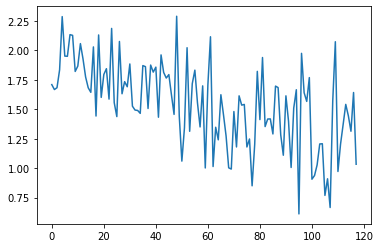

In [10]:
plt.plot(list(range(len(terrs))), terrs)

expect: bird
got: airplane
probability: [0.9999999 0.        0.        0.        0.        0.        0.
 0.        0.        0.       ]


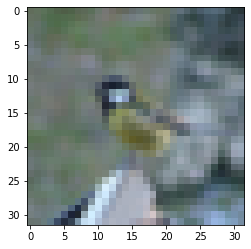

In [11]:
raw_inshape[0] = 1
testin = tc.EVariable(raw_inshape, label="testin")
testout = model.connect(testin)
testidx = tc.argmax(testout)

tds = tfds.load('cifar10',
                split=tfds.Split.TEST, batch_size=1, shuffle_files=True)
image = next(tfds.as_numpy(tds))
names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck',]
testin.assign(image['image'].astype(np.float))
test_sess = tc.Session()
test_sess.track([testidx])
test_sess.update_target([testidx])
print('expect: {}'.format(names[image['label'][0]]))
print('got: {}'.format(names[int(testidx.get())]))
print('probability: {}'.format(testout.get()))

plt.imshow(image['image'].reshape(*raw_inshape[1:]))
plt.show()